In [1]:
import torch, sys
print("python:", sys.executable)
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())


python: /mmfs1/gscratch/stf/bitama/envs/pt310-cu121/bin/python
torch: 2.3.1+cu121
cuda available: True


In [2]:
%pip install --upgrade pandas
import pandas as pd, sys
print("pandas:", pd.__version__)
print("python:", sys.executable)


Note: you may need to restart the kernel to use updated packages.
pandas: 2.3.3
python: /mmfs1/gscratch/stf/bitama/envs/pt310-cu121/bin/python


In [3]:
# MICrONS setup
import sys, subprocess, json, os, pathlib, site, importlib

print("Python:", sys.version)
device = "cpu"
try:
    import torch
    device = "cuda" if torch.cuda.is_available() else "cpu"
except Exception:
    pass
print("Using device:", device)

# ---- Working dir + local deps 
WKDIR = pathlib.Path("/mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_incremental_nm")
WKDIR.mkdir(parents=True, exist_ok=True)
os.chdir(WKDIR)

PY_MAJMIN = f"{sys.version_info.major}.{sys.version_info.minor}"
USER_SITE  = site.getusersitepackages()  # disabled on your Jupyter, but keep on path anyway
LOCAL_DEPS = WKDIR / f"_deps_py{PY_MAJMIN}"
LOCAL_DEPS.mkdir(exist_ok=True)

def _ensure_on_path(p):
    p = str(p)
    if p not in sys.path:
        sys.path.insert(0, p)

try: site.ENABLE_USER_SITE = True
except Exception: pass
_ensure_on_path(USER_SITE)
_ensure_on_path(LOCAL_DEPS)

# ---- Package 
PKG_TO_MOD = {
    "caveclient":    "caveclient",
    "cloud-volume":  "cloudvolume",   # <--- correct import name
    "imageryclient": "imageryclient",
}

def smart_install(pkg: str, mod: str):
    """Try import; else install to LOCAL_DEPS, then import."""
    try:
        importlib.import_module(mod)
        return
    except Exception:
        pass
    print(f"[pip -t LOCAL_DEPS --upgrade] {pkg} -> {LOCAL_DEPS}")
    subprocess.check_call([
        sys.executable, "-m", "pip", "install",
        "-t", str(LOCAL_DEPS), "--upgrade", "--no-cache-dir", pkg, "--quiet"
    ])
    _ensure_on_path(LOCAL_DEPS)
    importlib.import_module(mod)  # verify immediately

for pkg, mod in PKG_TO_MOD.items():
    smart_install(pkg, mod)

from caveclient import CAVEclient

# ---- Auth 
def setup_cave_token(datastack="minnie65_public"):
    sec_path = pathlib.Path.home()/".cloudvolume"/"secrets"/"cave-secret.json"
    token = os.environ.get("CAVE_AUTH_TOKEN", "")
    if not token and sec_path.exists():
        try:
            token = json.loads(sec_path.read_text()).get("token", "")
        except Exception:
            token = ""
    if not token:
        print("\nCreate/copy token: https://global.daf-apis.com/auth/api/v1/create_token")
        token = input("\nToken: ").strip()
        if not token:
            raise ValueError("No token provided.")
        sec_path.parent.mkdir(parents=True, exist_ok=True)
        sec_path.write_text(json.dumps({"token": token}))
    os.environ["CAVE_AUTH_TOKEN"] = token

    client = CAVEclient(datastack)
    _ = client.info.get_datastack_info()
    print("Token accepted — connected to MICRONS.")
    return client

# ---- CloudVolume / ImageryClient 
def setup_cloudvolumes(client):
    from cloudvolume import CloudVolume
    img_src = client.info.image_source()
    seg_src = client.info.segmentation_source()
    em_vol  = CloudVolume(img_src, progress=False, use_https=True)
    seg_vol = CloudVolume(seg_src, progress=False, use_https=True)
    print("EM OK | res (nm):", getattr(em_vol, "resolution", "unknown"))
    print("SEG OK")
    return em_vol, seg_vol

def setup_imagery(client):
    import imageryclient as ic
    img_client = ic.ImageryClient(client=client)
    print("ImageryClient ready")
    return img_client

def test_access(img_client):
    ctr = [240640, 207872, 21360]  # in-bounds
    try:
        em, segs = img_client.image_and_segmentation_cutout(
            ctr, bbox_size=(128,128), scale_to_bounds=True, split_segmentations=True
        )
        import numpy as np
        a = np.asarray(em)
        if a.ndim == 3: a = a[...,0]
        print("✔ Small download OK | EM:", a.shape, a.dtype, "| seg objs:", len(segs))
    except Exception as e:
        print("Test download failed:", repr(e))

print("\n=== MICrONS SETUP ===")
client = setup_cave_token()
em_vol, seg_vol = setup_cloudvolumes(client)
img_client = setup_imagery(client)
test_access(img_client)
print("Setup complete. cwd:", os.getcwd())



Python: 3.10.19 (main, Oct 21 2025, 16:43:05) [GCC 11.2.0]
Using device: cuda


/mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_incremental_nm/_deps_py3.10/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)



=== MICrONS SETUP ===
Token accepted — connected to MICRONS.
EM OK | res (nm): [ 8  8 40]
SEG OK
ImageryClient ready
✔ Small download OK | EM: (128, 128) uint8 | seg objs: 4
Setup complete. cwd: /mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_incremental_nm


In [4]:
#2
from pathlib import Path

# SINGLE SOURCE OF TRUTH for where cubes + labels go
EM_DIR = Path("/mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_incremental_nm")
LABELS_CSV = EM_DIR / "ml_labels.csv"

# Sanity checks
print("[PATH] EM_DIR:", EM_DIR.resolve())
EM_DIR.mkdir(parents=True, exist_ok=True)
assert EM_DIR.exists() and EM_DIR.is_dir(), "EM_DIR missing"
print("[PATH] LABELS_CSV:", LABELS_CSV)

# tiny marker file so I know i'm writing here
(EM_DIR / ".write_test").write_text("ok")
print("[OK] Write check passed")


[PATH] EM_DIR: /mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_incremental_nm
[PATH] LABELS_CSV: /mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_incremental_nm/ml_labels.csv
[OK] Write check passed


In [5]:

# ==============================================================
# Continuous EM Cube Downloader + Auto-Relabel + Progress Log
# Saves ONLY into:
#   /mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_incremental_nm
# Prereqs: caveclient, imageryclient installed; MICrONS token set up.
# ==============================================================

import os, json, time, signal, sys
from pathlib import Path
from shutil import disk_usage
from datetime import datetime

import numpy as np
import pandas as pd
import tifffile as tiff

from caveclient import CAVEclient
import imageryclient as ic

# FIXED SAVE LOCATION 
OUT_DIR = Path("/mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_incremental_nm")

OUT_DIR.mkdir(exist_ok=True, parents=True)

# Files written here
PROGRESS_CSV = OUT_DIR / "progress_log.csv"
LABELS_CSV   = OUT_DIR / "ml_labels.csv"

#  INPUT SPLITS 
ROOT   = Path("/mmfs1/gscratch/stf/bitama/microns_full")
SPLITS = ROOT / "real_ml_data_full" / "splits"
TRAIN_SPLIT = SPLITS / "train_synapses_balanced.csv"

# MICrONS CONFIG 
DATASTACK = "minnie65_public"
SYN_TABLE = "synapses_pni_2"
TYPES_TABLE = "baylor_log_reg_cell_type_coarse_v1"

#  DOWNLOAD TARGETS 
TARGET_CUBES_TOTAL = 5000   # stop once we hit this many TIFFs in OUT_DIR
SAVE_LIMIT         = 256    # cubes per pass (keep reasonable)
POOL_SIZE          = 20000  # candidate synapses per pass
SLEEP_BETWEEN_S    = 5      # pause between passes (sec)

# DISK SAFETY 
WATCH_PATH = "/mmfs1/gscratch/stf/bitama"
MIN_FREE_GB = 5.0           # stop if remaining space lower than this

# GEOMETRY 
Z_SLICES = 32
CUBE_YX  = (128, 128)       # (W,H) pixels
VOX_NM_Z = 40.0             # plane step in nanometers (dataset is 8x8x40 nm)

# ==============================================================
# Helpers
# ==============================================================

def gb_free(path):
    total, used, free = disk_usage(path)
    return free / (1024**3)

def existing_ids():
    return {int(p.stem) for p in OUT_DIR.glob("*.tif") if p.stem.isdigit()}

def load_train_ids():
    if not TRAIN_SPLIT.exists():
        raise FileNotFoundError(f"Missing split file: {TRAIN_SPLIT}")
    t = pd.read_csv(TRAIN_SPLIT)
    if "synapse_id" not in t.columns:
        raise RuntimeError(f"'synapse_id' missing in {TRAIN_SPLIT}. Got: {list(t.columns)}")
    return t["synapse_id"].astype(int).tolist()

def parse_listish(v):
    if isinstance(v,(list,tuple,np.ndarray)) and len(v)>=3:
        return float(v[0]),float(v[1]),float(v[2])
    if isinstance(v,str):
        try:
            vv=json.loads(v)
            if isinstance(vv,(list,tuple)) and len(vv)>=3:
                return float(vv[0]),float(vv[1]),float(vv[2])
        except Exception:
            pass
    return (np.nan,np.nan,np.nan)

def pick_xyz_nm(row, cols):
    def has_split(prefix): return (f"{prefix}_x" in cols) and (f"{prefix}_y" in cols) and (f"{prefix}_z" in cols)
    def get_split(prefix):
        try: return float(row[f"{prefix}_x"]), float(row[f"{prefix}_y"]), float(row[f"{prefix}_z"])
        except Exception: return (np.nan,np.nan,np.nan)
    # prefer center -> pre -> post
    for prefix in ("ctr_pt_position","pre_pt_position","post_pt_position"):
        if has_split(prefix):
            x,y,z = get_split(prefix)
            if not (np.isnan(x) or np.isnan(y) or np.isnan(z)): return (x,y,z)
        if prefix in cols:
            x,y,z = parse_listish(row[prefix])
            if not (np.isnan(x) or np.isnan(y) or np.isnan(z)): return (x,y,z)
    return (np.nan,np.nan,np.nan)

def build_cube(img_cli, center_nm):
    cx,cy,cz = center_nm
    z0 = cz - (Z_SLICES//2)*VOX_NM_Z
    planes=[]
    for i in range(Z_SLICES):
        z_nm = z0 + i*VOX_NM_Z
        ctr = [int(round(cx)), int(round(cy)), int(round(z_nm))]
        try:
            img,_ = img_cli.image_and_segmentation_cutout(
                ctr, bbox_size=CUBE_YX, scale_to_bounds=True, split_segmentations=False
            )
            a = np.asarray(img)
            if a.ndim==3: a=a[...,0]
            planes.append(a.astype(np.uint8))
        except Exception:
            planes.append(np.zeros((CUBE_YX[1],CUBE_YX[0]),dtype=np.uint8))
    return np.stack(planes,axis=0)

#  progress logging 
def ensure_progress_header():
    if not PROGRESS_CSV.exists():
        PROGRESS_CSV.write_text(
            "timestamp,pass_idx,have,total_target,new_saved,remaining,free_gb,labels_ex,labels_inh,labels_unknown\n"
        )

def autorlabel_and_counts(client):
    """
    Label ONLY the cubes that exist in OUT_DIR.
    Writes/updates ml_labels.csv.
    Returns tuple (excitatory_count, inhibitory_count, unknown_count).
    """
    mat = client.materialize
    tiff_ids = [int(p.stem) for p in OUT_DIR.glob("*.tif") if p.stem.isdigit()]
    if not tiff_ids:
        return (0,0,0)

    # synapse -> presyn root
    df_syn = mat.query_table(
        SYN_TABLE,
        filter_in_dict={"id": tiff_ids},
        select_columns=["id","pre_pt_root_id"],
        split_positions=False,
        limit=len(tiff_ids),
        return_df=True
    ).drop_duplicates("id")
    df_syn["synapse_id"] = df_syn["id"].astype(int)
    df_syn["pre_pt_root_id"] = pd.to_numeric(df_syn["pre_pt_root_id"], errors="coerce").astype("Int64")
    df_syn = df_syn[["synapse_id","pre_pt_root_id"]]

    # discover columns in types table
    probe = mat.query_table(TYPES_TABLE, limit=5, return_df=True)
    low2orig = {c.lower(): c for c in probe.columns}
    root_col = next((low2orig[c] for c in ("pt_root_id","root_id","pre_pt_root_id","post_pt_root_id") if c in low2orig), None)
    type_col = next((low2orig[c] for c in ("broad_type","cell_type","class","type","coarse_type") if c in low2orig), None)
    if root_col is None or type_col is None:
        # fallback: keep any existing labels as-is
        if LABELS_CSV.exists():
            lbl = pd.read_csv(LABELS_CSV)
            ct = lbl["cell_type"].value_counts(dropna=False)
            return (int(ct.get("excitatory",0)), int(ct.get("inhibitory",0)), int(ct.get("",0)))
        return (0,0,0)

    # batch-load all types
    parts=[]; offset=0; batch=50000
    while True:
        chunk = mat.query_table(TYPES_TABLE, limit=batch, offset=offset, return_df=True)
        if chunk is None or chunk.empty: break
        parts.append(chunk[[root_col, type_col]])
        offset += len(chunk)
        if len(chunk) < batch: break

    types = pd.concat(parts, ignore_index=True) if parts else probe[[root_col,type_col]].copy()
    types.columns = ["root_id","raw_type"]
    def norm(s):
        s = (s or "")
        s = s.lower() if isinstance(s,str) else ""
        if "excit" in s: return "excitatory"
        if "inhib" in s: return "inhibitory"
        return ""
    types["root_id"] = pd.to_numeric(types["root_id"], errors="coerce").astype("Int64")
    types["cell_type"] = types["raw_type"].map(norm)
    types = types.dropna(subset=["root_id"]).drop_duplicates("root_id")[["root_id","cell_type"]]

    labeled = df_syn.merge(types, left_on="pre_pt_root_id", right_on="root_id", how="left")
    labeled["cell_type"] = labeled["cell_type"].fillna("")
    keep = labeled[["synapse_id","cell_type"]].drop_duplicates("synapse_id").copy()
    keep["label"] = keep["cell_type"].map(lambda t: 1 if t=="excitatory" else (0 if t=="inhibitory" else ""))
    keep = keep[["synapse_id","label","cell_type"]].sort_values("synapse_id")
    keep.to_csv(LABELS_CSV, index=False)

    vc = keep["cell_type"].value_counts(dropna=False)
    return (int(vc.get("excitatory",0)), int(vc.get("inhibitory",0)), int(vc.get("",0)))

def log_progress(pass_idx, have, saved_this_pass, free_gb, client):
    ex, inh, unk = autorlabel_and_counts(client)
    remaining = max(TARGET_CUBES_TOTAL - have, 0)
    ensure_progress_header()
    with PROGRESS_CSV.open("a") as f:
        f.write(f"{datetime.now().isoformat(timespec='seconds')},{pass_idx},{have},{TARGET_CUBES_TOTAL},{saved_this_pass},{remaining},{free_gb:.1f},{ex},{inh},{unk}\n")
    print(f"[PROGRESS] pass={pass_idx} total={have} (+{saved_this_pass}) remaining={remaining} free={free_gb:.1f}GB | labels E/I/? = {ex}/{inh}/{unk}")

#  INTERRUPT HANDLING 
_stop=False
def _sigint_handler(sig,frame):
    global _stop
    _stop=True
    print("\n[CTRL-C] Will stop after current cube.")
signal.signal(signal.SIGINT,_sigint_handler)

#  MAIN LOOP 
def main():
    print(f"[OUT_DIR] {OUT_DIR}")
    client = CAVEclient(DATASTACK)
    img_cli = ic.ImageryClient(client=client)
    train_ids = load_train_ids()
    print(f"[SPLIT] TRAIN ids available: {len(train_ids)}")

    pass_idx = 0
    while True:
        if _stop:
            print("[STOP] Exiting.")
            return

        free_gb = gb_free(WATCH_PATH)
        if free_gb < MIN_FREE_GB:
            print(f"[DISK] Only {free_gb:.2f}GB free < {MIN_FREE_GB}GB. Exiting.")
            return

        existing = existing_ids()
        n_exist = len(existing)
        if n_exist >= TARGET_CUBES_TOTAL:
            print(f"[DONE] {n_exist} cubes >= target {TARGET_CUBES_TOTAL}.")
            # final relabel to be sure
            try:
                ex,inh,unk = autorlabel_and_counts(client)
                print(f"[LABELS] final E/I/? = {ex}/{inh}/{unk}")
            except Exception as e:
                print("[WARN] final autorlabel failed:", e)
            return

        # pool excluding already-saved
        pool = [i for i in train_ids if i not in existing]
        if not pool:
            print("[EMPTY] No more new synapses to sample from TRAIN split.")
            # still relabel & finish
            try:
                ex,inh,unk = autorlabel_and_counts(client)
                print(f"[LABELS] E/I/? = {ex}/{inh}/{unk}")
            except Exception as e:
                print("[WARN] autorlabel failed:", e)
            return

        # shrink pool to POOL_SIZE
        ps = pd.Series(pool)
        if len(ps) > POOL_SIZE:
            ps = ps.sample(POOL_SIZE, random_state=pass_idx)
        pool_ids = ps.tolist()

        print(f"\n=== PASS {pass_idx} ===")
        print(f"[STATE] have={n_exist} free={free_gb:.1f}GB pool={len(pool_ids)}")

        # query coords
        qdf = client.materialize.query_table(
            SYN_TABLE,
            filter_in_dict={"id": pool_ids},
            limit=len(pool_ids),
            split_positions=True,
            return_df=True,
        )

        cols = set(qdf.columns)
        xyz = qdf.apply(lambda r: pick_xyz_nm(r, cols), axis=1, result_type="expand")
        xyz.columns = ["x_nm","y_nm","z_nm"]
        dfc = pd.concat([qdf[["id"]].rename(columns={"id":"synapse_id"}), xyz], axis=1)
        dfc["synapse_id"] = dfc["synapse_id"].astype(int)
        valid = dfc.dropna(subset=["x_nm","y_nm","z_nm"])

        # remove any that somehow exist already
        valid = valid[~valid["synapse_id"].isin(existing)]

        if valid.empty:
            print("[PASS] No valid coords this pass.")
            # still log with zero saved (keeps heartbeat)
            log_progress(pass_idx, len(existing_ids()), 0, free_gb, client)
            pass_idx += 1
            time.sleep(SLEEP_BETWEEN_S)
            continue

        # choose up to SAVE_LIMIT to download
        batch = valid.sample(min(SAVE_LIMIT, len(valid)), random_state=pass_idx)

        saved = 0
        for r in batch.itertuples(index=False):
            if _stop: break
            sid = int(r.synapse_id)
            outp = OUT_DIR / f"{sid}.tif"
            if outp.exists():
                continue
            vol = build_cube(img_cli, (r.x_nm, r.y_nm, r.z_nm))
            tiff.imwrite(outp, vol, bigtiff=False)
            saved += 1

        print(f"[SAVE] Wrote {saved} cubes this pass. Total now: {len(existing_ids())}")
        # progress + autorlabel
        try:
            log_progress(pass_idx, len(existing_ids()), saved, free_gb, client)
        except Exception as e:
            print("[WARN] progress/autorlabel failed:", e)

        pass_idx += 1
        time.sleep(SLEEP_BETWEEN_S)

if __name__ == "__main__":
    main()


[OUT_DIR] /mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_incremental_nm
[SPLIT] TRAIN ids available: 1029014

=== PASS 0 ===
[STATE] have=2 free=1353.1GB pool=20000

[CTRL-C] Will stop after current cube.
[SAVE] Wrote 1 cubes this pass. Total now: 3


201 - "Limited query to 3 rows
201 - "Limited query to 5 rows
201 - "Limited query to 50000 rows


[PROGRESS] pass=0 total=3 (+1) remaining=4997 free=1353.1GB | labels E/I/? = 2/1/0
[STOP] Exiting.


In [7]:
from pathlib import Path
OUT_DIR = Path("/mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_incremental_nm")
n = sum(1 for p in OUT_DIR.glob("*.tif") if p.stem.isdigit())
print("TIFF cubes saved:", n)



TIFF cubes saved: 3


[SPLIT] Candidate TRAIN ids: 5000
[MAT] columns: ['id', 'created', 'superceded_id', 'valid', 'pre_pt_position_x', 'pre_pt_position_y', 'pre_pt_position_z', 'post_pt_position_x', 'post_pt_position_y', 'post_pt_position_z', 'ctr_pt_position_x', 'ctr_pt_position_y', 'ctr_pt_position_z', 'size', 'pre_pt_supervoxel_id', 'pre_pt_root_id', 'post_pt_supervoxel_id', 'post_pt_root_id']
[COORDS] Valid coords: 4989 / 4989
[SAVE] Wrote 16 cubes to /gscratch/scrubbed/bitama/em_sample_ic in 606.9s
[CHECK] First stack: shape=(32, 128, 128) dtype=uint8 min=0 max=170


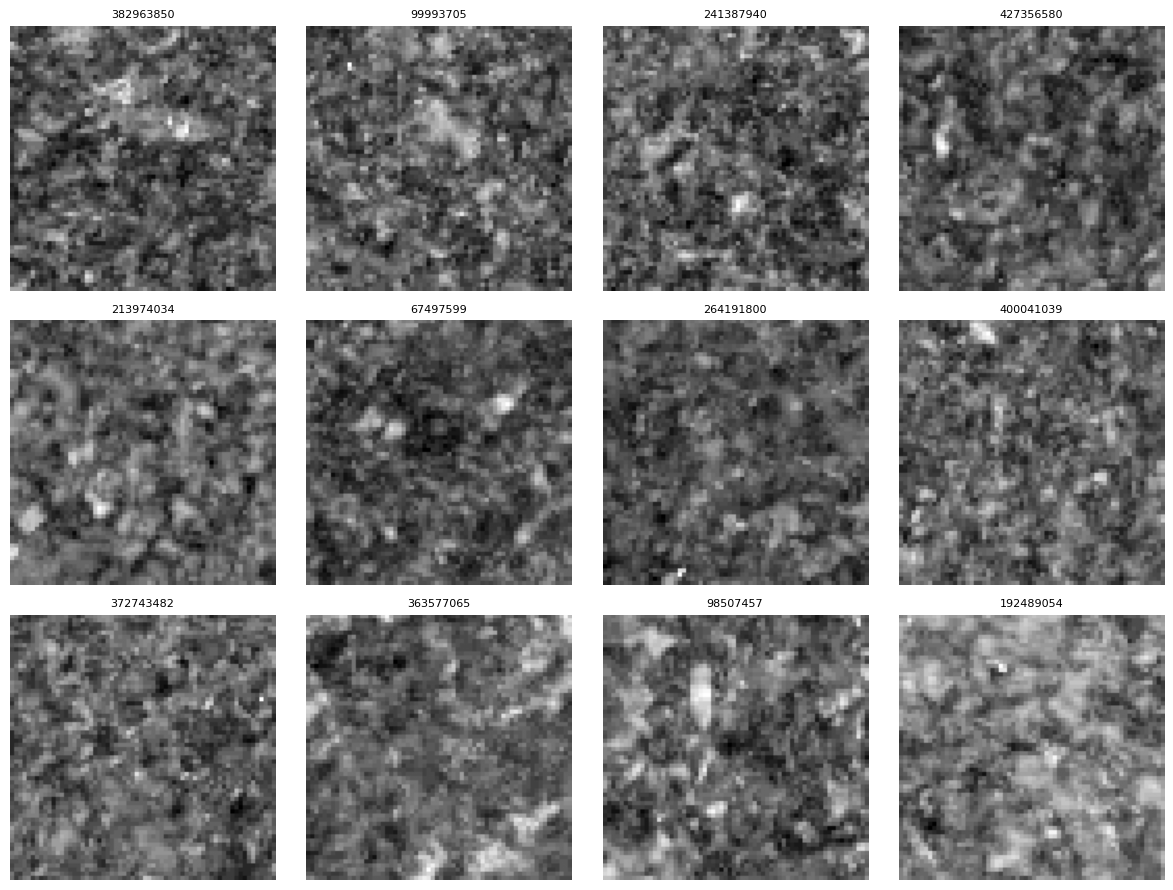

In [8]:
# === 3D EM cube sampler (ImageryClient expects nanometers) ====================
# - Finds TRAIN split in your ORIGINAL location, not in SCRUBBED
# - Handles split/list XYZ columns from Materialize
# - Uses 40 nm Z step; saves (Z,Y,X) uint8 TIFF stacks + quick MIP gallery
# ==============================================================================

import json, time, math
import numpy as np
import pandas as pd
from pathlib import Path
import tifffile as tiff
import matplotlib.pyplot as plt

from caveclient import CAVEclient
import imageryclient as ic

# -------------------- CONFIG --------------------
# Where to SAVE sampled cubes (SCRUBBED safe)
SCRUB_ROOT = Path("/gscratch/scrubbed/bitama")
OUT_DIR    = SCRUB_ROOT / "em_sample_ic"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Where the TRAIN split actually lives (ORIGINAL tree)
SPLITS = Path("/mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/splits")
TRAIN_SPLIT = SPLITS / "train_synapses_balanced.csv"

DATASTACK = "minnie65_public"
SYN_TABLE = "synapses_pni_2"

POOL_SIZE = 5000       # initial candidate pool
SAMPLE_N  = 16         # how many to actually fetch/save
SEED      = 0

# Cube geometry (Z,Y,X)
Z_SLICES = 32
CUBE_YX  = (128, 128)  # (W,H) pixels per plane

# Physical voxel size (nm) — used for Z stepping
VOX_NM_Z = 40.0

# -------------------- LOAD TRAIN IDS --------------------
if not TRAIN_SPLIT.exists():
    raise FileNotFoundError(f"Missing split file: {TRAIN_SPLIT}")

train = pd.read_csv(TRAIN_SPLIT)
if "synapse_id" not in train.columns:
    raise RuntimeError(f"'synapse_id' column missing in {TRAIN_SPLIT}. Got: {list(train.columns)}")

pool_ids = train["synapse_id"].astype(int)
if len(pool_ids) > POOL_SIZE:
    pool_ids = pool_ids.sample(POOL_SIZE, random_state=SEED)
pool_ids = pool_ids.tolist()
print(f"[SPLIT] Candidate TRAIN ids: {len(pool_ids)}")

# -------------------- QUERY MATERIALIZE --------------------
client = CAVEclient(DATASTACK)
mat = client.materialize

df_syn = mat.query_table(
    SYN_TABLE,
    filter_in_dict={"id": pool_ids},
    limit=len(pool_ids),
    split_positions=True,      # get *_x, *_y, *_z when available
    return_df=True,
)
print("[MAT] columns:", list(df_syn.columns))

# -------------------- COORD PARSERS --------------------
def _parse_listish(v):
    if isinstance(v, (list, tuple, np.ndarray)) and len(v) >= 3:
        return float(v[0]), float(v[1]), float(v[2])
    if isinstance(v, str):
        try:
            vv = json.loads(v)
            if isinstance(vv, (list, tuple)) and len(vv) >= 3:
                return float(vv[0]), float(vv[1]), float(vv[2])
        except Exception:
            pass
    return (np.nan, np.nan, np.nan)

def pick_xyz_nm_from_row(row, cols):
    def has_split(prefix):
        return (f"{prefix}_x" in cols) and (f"{prefix}_y" in cols) and (f"{prefix}_z" in cols)
    def get_split(prefix):
        try:
            return (float(row[f"{prefix}_x"]), float(row[f"{prefix}_y"]), float(row[f"{prefix}_z"]))
        except Exception:
            return (np.nan, np.nan, np.nan)
    def get_list(prefix):
        return _parse_listish(row.get(prefix, None))

    # Prefer center -> pre -> post
    for prefix in ("ctr_pt_position", "pre_pt_position", "post_pt_position"):
        if has_split(prefix):
            x, y, z = get_split(prefix)
            if not (np.isnan(x) or np.isnan(y) or np.isnan(z)):
                return (x, y, z)
        if prefix in cols:
            x, y, z = get_list(prefix)
            if not (np.isnan(x) or np.isnan(y) or np.isnan(z)):
                return (x, y, z)
    return (np.nan, np.nan, np.nan)

cols = set(df_syn.columns)
xyz = df_syn.apply(lambda r: pick_xyz_nm_from_row(r, cols), axis=1, result_type="expand")
xyz.columns = ["x_nm","y_nm","z_nm"]

dfc = pd.concat([df_syn[["id"]].rename(columns={"id":"synapse_id"}), xyz], axis=1)
valid = dfc.dropna(subset=["x_nm","y_nm","z_nm"]).reset_index(drop=True)
print(f"[COORDS] Valid coords: {len(valid)} / {len(dfc)}")

if len(valid) == 0:
    raise RuntimeError("No valid coordinates found. Increase POOL_SIZE or verify position columns.")

# Downsample to SAMPLE_N
if len(valid) > SAMPLE_N:
    valid = valid.sample(SAMPLE_N, random_state=SEED).reset_index(drop=True)

# -------------------- IMAGERY FETCH (expects NANOMETERS) --------------------
img_client = ic.ImageryClient(client=client)

def fetch_slice_nm(center_nm_xyz, z_plane_nm, box_yx=CUBE_YX):
    cx_nm, cy_nm, _ = center_nm_xyz
    ctr_nm = [int(round(cx_nm)), int(round(cy_nm)), int(round(z_plane_nm))]
    img, _ = img_client.image_and_segmentation_cutout(
        ctr_nm,
        bbox_size=box_yx,          # (W,H) pixels
        split_segmentations=False,
        scale_to_bounds=True,      # clamp to dataset bounds
    )
    a = np.asarray(img)
    if a.ndim == 3:
        a = a[..., 0]
    return a.astype(np.uint8)

def build_cube_nm(center_nm_xyz, z_slices=Z_SLICES, box_yx=CUBE_YX):
    cx_nm, cy_nm, cz_nm = center_nm_xyz
    z0_nm = cz_nm - (z_slices // 2) * VOX_NM_Z
    planes = []
    for i in range(z_slices):
        z_plane_nm = z0_nm + i * VOX_NM_Z
        try:
            sl = fetch_slice_nm((cx_nm, cy_nm, cz_nm), z_plane_nm, box_yx=box_yx)
        except Exception:
            sl = np.zeros((box_yx[1], box_yx[0]), dtype=np.uint8)
        planes.append(sl)
    return np.stack(planes, axis=0)  # (Z,Y,X)

# -------------------- BUILD & SAVE --------------------
saved = []
t0 = time.time()
for r in valid.itertuples(index=False):
    sid = int(r.synapse_id)
    center_nm = (float(r.x_nm), float(r.y_nm), float(r.z_nm))  # nm
    vol = build_cube_nm(center_nm, z_slices=Z_SLICES, box_yx=CUBE_YX)
    outp = OUT_DIR / f"{sid}.tif"
    tiff.imwrite(outp, vol, bigtiff=False)
    saved.append(outp)

dt = time.time() - t0
print(f"[SAVE] Wrote {len(saved)} cubes to {OUT_DIR} in {dt:.1f}s")

# -------------------- QUICK MIP GALLERY --------------------
def mip_zyx(v): 
    return v.max(axis=0)

if saved:
    test = tiff.imread(saved[0])
    print(f"[CHECK] First stack: shape={test.shape} dtype={test.dtype} min={test.min()} max={test.max()}")
    n = min(12, len(saved)); cols = 4; rows = int(math.ceil(n/cols))
    plt.figure(figsize=(cols*3, rows*3))
    for i, p in enumerate(saved[:n], 1):
        v = tiff.imread(p)
        plt.subplot(rows, cols, i); plt.axis("off")
        plt.title(Path(p).stem, fontsize=8)
        plt.imshow(mip_zyx(v), cmap="gray")
    plt.tight_layout(); plt.show()
else:
    print("[CHECK] No images saved.")


In [9]:
# ===================== Rebuild Labels (from MICrONS) + Train 3D Classifier =====================
# - Recomputes ml_labels.csv ONLY for TIFFs present in EM_DIR (so IDs match)
# - Robust type-column detection (Baylor coarse types), maps to {0=inhibitory,1=excitatory}
# - Light augs, focal BCE, class-balanced sampling, τ sweep on VAL, best checkpoint to TEST
# ==============================================================================================

# ---------- PATHS ----------
EM_DIR       = "/gscratch/scrubbed/bitama/em_incremental_nm"   # where your TIFFs (Z,Y,X) live
LABELS_PATH  = f"{EM_DIR}/ml_labels.csv"                      # will be (re)written here

# MICrONS tables (update if your deployment differs)
DATASTACK    = "minnie65_public"
SYN_TABLE    = "synapses_pni_2"
TYPES_TABLE  = "baylor_log_reg_cell_type_coarse_v1"   # coarse E/I types table

# ---------- Imports ----------
from pathlib import Path
import os, math, random, time, re, shutil
import numpy as np
import pandas as pd
import tifffile as tiff
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# MICrONS clients
from caveclient import CAVEclient
import imageryclient as ic  # not strictly needed here, but ok to import

# ---------- Train Config ----------
Z, Y, X    = 32, 128, 128
BATCH      = 6
EPOCHS     = 30
LR         = 3e-4
WD         = 1e-4
ALPHA      = 0.25
GAMMA      = 2.0
VAL_EVERY  = 1
NUM_WORKERS= 0
PIN_MEM    = False
SEED       = 42
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = True

em_dir = Path(EM_DIR)
assert em_dir.exists(), f"Missing EM_DIR: {EM_DIR}"

# ==============================================================================================
# 1) Enumerate TIFFs present and rebuild ml_labels.csv to match those IDs exactly
# ==============================================================================================

# collect stems -> numeric ids
files = list(em_dir.glob("*.tif")) + list(em_dir.glob("*.tiff"))
if not files:
    raise RuntimeError(f"No TIFF files found in {EM_DIR}")

def stem_first_int(p: Path):
    m = re.search(r"(\d+)", p.stem)
    return int(m.group(1)) if m else None

stems = pd.DataFrame({
    "path": files,
    "stem": [p.stem for p in files],
})
stems["synapse_id"] = stems["stem"].map(lambda s: int(re.search(r"(\d+)", s).group(1)) if re.search(r"(\d+)", s) else np.nan)
stems = stems.dropna(subset=["synapse_id"]).copy()
stems["synapse_id"] = stems["synapse_id"].astype(int)

print(f"[FILES] TIFFs: {len(stems)} | sample: {stems['stem'].head(10).tolist()}")

# query materialize for pre root ids for exactly these TIFF ids
client = CAVEclient(DATASTACK)
mat = client.materialize

# synapses table: get pre_pt_root_id for our synapse_ids
df_syn = mat.query_table(
    SYN_TABLE,
    filter_in_dict={"id": stems["synapse_id"].tolist()},
    limit=len(stems),
    select_columns=["id","pre_pt_root_id"],
    split_positions=False,
    return_df=True,
)
if df_syn is None or df_syn.empty:
    raise RuntimeError("Materialize returned no rows for our TIFF synapse IDs.")

df_syn = df_syn.drop_duplicates("id").rename(columns={"id":"synapse_id"})
df_syn["pre_pt_root_id"] = pd.to_numeric(df_syn["pre_pt_root_id"], errors="coerce").astype("Int64")

# types table: discover likely columns for root id and type label
probe = mat.query_table(TYPES_TABLE, limit=5, return_df=True)
if probe is None or probe.empty:
    raise RuntimeError(f"Could not probe types table: {TYPES_TABLE}")

low2orig = {c.lower(): c for c in probe.columns}
# try a few variants
root_col = next((low2orig[c] for c in ("pt_root_id","root_id","pre_pt_root_id","post_pt_root_id") if c in low2orig), None)
type_col = next((low2orig[c] for c in ("broad_type","cell_type","class","type","coarse_type","label") if c in low2orig), None)
if root_col is None or type_col is None:
    raise RuntimeError(f"Could not find root/type columns in {TYPES_TABLE}. Columns={list(probe.columns)}")

# load full mapping in chunks
parts=[]
offset=0
batch=50000
while True:
    chunk = mat.query_table(TYPES_TABLE, limit=batch, offset=offset, return_df=True)
    if chunk is None or chunk.empty:
        break
    parts.append(chunk[[root_col, type_col]])
    offset += len(chunk)
    if len(chunk) < batch:
        break

types = pd.concat(parts, ignore_index=True) if parts else probe[[root_col, type_col]].copy()
types.columns = ["root_id","raw_type"]
types["root_id"] = pd.to_numeric(types["root_id"], errors="coerce").astype("Int64")

def norm_type(s):
    s = (s or "")
    s = s.lower() if isinstance(s,str) else ""
    if "excit" in s: return "excitatory"
    if "inhib" in s: return "inhibitory"
    return ""

types["cell_type"] = types["raw_type"].map(norm_type)
types = types.dropna(subset=["root_id"]).drop_duplicates("root_id")[["root_id","cell_type"]]

# join: synapse -> pre root -> cell_type
lab = df_syn.merge(types, left_on="pre_pt_root_id", right_on="root_id", how="left")
lab["cell_type"] = lab["cell_type"].fillna("")
lab["label"] = lab["cell_type"].map(lambda t: 1 if t=="excitatory" else (0 if t=="inhibitory" else ""))
lab = lab[["synapse_id","label","cell_type"]].drop_duplicates("synapse_id")

# keep only rows that correspond to files present
lab = stems[["synapse_id"]].merge(lab, on="synapse_id", how="left")
lab["label"] = lab["label"].replace({np.nan: ""})

# write labels (so the rest of the pipeline can read it)
lab.to_csv(LABELS_PATH, index=False)
vc = lab["cell_type"].value_counts(dropna=False)
print(f"[LABELS] wrote: {LABELS_PATH} | counts E/I/? = {int(vc.get('excitatory',0))}/{int(vc.get('inhibitory',0))}/{int(vc.get('',0))}")

# ==============================================================================================
# 2) Robust join (now labels are guaranteed to refer to existing TIFFs), dataset, model, training
# ==============================================================================================

# Load back labels; keep only binary 0/1
df = pd.read_csv(LABELS_PATH)
if "label" not in df.columns:
    raise RuntimeError("labels csv must contain a 'label' column.")
df = df[df["label"].isin([0,1])].drop_duplicates()
if df.empty:
    raise RuntimeError("No labeled (0/1) rows after rebuild. Ensure types table maps to E/I for these synapses.")

# Build id->label map and ensure TIFFs exist for them
id_to_label = dict(zip(df["synapse_id"].astype(int), df["label"].astype(int)))

# filter to ids that have a file present
def find_file_for_sid(sid: int) -> Path:
    p = em_dir / f"{sid}.tif"
    if p.exists(): return p
    p = em_dir / f"{sid}.tiff"
    if p.exists(): return p
    # fallback: any tif that contains the number in the stem (avoid being too loose)
    cands = list(em_dir.glob(f"*{sid}*.tif")) + list(em_dir.glob(f"*{sid}*.tiff"))
    return cands[0] if cands else None

kept = []
for sid in list(id_to_label.keys()):
    if find_file_for_sid(sid) is not None:
        kept.append(sid)
    else:
        id_to_label.pop(sid, None)

if len(kept) < 4:
    print("[DEBUG] Example of labels head:")
    print(df.head())
    raise RuntimeError(f"Too few labeled cubes that have matching TIFFs in {EM_DIR}. Need ≥4; have {len(kept)}.")

print(f"[JOIN] matched TIFF+label pairs: {len(kept)}  class counts:",
      Counter([id_to_label[i] for i in kept]))

# ---------------- Dataset ----------------
class EM3DDataset(Dataset):
    def __init__(self, em_dir: str, ids: list[int], labels: dict[int,int], augment: bool):
        self.em_dir = Path(em_dir)
        self.ids = ids
        self.labels = labels
        self.augment = augment

    def _file(self, sid: int) -> Path:
        p = self.em_dir / f"{sid}.tif"
        if p.exists(): return p
        p = self.em_dir / f"{sid}.tiff"
        if p.exists(): return p
        cands = list(self.em_dir.glob(f"*{sid}*.tif")) + list(self.em_dir.glob(f"*{sid}*.tiff"))
        if cands: return cands[0]
        raise FileNotFoundError(f"No TIFF for sid={sid}")

    def _load(self, sid: int) -> np.ndarray:
        p = self._file(sid)
        arr = tiff.imread(str(p))
        if arr.ndim == 2:
            arr = arr[None, ...]
        if arr.ndim != 3:
            raise RuntimeError(f"Unexpected ndim for {p.name}: {arr.ndim}")

        # pad -> center crop to (Z,Y,X)
        def pad_to(a, target, axis):
            d = target - a.shape[axis]
            if d <= 0: return a
            L = d//2; R = d-L
            pad = [(0,0)]*a.ndim; pad[axis] = (L, R)
            return np.pad(a, pad, mode="edge")

        a = arr
        for ax, tgt in enumerate([Z, Y, X]):
            if a.shape[ax] < tgt:
                a = pad_to(a, tgt, ax)
        z0 = (a.shape[0]-Z)//2; y0=(a.shape[1]-Y)//2; x0=(a.shape[2]-X)//2
        a  = a[z0:z0+Z, y0:y0+Y, x0:x0+X].astype(np.float32)
        return a

    def _aug(self, a: np.ndarray) -> np.ndarray:
        import random
        if random.random()<0.5: a = a[::-1, :, :]
        if random.random()<0.5: a = a[:, ::-1, :]
        if random.random()<0.5: a = a[:, :, ::-1]
        if random.random()<0.8:
            gain = 1.0 + np.random.uniform(-0.08, 0.08)
            bias = np.random.uniform(-6.0, 6.0)
            a = a*gain + bias
        a = np.clip(a, 0, 255)
        return np.ascontiguousarray(a)

    def __len__(self): return len(self.ids)

    def __getitem__(self, idx):
        sid = int(self.ids[idx])
        vol = self._load(sid)
        if self.augment:
            vol = self._aug(vol)
        m = np.median(vol); mad = np.median(np.abs(vol - m)) + 1e-6
        vol = (vol - m) / (1.4826*mad)
        vol = np.clip(vol, -6, 6)
        vol = torch.from_numpy(np.ascontiguousarray(vol))[None, ...].float()
        label = int(id_to_label[sid])
        return vol, torch.tensor(label, dtype=torch.long), sid

# ---------------- Model ----------------
class ConvBlock(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(c_in, c_out, 3, padding=1),
            nn.GroupNorm(num_groups=min(8, c_out), num_channels=c_out),
            nn.SiLU(inplace=True),
            nn.Conv3d(c_out, c_out, 3, padding=1),
            nn.GroupNorm(num_groups=min(8, c_out), num_channels=c_out),
            nn.SiLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UNet3D_Encoder(nn.Module):
    def __init__(self, in_ch=1, widths=(16,32,64,128)):
        super().__init__()
        w1,w2,w3,w4 = widths
        self.enc1 = ConvBlock(in_ch, w1)
        self.enc2 = ConvBlock(w1, w2)
        self.enc3 = ConvBlock(w2, w3)
        self.enc4 = ConvBlock(w3, w4)
        self.pool = nn.MaxPool3d(2)
    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        x4 = self.enc4(self.pool(x3))
        return x4

class UNet3D_EncoderClassifier(nn.Module):
    def __init__(self, in_ch=1, widths=(16,32,64,128)):
        super().__init__()
        self.encoder = UNet3D_Encoder(in_ch, widths)
        feat_ch = widths[-1]
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(feat_ch, 1, bias=True)
        )
    def forward(self, x):
        feats = self.encoder(x)
        logit = self.head(feats).squeeze(1)
        return logit

# ---------------- Loss & Eval ----------------
def focal_bce_with_logits(logits, targets, alpha=ALPHA, gamma=GAMMA, reduction="mean"):
    bce = F.binary_cross_entropy_with_logits(logits, targets.float(), reduction="none")
    p = torch.sigmoid(logits)
    pt = p*targets + (1-p)*(1-targets)
    alpha_t = alpha*targets + (1-alpha)*(1-targets)
    loss = alpha_t * (1-pt).pow(gamma) * bce
    if reduction=="mean": return loss.mean()
    if reduction=="sum":  return loss.sum()
    return loss

@torch.no_grad()
def eval_epoch(model, loader, tau=0.5):
    model.eval()
    all_logits=[]; all_y=[]
    for x,y,_ in loader:
        x = x.to(DEVICE, non_blocking=True)
        logits = model(x)
        all_logits.append(logits.cpu()); all_y.append(y)
    if not all_logits:
        return {"acc":0.0,"bal_acc":0.0,"recall1":0.0,"recall0":0.0,
                "probs":np.array([]),"y":np.array([]),"cm":np.array([[0,0],[0,0]])}
    logits = torch.cat(all_logits); y = torch.cat(all_y)
    probs = torch.sigmoid(logits)
    pred = (probs >= tau).long()
    cm = confusion_matrix(y.numpy(), pred.numpy(), labels=[0,1])
    if cm.size != 4:
        tn=fp=fn=tp=0
    else:
        tn, fp, fn, tp = cm.ravel()
    acc = (tp+tn)/max(1,(tp+tn+fp+fn))
    sens = tp / max(1,(tp+fn))
    spec = tn / max(1,(tn+fp))
    bal_acc = 0.5*(sens+spec)
    return {"acc":acc, "bal_acc":bal_acc, "recall1":sens, "recall0":spec,
            "probs":probs.numpy(), "y":y.numpy(), "cm":cm}

@torch.no_grad()
def sweep_tau(model, loader):
    out = eval_epoch(model, loader, tau=0.5)
    probs = out["probs"]; y = out["y"]
    if probs.size == 0: return {"best_bal_acc":0.0, "tau":0.5}
    taus = np.linspace(0.05, 0.95, 37)
    best=(0.0, 0.5)
    for t in taus:
        pred = (probs >= t).astype(np.int64)
        cm = confusion_matrix(y, pred, labels=[0,1])
        if cm.size != 4: continue
        tn, fp, fn, tp = cm.ravel()
        sens = tp/max(1,(tp+fn)); spec = tn/max(1,(tn+fp))
        bal  = 0.5*(sens+spec)
        if bal > best[0]: best=(bal, t)
    return {"best_bal_acc": best[0], "tau": best[1]}

# ---------------- Split ----------------
ids_all = kept
y_all   = [id_to_label[i] for i in ids_all]
cnt = Counter(y_all)

if cnt and min(cnt.values()) >= 2:
    ids_tr, ids_tmp, y_tr, y_tmp = train_test_split(ids_all, y_all, test_size=0.30, random_state=SEED, stratify=y_all)
    cnt_tmp = Counter(y_tmp)
    if cnt_tmp and min(cnt_tmp.values()) >= 1:
        ids_va, ids_te, y_va, y_te = train_test_split(ids_tmp, y_tmp, test_size=0.50, random_state=SEED, stratify=y_tmp)
    else:
        ids_va, ids_te = train_test_split(ids_tmp, test_size=0.50, random_state=SEED, shuffle=True)
else:
    ids_tr, ids_tmp = train_test_split(ids_all, test_size=0.30, random_state=SEED, shuffle=True)
    ids_va, ids_te  = train_test_split(ids_tmp, test_size=0.50, random_state=SEED, shuffle=True)

def count01(ix): 
    ys=[id_to_label[i] for i in ix]
    return ys.count(0), ys.count(1)

print(f"Counts — Train:{len(ids_tr)}  Val:{len(ids_va)}  Test:{len(ids_te)}")
print("  train 0/1:", count01(ids_tr), " val 0/1:", count01(ids_va), " test 0/1:", count01(ids_te))

ds_tr = EM3DDataset(EM_DIR, ids_tr, id_to_label, augment=True)
ds_va = EM3DDataset(EM_DIR, ids_va, id_to_label, augment=False)
ds_te = EM3DDataset(EM_DIR, ids_te, id_to_label, augment=False)

# Balanced sampler
tr_counts = np.bincount([id_to_label[i] for i in ids_tr], minlength=2) if len(ids_tr) else np.array([0,0])
if tr_counts.min() == 0 or len(ids_tr) < 4:
    sampler = None; shuffle = True
else:
    w_per_class = 1.0 / np.maximum(tr_counts, 1)
    weights = np.array([w_per_class[id_to_label[i]] for i in ids_tr], dtype=np.float32)
    sampler = WeightedRandomSampler(weights=weights, num_samples=len(ids_tr), replacement=True)
    shuffle = False

ld_tr = DataLoader(ds_tr, batch_size=BATCH, sampler=sampler, shuffle=shuffle,
                   num_workers=NUM_WORKERS, pin_memory=PIN_MEM)
ld_va = DataLoader(ds_va, batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEM)
ld_te = DataLoader(ds_te, batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEM)

# ---------------- Init model ----------------
model = UNet3D_EncoderClassifier(in_ch=1, widths=(16,32,64,128)).to(DEVICE)

# Logit-adjusted bias from TRAIN prior
p1 = (np.array([id_to_label[i] for i in ids_tr])==1).mean() if len(ids_tr) else 0.5
p1 = float(np.clip(p1 if not math.isnan(p1) else 0.5, 1e-4, 1-1e-4))
with torch.no_grad():
    model.head[-1].bias.copy_(torch.tensor([math.log(p1/(1-p1))],
                                           dtype=model.head[-1].bias.dtype,
                                           device=model.head[-1].bias.device))
print(f"[INIT] classifier bias set with p1={p1:.3f}")

opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)

# ---------------- Train ----------------
best_va = {"bal_acc": -1.0, "state": None, "tau":0.5}
for ep in range(1, EPOCHS+1):
    model.train()
    t0 = time.time()
    ep_loss=0.0; n_seen=0
    for x,y,_ in ld_tr:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        logits = model(x)
        loss = focal_bce_with_logits(logits, y, alpha=ALPHA, gamma=GAMMA)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)
        opt.step()
        bs = x.size(0)
        ep_loss += float(loss.item()) * bs
        n_seen += bs
    if n_seen == 0:
        print(f"ep {ep:02d} | no training batches available"); sched.step(); continue

    if ep % VAL_EVERY == 0:
        sweep = sweep_tau(model, ld_va)
        stats = eval_epoch(model, ld_va, tau=sweep["tau"])
        va_bal = stats["bal_acc"]
        print(f"ep {ep:02d} | loss {ep_loss/max(1,len(ds_tr)):.4f} | val bal_acc {va_bal:.3f} "
              f"(τ={sweep['tau']:.3f}) | r0 {stats['recall0']:.3f} r1 {stats['recall1']:.3f} | {time.time()-t0:.1f}s")
        if va_bal > best_va["bal_acc"]:
            best_va = {"bal_acc":va_bal, "tau":sweep["tau"],
                       "state":{k:v.cpu() for k,v in model.state_dict().items()}}
            print("  ↳ new best on VAL")
    sched.step()

# ---------------- Test ----------------
if best_va["state"] is not None:
    model.load_state_dict(best_va["state"])
tau = best_va["tau"]
test_stats = eval_epoch(model, ld_te, tau=tau)
cm = test_stats["cm"]
tn, fp, fn, tp = cm.ravel() if cm.size==4 else (0,0,0,0)

print("\n[threshold] chosen from validation sweep:", f"{tau:.3f}")
print("\nTest balanced accuracy:", f"{test_stats['bal_acc']:.3f}")
print("Confusion matrix (rows=true 0/1, cols=pred 0/1):\n", cm)
print("\nReport:")
print(f" recall(0)={test_stats['recall0']:.3f}  recall(1)={test_stats['recall1']:.3f}")




[FILES] TIFFs: 2948 | sample: ['406147107', '421722181', '286773852', '213600790', '288985607', '482021210', '186588830', '210474741', '361947741', '292526087']


201 - "Limited query to 2948 rows
201 - "Limited query to 5 rows
201 - "Limited query to 50000 rows


[LABELS] wrote: /gscratch/scrubbed/bitama/em_incremental_nm/ml_labels.csv | counts E/I/? = 1524/1154/270
[JOIN] matched TIFF+label pairs: 2678  class counts: Counter({1: 1524, 0: 1154})
Counts — Train:1874  Val:402  Test:402
  train 0/1: (808, 1066)  val 0/1: (173, 229)  test 0/1: (173, 229)
[INIT] classifier bias set with p1=0.569
ep 01 | loss 0.0747 | val bal_acc 0.523 (τ=0.400) | r0 0.867 r1 0.179 | 65.1s
  ↳ new best on VAL
ep 02 | loss 0.0725 | val bal_acc 0.592 (τ=0.400) | r0 0.555 r1 0.629 | 53.1s
  ↳ new best on VAL
ep 03 | loss 0.0717 | val bal_acc 0.550 (τ=0.425) | r0 0.624 r1 0.476 | 53.0s
ep 04 | loss 0.0719 | val bal_acc 0.566 (τ=0.375) | r0 0.630 r1 0.502 | 53.8s
ep 05 | loss 0.0724 | val bal_acc 0.541 (τ=0.400) | r0 0.763 r1 0.319 | 53.1s
ep 06 | loss 0.0713 | val bal_acc 0.556 (τ=0.375) | r0 0.549 r1 0.563 | 52.7s
ep 07 | loss 0.0711 | val bal_acc 0.543 (τ=0.375) | r0 0.225 r1 0.860 | 54.1s
ep 08 | loss 0.0711 | val bal_acc 0.575 (τ=0.375) | r0 0.416 r1 0.734 | 67.7s
ep

In [10]:
# ================= UNet3D encoder classifier — AUTO-DETECT DATA DIR + robust join =================
# It will:
#  1) Look for TIFF stacks in SCRUBBED and MMFS1 and pick the folder with the most numeric *.tif/.tiff
#  2) Find ml_labels.csv (prefers the one in mmfs1 authoring dir), symlink/copy it next to the TIFFs
#  3) Intersect filenames with labels and train a UNet3D encoder classifier with collapse guards

from pathlib import Path
import os, math, time, random, re, shutil
import numpy as np
import pandas as pd
import tifffile as tiff

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# ---------------- Autodetect where the TIFFs actually are ----------------
CANDIDATE_DIRS = [
    Path("/gscratch/scrubbed/bitama/em_incremental_nm"),  # where you reported 2948 stacks
    Path("/mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_incremental_nm"),
    Path("/gscratch/scrubbed/bitama/em_sample_ic"),       # sampler output (optional)
]

def numeric_stem(p: Path):
    s = p.stem
    return s.isdigit()

def count_tiffs(d: Path):
    if not d.exists(): return 0
    files = list(d.glob("*.tif")) + list(d.glob("*.tiff"))
    return sum(1 for p in files if numeric_stem(p))

counts = {d: count_tiffs(d) for d in CANDIDATE_DIRS}
DATA_DIR = max(counts, key=counts.get)
n_data = counts[DATA_DIR]
if n_data == 0:
    raise RuntimeError(f"No numeric *.tif/*.tiff stacks found in any candidate dirs.\nCounts: {counts}")

print(f"[DATA] Using DATA_DIR={DATA_DIR}  (numeric stacks={n_data})")

# ---------------- Find / place labels ----------------
AUTHOR_LABELS = Path("/mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_incremental_nm/ml_labels.csv")
LOCAL_LABELS  = DATA_DIR / "ml_labels.csv"

if not LOCAL_LABELS.exists():
    if AUTHOR_LABELS.exists():
        try:
            # symlink if same filesystem; else fall back to copy
            os.symlink(AUTHOR_LABELS, LOCAL_LABELS)
            print(f"[labels] symlinked -> {LOCAL_LABELS} → {AUTHOR_LABELS}")
        except Exception as e:
            shutil.copy2(AUTHOR_LABELS, LOCAL_LABELS)
            print(f"[labels] copied -> {LOCAL_LABELS}  (src={AUTHOR_LABELS})")
    else:
        raise FileNotFoundError(f"Could not find labels. Expected at {AUTHOR_LABELS}")

LABELS_CSV = LOCAL_LABELS

# ---------------- General config ----------------
SEED         = 42
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE   = 4
NUM_WORKERS  = 0     # Hyak-safe
PIN_MEM      = False
AMP          = True

EPOCHS       = 16
LR           = 3e-4
WEIGHT_DECAY = 1e-4
WARMUP_EPOCHS= 2
PATIENCE     = 6

CUBE_ZYX     = (24,128,128)
os.makedirs("checkpoints", exist_ok=True)
ckpt_path = "checkpoints/model_wbce_fix.pt"

# ---------------- Repro ----------------
def set_seed(s=SEED):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(s)
set_seed(SEED)

# ---------------- Helpers ----------------
def robust_norm(zyx):
    lo, hi = np.percentile(zyx, 1), np.percentile(zyx, 99)
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        lo, hi = float(np.min(zyx)), float(np.max(zyx))
        if hi <= lo: hi = lo + 1.0
    zyx = np.clip(zyx, lo, hi).astype(np.float32)
    mu, sd = float(zyx.mean()), float(zyx.std())
    if not np.isfinite(sd) or sd < 1e-6: sd = 1.0
    return (zyx - mu) / sd

def center_crop_pad(zyx, target):
    zt, yt, xt = target; z,y,x = zyx.shape
    pz=max(0,zt-z); py=max(0,yt-y); px=max(0,xt-x)
    if pz or py or px:
        zyx = np.pad(zyx, ((pz//2,pz-pz//2),(py//2,py-py//2),(px//2,px-px//2)), mode="edge")
        z,y,x = zyx.shape
    z0,y0,x0 = (z-zt)//2,(y-yt)//2,(x-xt)//2
    return zyx[z0:z0+zt, y0:y0+yt, x0:x0+xt]

def random_z_window(zyx, target_Z, train):
    z = zyx.shape[0]
    if (z <= target_Z) or (not train):
        return center_crop_pad(zyx, (target_Z, zyx.shape[1], zyx.shape[2]))
    mid = z//2; half = target_Z//2
    jitter = min(8, max(0, z - target_Z - 1))
    start = max(0, min(z-target_Z, mid - half + random.randint(-jitter, jitter)))
    return zyx[start:start+target_Z,:,:]

def aug3d_basic(zyx):
    if random.random()<0.5: zyx = zyx[::-1,:,:].copy()
    if random.random()<0.5: zyx = zyx[:,::-1,:].copy()
    if random.random()<0.5: zyx = zyx[:,:,::-1].copy()
    k = random.randint(0,3)
    if k: zyx = np.rot90(zyx, k=k, axes=(1,2)).copy()
    if random.random()<0.6:
        scale = 0.85 + 0.3*random.random()
        bias  = 0.05*(random.random()-0.5)
        zyx = (zyx*scale + bias).astype(np.float32)
    return zyx

# ---------------- Robust join: labels ∩ filenames ----------------
def list_numeric_ids(d: Path):
    files = list(d.glob("*.tif")) + list(d.glob("*.tiff"))
    ids = []
    for p in files:
        s = p.stem
        if s.isdigit():
            ids.append(int(s))
    return set(ids)

avail_ids = list_numeric_ids(DATA_DIR)
print(f"[DATA] numeric stems available: {len(avail_ids)}")

df_all = pd.read_csv(LABELS_CSV)
if not {"synapse_id","label"}.issubset(df_all.columns):
    raise RuntimeError(f"labels csv must contain 'synapse_id' and 'label'; got {list(df_all.columns)}")
df_all = df_all[df_all["label"].isin([0,1])].copy()
df_all["synapse_id"] = pd.to_numeric(df_all["synapse_id"], errors="coerce").astype("Int64")
df_all = df_all.dropna(subset=["synapse_id"]).copy()
df_all["synapse_id"] = df_all["synapse_id"].astype(int)

df_all = df_all[df_all["synapse_id"].isin(avail_ids)].reset_index(drop=True)
if df_all.empty:
    print("[DIAG] Could not match any labeled IDs to filenames in DATA_DIR.")
    print(" - First 10 label IDs:", pd.read_csv(LABELS_CSV)["synapse_id"].head(10).tolist())
    some = list(avail_ids)
    print(" - First 10 file stems (numeric):", some[:10])
    raise RuntimeError(f"After intersecting labels with files, found 0 usable items in {DATA_DIR}.")

# ---------------- Split ----------------
X = df_all["synapse_id"].astype(int).values
y = df_all["label"].astype(int).values

try:
    X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.25, stratify=y, random_state=SEED)
    X_val, X_te, y_val, y_te = train_test_split(X_tmp, y_tmp, test_size=0.40, stratify=y_tmp, random_state=SEED)
except ValueError:
    X_tr, X_tmp = train_test_split(X, test_size=0.25, random_state=SEED, shuffle=True)
    X_val, X_te = train_test_split(X_tmp, test_size=0.40, random_state=SEED, shuffle=True)

def subset_df(ids):
    m = df_all.set_index("synapse_id")["label"]
    sids,labs=[],[]
    for sid in ids:
        sid=int(sid)
        if sid in m.index:
            sids.append(sid); labs.append(int(m.loc[sid]))
    return pd.DataFrame({"synapse_id":sids,"label":labs})

train_df = subset_df(set(X_tr))
val_df   = subset_df(set(X_val))
test_df  = subset_df(set(X_te))

# ---------------- Dataset ----------------
class TiffCubeDataset(Dataset):
    def __init__(self, root: Path, df: pd.DataFrame, training: bool):
        self.root = root; self.training = training
        self.df = df.copy()
        self.df["path_tif"]  = self.df["synapse_id"].map(lambda i: root/f"{int(i)}.tif")
        self.df["path_tiff"] = self.df["synapse_id"].map(lambda i: root/f"{int(i)}.tiff")
        paths, keep_sids = [], []
        for sid, p1, p2 in zip(self.df["synapse_id"], self.df["path_tif"], self.df["path_tiff"]):
            p = p1 if p1.exists() else (p2 if p2.exists() else None)
            if p is None: continue
            try:
                arr = np.squeeze(tiff.imread(p))
                if arr.ndim != 3: continue
                # allow all-zero stacks but warn could harm learning
                paths.append(p); keep_sids.append(int(sid))
            except Exception:
                continue
        self.df = pd.DataFrame({
            "synapse_id": keep_sids,
            "label": [int(df.set_index("synapse_id").loc[sid,"label"]) for sid in keep_sids],
            "path": paths
        }).reset_index(drop=True)

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        y = int(row["label"])
        zyx = np.squeeze(tiff.imread(row["path"])).astype(np.float32)
        zyx = random_z_window(zyx, CUBE_ZYX[0], self.training)
        zyx = center_crop_pad(zyx, CUBE_ZYX)
        zyx = robust_norm(zyx)
        if self.training: zyx = aug3d_basic(zyx)
        x = torch.from_numpy(zyx[None, ...].copy())  # [1,Z,Y,X]
        return x, torch.tensor(y, dtype=torch.long)

train_ds = TiffCubeDataset(DATA_DIR, train_df, True)
val_ds   = TiffCubeDataset(DATA_DIR, val_df,   False)
test_ds  = TiffCubeDataset(DATA_DIR, test_df,  False)

if len(train_ds) == 0:
    print("[DIAG] Train dataset is EMPTY after file checks.")
    print(" - Labeled IDs (train split):", len(train_df))
    print(" - Files present in DATA_DIR (numeric):", len(avail_ids))
    raise RuntimeError("No usable training examples — verify TIFFs exist as <synapse_id>.tif and labels match.")

labels_train = np.array([int(train_ds[i][1]) for i in range(len(train_ds))], dtype=np.int64)
if labels_train.size and np.isin(labels_train, [0,1]).all():
    cls_counts = np.bincount(labels_train, minlength=2).astype(np.float64)
    if cls_counts.min() > 0:
        cls_w = cls_counts.sum() / np.maximum(1.0, cls_counts)
        weights = torch.as_tensor([cls_w[y] for y in labels_train], dtype=torch.double)
        sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
        shuffle = False
    else:
        sampler = None; shuffle = True
else:
    sampler = None; shuffle = True

train_ld = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, shuffle=shuffle,
                      num_workers=NUM_WORKERS, pin_memory=PIN_MEM)
val_ld   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=PIN_MEM)
test_ld  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=PIN_MEM)

t0 = int((labels_train==0).sum()); t1 = int((labels_train==1).sum())
v_y = np.array([int(val_ds[i][1]) for i in range(len(val_ds))], dtype=np.int64)
e_y = np.array([int(test_ds[i][1]) for i in range(len(test_ds))], dtype=np.int64)
v0 = int((v_y==0).sum()); v1 = len(v_y)-v0
e0 = int((e_y==0).sum()); e1 = len(e_y)-e0
print(f"Usable -> Train:{len(train_ds)} (0/1={t0}/{t1})  Val:{len(val_ds)} (0/1={v0}/{v1})  Test:{len(test_ds)} (0/1={e0}/{e1})")

# ---------------- Model ----------------
def GN(ch, g=8): return nn.GroupNorm(max(1,min(g,ch)), ch)

class Conv3x3x3(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1, bias=False), GN(out_ch), nn.ReLU(True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1, bias=False), GN(out_ch), nn.ReLU(True),
        )
    def forward(self,x): return self.block(x)

class UNet3DEncoder(nn.Module):
    def __init__(self, in_ch=1, base=32):
        super().__init__()
        self.enc1 = Conv3x3x3(in_ch, base)
        self.pool = nn.MaxPool3d(2,2)
        self.enc2 = Conv3x3x3(base, base*2)
        self.enc3 = Conv3x3x3(base*2, base*4)
        self.enc4 = Conv3x3x3(base*4, base*8)
    def forward(self,x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        x4 = self.enc4(self.pool(x3))
        return x3, x4

class ESCA3D(nn.Module):
    def __init__(self, ch, reduction=4):
        super().__init__()
        r = max(1, ch//reduction)
        self.mlp = nn.Sequential(nn.Linear(ch, r, bias=False), nn.ReLU(True), nn.Linear(r, ch, bias=False))
        self.spatial = nn.Conv3d(2,1,3,padding=1,bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self,x):
        B,C,D,H,W = x.shape
        avg = torch.mean(x, dim=[2,3,4]).view(B,C)
        mx  = torch.amax(x, dim=[2,3,4]).view(B,C)
        ch_att = self.sigmoid(self.mlp(avg)+self.mlp(mx)).view(B,C,1,1,1)
        x_ch = x * ch_att
        avg_map = torch.mean(x_ch,1,keepdim=True)
        max_map = torch.amax(x_ch,1,keepdim=True)
        sp = self.sigmoid(self.spatial(torch.cat([avg_map,max_map],1)))
        return x_ch * sp

class MultiScaleFusion3D(nn.Module):
    def __init__(self, in_low, in_high, out_ch):
        super().__init__()
        self.low  = nn.Conv3d(in_low, out_ch//2, 1, bias=False)
        self.high = nn.Conv3d(in_high, out_ch//2, 1, bias=False)
        self.bn = GN(out_ch); self.relu = nn.ReLU(True)
        self.esc = ESCA3D(out_ch)
    def forward(self,x_low,x_high):
        xh = F.interpolate(x_high, size=x_low.shape[-3:], mode="trilinear", align_corners=False)
        x = torch.cat([self.low(x_low), self.high(xh)],1)
        x = self.relu(self.bn(x))
        return self.esc(x)

class ClsHead(nn.Module):
    def __init__(self,in_ch):
        super().__init__()
        self.drop = nn.Dropout(p=0.30)
        self.fc   = nn.Linear(in_ch*2,1)
    def forward(self,x):
        gap = x.mean([2,3,4]); gmp = x.amax([2,3,4])
        h = torch.cat([gap,gmp],1)
        h = self.drop(h)
        return self.fc(h)

class UNet3D_EncoderClassifier(nn.Module):
    def __init__(self, in_ch=1, base=32):
        super().__init__()
        self.enc = UNet3DEncoder(in_ch, base)
        fused = base*8
        self.fuse = MultiScaleFusion3D(base*4, base*8, fused)
        self.head = ClsHead(fused)
        self.apply(self._init)
    @staticmethod
    def _init(m):
        if isinstance(m, nn.Conv3d): nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
        if isinstance(m, nn.Linear): nn.init.xavier_normal_(m.weight)
    def forward(self,x):
        x3,x4 = self.enc(x)
        f = self.fuse(x3,x4)
        return self.head(f)

model = UNet3D_EncoderClassifier(in_ch=1, base=32).to(DEVICE)

# ---------------- Loss (WBCE with gentle boost to class 1) ----------------
n_pos = max(1, int((labels_train==1).sum()))
n_neg = max(1, int((labels_train==0).sum()))
base_posw = n_neg / n_pos
pos_weight_val = max(1.0, base_posw) * 1.25
print(f"[loss] Weighted BCE pos_weight={pos_weight_val:.2f} (neg/pos={n_neg}/{n_pos})")
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight_val], device=DEVICE))

# ---------------- Opt / sched / AMP / EMA ----------------
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
def lr_lambda(epoch):
    if epoch < WARMUP_EPOCHS: return (epoch+1)/max(1, WARMUP_EPOCHS)
    t = (epoch - WARMUP_EPOCHS)/max(1, (EPOCHS - WARMUP_EPOCHS))
    return 0.5*(1 + math.cos(math.pi*min(1.0,t)))
sched  = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)
scaler = torch.cuda.amp.GradScaler(enabled=AMP)
amp_dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float16

class EMA:
    def __init__(self, model, decay=0.999):
        self.decay=decay; self.shadow={}
        for n,p in model.named_parameters():
            if p.requires_grad: self.shadow[n]=p.data.detach().clone()
    def update(self, model):
        for n,p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n].mul_(self.decay).add_(p.data, alpha=1.0-self.decay)
    def apply(self, model):
        self.backup={}
        for n,p in model.named_parameters():
            if p.requires_grad:
                self.backup[n]=p.data.detach().clone()
                p.data.copy_(self.shadow[n])
    def restore(self, model):
        for n,p in model.named_parameters():
            if p.requires_grad and n in self.backup:
                p.data.copy_(self.backup[n])
        self.backup={}
ema = EMA(model, 0.999)

PRIOR_NUDGE = 0.50  # bias logit toward class 1 during training only

def fwd_logits(x, train_bias=False):
    with torch.cuda.amp.autocast(enabled=AMP, dtype=amp_dtype):
        logits = model(x)
        if train_bias and PRIOR_NUDGE!=0.0: logits = logits + PRIOR_NUDGE
        return logits

@torch.no_grad()
def eval_epoch(loader, tau=0.5):
    model.eval(); total=correct=0; loss_sum=0.0
    ema.apply(model)
    for x,y in loader:
        x=x.to(DEVICE, non_blocking=True); y=y.to(DEVICE, non_blocking=True)
        logits = torch.stack([fwd_logits(xx, False) for xx in (x, x.flip(-1), x.flip(-2), x.flip(-3))],0).mean(0)
        loss = criterion(logits, y.float().unsqueeze(1))
        probs = torch.sigmoid(logits.float()).squeeze(1)
        pred  = (probs>=tau).long()
        correct += int((pred==y).sum().item())
        loss_sum += float(loss.item())*x.size(0)
        total += x.size(0)
    ema.restore(model)
    return loss_sum/max(1,total), correct/max(1,total)

def train_epoch(ep):
    model.train(); total=correct=0; loss_sum=0.0
    opt.zero_grad(set_to_none=True)
    for i,(x,y) in enumerate(train_ld):
        x=x.to(DEVICE, non_blocking=True); y=y.to(DEVICE, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=AMP, dtype=amp_dtype):
            logits = fwd_logits(x, True)
            loss = criterion(logits, y.float().unsqueeze(1))
        scaler.scale(loss).backward()
        scaler.unscale_(opt)
        nn.utils.clip_grad_norm_(model.parameters(), 3.0)
        scaler.step(opt); scaler.update(); opt.zero_grad(set_to_none=True)
        ema.update(model)
        with torch.no_grad():
            probs = torch.sigmoid(logits.float()).squeeze(1)
            pred=(probs>=0.5).long()
            correct += int((pred==y).sum().item())
            loss_sum += float(loss.item())
            total += x.size(0)
    return loss_sum/max(1,total), correct/max(1,total)

def confusion_stats(y_true, y_pred):
    tn,fp,fn,tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    r0 = tn/max(1,tn+fp); r1 = tp/max(1,tp+fn)
    bal = 0.5*(r0+r1)
    return r0,r1,bal,(tn,fp,fn,tp)

# ---------------- Train loop ----------------
best_val=0.0; bad=0
print("Model: UNet3D + WBCE(pos) + prior-nudge + EMA + light TTA")
for ep in range(EPOCHS):
    tr_loss,tr_acc = train_epoch(ep)
    va_loss,va_acc = eval_epoch(val_ld, tau=0.5)

    # diag at tau=0.5
    ema.apply(model)
    all_p, all_y = [], []
    with torch.no_grad():
        for x,y in val_ld:
            x=x.to(DEVICE); y=y.to(DEVICE)
            logits = fwd_logits(x, False)
            all_p.append(torch.sigmoid(logits.float()).squeeze(1).cpu().numpy())
            all_y.append(y.cpu().numpy())
    ema.restore(model)
    vp = np.concatenate(all_p).reshape(-1); vy = np.concatenate(all_y).reshape(-1)
    pred05 = (vp>=0.5).astype(int)
    r0,r1,bal,_ = confusion_stats(vy, pred05); p1 = float(pred05.mean())

    sched.step()
    print(f"Epoch {ep+1:02d} | Train {tr_loss:.4f}/{tr_acc:.3f} | Val {va_loss:.4f}/{va_acc:.3f} | "
          f"P(pred=1) {p1:.3f} | R0 {r0:.3f} R1 {r1:.3f} | LR {sched.get_last_lr()[0]:.2e}")

    if va_acc > best_val + 1e-4:
        best_val, bad = va_acc, 0
        torch.save(model.state_dict(), ckpt_path)
    else:
        bad += 1
        if bad >= PATIENCE:
            print("Early stopping."); break

# ---------------- Tau selection (favor recall(1), then BAL) ----------------
@torch.no_grad()
def collect_probs(loader):
    model.eval(); ps,ys=[],[]
    ema.apply(model)
    for x,y in loader:
        x=x.to(DEVICE); y=y.to(DEVICE)
        logits = torch.stack([fwd_logits(xx, False) for xx in (x, x.flip(-1), x.flip(-2), x.flip(-3))],0).mean(0)
        ps.append(torch.sigmoid(logits.float()).squeeze(1).cpu().numpy())
        ys.append(y.cpu().numpy())
    ema.restore(model)
    return np.concatenate(ps).reshape(-1), np.concatenate(ys).reshape(-1)

val_probs, val_y = collect_probs(val_ld)
taus = np.linspace(0.05, 0.95, 37)
def metrics(y_true, probs, tau):
    pred = (probs>=tau).astype(int)
    return confusion_stats(y_true, pred)

target_r1 = 0.60
cands=[]
for tau in taus:
    r0,r1,bal,_ = metrics(val_y, val_probs, tau)
    cands.append((tau,r0,r1,bal))
cands.sort(key=lambda t: (t[2] >= target_r1, t[3], t[2], t[1]))
best_tau, r0b, r1b, balb = cands[-1]
print(f"[val] chosen tau={best_tau:.2f} with R0={r0b:.3f} R1={r1b:.3f} BAL={balb:.3f}")

# ---------------- Final test ----------------
test_probs, test_y = collect_probs(test_ld)
test_pred = (test_probs>=best_tau).astype(int)
r0t,r1t,balt,(tn,fp,fn,tp) = confusion_stats(test_y, test_pred)
acc = float((test_pred==test_y).mean())

print("\nTest accuracy: {:.3f}".format(acc))
print("Confusion matrix (rows=true 0/1, cols=pred 0/1):\n", np.array([[tn,fp],[fn,tp]]))
print(f"Balanced Acc: {balt:.3f} | Recall(0): {r0t:.3f} | Recall(1): {r1t:.3f}")
print("\nClassification report:\n", classification_report(test_y, test_pred, target_names=["inhibitory(0)","excitatory(1)"]))
print("\nSaved best weights ->", ckpt_path)





[DATA] Using DATA_DIR=/gscratch/scrubbed/bitama/em_incremental_nm  (numeric stacks=2948)
[DATA] numeric stems available: 2948
Usable -> Train:2008 (0/1=865/1143)  Val:402 (0/1=173/229)  Test:268 (0/1=116/152)
[loss] Weighted BCE pos_weight=1.25 (neg/pos=865/1143)
Model: UNet3D + WBCE(pos) + prior-nudge + EMA + light TTA
Epoch 01 | Train 0.1968/0.480 | Val 0.8447/0.430 | P(pred=1) 0.000 | R0 1.000 R1 0.000 | LR 3.00e-04
Epoch 02 | Train 0.1945/0.491 | Val 0.8527/0.430 | P(pred=1) 0.000 | R0 1.000 R1 0.000 | LR 3.00e-04
Epoch 03 | Train 0.1937/0.509 | Val 0.8413/0.430 | P(pred=1) 0.000 | R0 1.000 R1 0.000 | LR 2.96e-04
Epoch 04 | Train 0.1934/0.509 | Val 0.8334/0.430 | P(pred=1) 0.000 | R0 1.000 R1 0.000 | LR 2.85e-04
Epoch 05 | Train 0.1937/0.492 | Val 0.8399/0.430 | P(pred=1) 0.000 | R0 1.000 R1 0.000 | LR 2.67e-04
Epoch 06 | Train 0.1934/0.501 | Val 0.8385/0.430 | P(pred=1) 0.000 | R0 1.000 R1 0.000 | LR 2.44e-04
Epoch 07 | Train 0.1937/0.495 | Val 0.8397/0.430 | P(pred=1) 0.000 | R0 

/mmfs1/gscratch/stf/bitama/envs/pt310-cu121/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/mmfs1/gscratch/stf/bitama/envs/pt310-cu121/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/mmfs1/gscratch/stf/bitama/envs/pt310-cu121/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [11]:
#  Stronger 3D augs for EM
def rand_gamma(x, gmin=0.8, gmax=1.25):
    gamma = gmin + (gmax - gmin) * random.random()
    x = np.clip(x, -5, 5)
    x = ((x - x.min()) / max(1e-6, (x.max() - x.min())))  # [0,1]
    x = np.power(x, gamma)
    return (x - x.mean()) / max(1e-6, x.std())

def cutout3d(zyx, max_boxes=3, frac=(0.1, 0.25)):
    Z,Y,X = zyx.shape
    nb = random.randint(1, max_boxes)
    for _ in range(nb):
        dz = int(frac[0]*Z) + random.randint(0, int((frac[1]-frac[0])*Z))
        dy = int(frac[0]*Y) + random.randint(0, int((frac[1]-frac[0])*Y))
        dx = int(frac[0]*X) + random.randint(0, int((frac[1]-frac[0])*X))
        z0 = random.randint(0, max(0, Z-dz))
        y0 = random.randint(0, max(0, Y-dy))
        x0 = random.randint(0, max(0, X-dx))
        zyx[z0:z0+dz, y0:y0+dy, x0:x0+dx] = 0.0
    return zyx

def slice_misalignment(zyx, max_shift=4, p=0.35):
    # random small XY shifts per Z slice to mimic section jitter
    if random.random() > p: return zyx
    Z,Y,X = zyx.shape
    out = zyx.copy()
    for z in range(Z):
        dy = random.randint(-max_shift, max_shift)
        dx = random.randint(-max_shift, max_shift)
        out[z] = np.roll(np.roll(out[z], dy, axis=0), dx, axis=1)
    return out

def missing_sections(zyx, p=0.2, max_drop=2):
    if random.random() > p: return zyx
    Z = zyx.shape[0]
    k = random.randint(1, max_drop)
    for _ in range(k):
        z = random.randint(0, Z-1)
        zyx[z] = 0.0
    return zyx

def coarse_dropout_xy(zyx, grid=6, p=0.3):
    if random.random() > p: return zyx
    Z,Y,X = zyx.shape
    gy = max(1, Y // grid); gx = max(1, X // grid)
    for y0 in range(0, Y, gy):
        for x0 in range(0, X, gx):
            if random.random() < 0.15:
                y1 = min(Y, y0+gy); x1 = min(X, x0+gx)
                zyx[:, y0:y1, x0:x1] = 0.0
    return zyx

def aug3d(zyx):
    # geom
    if random.random() < 0.5: zyx = zyx[::-1, :, :].copy()     # flip Z
    if random.random() < 0.5: zyx = zyx[:, ::-1, :].copy()     # flip Y
    if random.random() < 0.5: zyx = zyx[:, :, ::-1].copy()     # flip X
    k = random.randint(0,3)
    if k: zyx = np.rot90(zyx, k=k, axes=(1,2)).copy()          # rotate in YX

    # photometric (EM-safe)
    if random.random() < 0.60:
        scale = 0.85 + 0.3*random.random()   # [0.85,1.15]
        bias  = 0.05*(random.random()-0.5)   # ±0.025
        zyx = (zyx*scale + bias).astype(np.float32)
    if random.random() < 0.40:
        zyx = rand_gamma(zyx, 0.8, 1.25)

    # topology-ish nuisances
    zyx = slice_misalignment(zyx, max_shift=3, p=0.35)
    zyx = missing_sections(zyx, p=0.20, max_drop=2)
    zyx = coarse_dropout_xy(zyx, grid=6, p=0.30)

    # occasional occlusion
    if random.random() < 0.40:
        zyx = cutout3d(zyx, max_boxes=2, frac=(0.10, 0.22))

    return zyx.copy()


In [12]:
# ================= 3D Synapse Classifier — AUTO-DATA + robust join + UNet3D+ESCA =================
from pathlib import Path
import os, math, time, random, shutil
import numpy as np
import pandas as pd
import tifffile as tiff

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# ---------------- Autodetect DATA_DIR and ensure labels ----------------
CANDIDATE_DIRS = [
    Path("/gscratch/scrubbed/bitama/em_incremental_nm"),  # <- where your 2,9xx stacks are
    Path("/mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_incremental_nm"),
    Path("/gscratch/scrubbed/bitama/em_sample_ic"),
]

def count_numeric(d: Path):
    if not d.exists(): return 0
    files = list(d.glob("*.tif")) + list(d.glob("*.tiff"))
    return sum(1 for p in files if p.stem.isdigit())

counts = {d: count_numeric(d) for d in CANDIDATE_DIRS}
DATA_DIR = max(counts, key=counts.get)
if counts[DATA_DIR] == 0:
    raise RuntimeError(f"No numeric TIFFs found. Checked: {counts}")
print(f"[DATA] Using {DATA_DIR}  (numeric stacks={counts[DATA_DIR]})")

AUTHOR_LABELS = Path("/mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_incremental_nm/ml_labels.csv")
LABELS_CSV = DATA_DIR / "ml_labels.csv"
if not LABELS_CSV.exists():
    if not AUTHOR_LABELS.exists():
        raise FileNotFoundError(f"Missing labels at {AUTHOR_LABELS}")
    try:
        os.symlink(AUTHOR_LABELS, LABELS_CSV)
        print(f"[labels] symlinked -> {LABELS_CSV} → {AUTHOR_LABELS}")
    except Exception:
        shutil.copy2(AUTHOR_LABELS, LABELS_CSV)
        print(f"[labels] copied -> {LABELS_CSV}")

# ---------------- Config ----------------
SEED   = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH  = 4
EPOCHS = 16
LR, WD = 3e-4, 1e-4
WARMUP, PATIENCE = 2, 6
CUBE_ZYX = (24,128,128)
AMP = True
NUM_WORKERS, PIN_MEM = 0, False

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# ---------------- Intersect labels ↔ filenames ----------------
def list_numeric_ids(d: Path):
    ids = []
    for p in list(d.glob("*.tif")) + list(d.glob("*.tiff")):
        if p.stem.isdigit(): ids.append(int(p.stem))
    return set(ids)

avail_ids = list_numeric_ids(DATA_DIR)
df_all = pd.read_csv(LABELS_CSV)
if not {"synapse_id","label"}.issubset(df_all.columns):
    raise RuntimeError(f"labels must have synapse_id,label; got {list(df_all.columns)}")
df_all = df_all[df_all["label"].isin([0,1])].copy()
df_all["synapse_id"] = pd.to_numeric(df_all["synapse_id"], errors="coerce").astype("Int64")
df_all = df_all.dropna(subset=["synapse_id"]).copy()
df_all["synapse_id"] = df_all["synapse_id"].astype(int)

before = len(df_all)
df_all = df_all[df_all["synapse_id"].isin(avail_ids)].reset_index(drop=True)
print(f"[join] labels matched to files: {len(df_all)} / {before}")
if df_all.empty:
    some_ids = list(avail_ids)[:10]
    print("[diag] first 10 file stems:", some_ids)
    print("[diag] first 10 label ids:", pd.read_csv(LABELS_CSV)["synapse_id"].head(10).tolist())
    raise RuntimeError(f"0 usable items after intersect in {DATA_DIR} — check ID↔filename mismatch.")

# ---------------- Split ----------------
X = df_all["synapse_id"].values
y = df_all["label"].astype(int).values
try:
    X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.25, stratify=y, random_state=SEED)
    X_va, X_te, y_va, y_te = train_test_split(X_tmp, y_tmp, test_size=0.40, stratify=y_tmp, random_state=SEED)
except ValueError:
    X_tr, X_tmp = train_test_split(X, test_size=0.25, random_state=SEED, shuffle=True)
    X_va, X_te = train_test_split(X_tmp, test_size=0.40, random_state=SEED, shuffle=True)

idx_lab = df_all.set_index("synapse_id")["label"].to_dict()

# ---------------- Dataset ----------------
def robust_norm(a):
    lo, hi = np.percentile(a,1), np.percentile(a,99)
    if not np.isfinite(lo) or not np.isfinite(hi) or hi<=lo:
        lo, hi = float(a.min()), float(a.max() if a.max()>a.min() else a.min()+1)
    a = np.clip(a, lo, hi).astype(np.float32)
    mu, sd = float(a.mean()), float(a.std())
    if not np.isfinite(sd) or sd < 1e-6: sd = 1.0
    return (a - mu) / sd

def center_crop_pad(zyx, tgt):
    zt,yt,xt = tgt; z,y,x = zyx.shape
    pz=max(0,zt-z); py=max(0,yt-y); px=max(0,xt-x)
    if pz or py or px:
        zyx = np.pad(zyx, ((pz//2,pz-pz//2),(py//2,py-py//2),(px//2,px-px//2)), mode="edge")
        z,y,x = zyx.shape
    z0,y0,x0 = (z-zt)//2,(y-yt)//2,(x-xt)//2
    return zyx[z0:z0+zt, y0:y0+yt, x0:x0+xt]

def random_z_window(zyx, target_Z, train):
    z = zyx.shape[0]
    if z <= target_Z or not train: return center_crop_pad(zyx, (target_Z, zyx.shape[1], zyx.shape[2]))
    mid, half = z//2, target_Z//2
    start = max(0, min(z-target_Z, mid-half + random.randint(-8,8)))
    return zyx[start:start+target_Z]

class TiffCubes(Dataset):
    def __init__(self, root: Path, ids, train: bool):
        self.root, self.ids, self.train = root, list(map(int, ids)), train
        self.paths = []
        for sid in self.ids:
            p = root / f"{sid}.tif"
            if not p.exists(): p = root / f"{sid}.tiff"
            if p.exists(): self.paths.append((sid, p))
        # keep only those that load as 3D
        keep=[]
        for sid,p in self.paths:
            try:
                arr = np.squeeze(tiff.imread(p))
                if arr.ndim == 3:
                    keep.append((sid,p))
            except Exception:
                pass
        self.paths = keep

    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        sid, p = self.paths[i]
        y = int(idx_lab[sid])
        a = np.squeeze(tiff.imread(p)).astype(np.float32)
        a = random_z_window(a, CUBE_ZYX[0], self.train)
        a = center_crop_pad(a, CUBE_ZYX)
        a = robust_norm(a)
        if self.train:
            if random.random()<0.5: a = a[::-1].copy()
            if random.random()<0.5: a = a[:, ::-1].copy()
            if random.random()<0.5: a = a[:, :, ::-1].copy()
        x = torch.from_numpy(a[None,...])  # [1,Z,Y,X]
        return x, torch.tensor(y, dtype=torch.long)

tr_ds = TiffCubes(DATA_DIR, X_tr, True)
va_ds = TiffCubes(DATA_DIR, X_va, False)
te_ds = TiffCubes(DATA_DIR, X_te, False)

print(f"Usable -> Train:{len(tr_ds)}  Val:{len(va_ds)}  Test:{len(te_ds)}")
if len(tr_ds)==0: raise RuntimeError("Train set empty after file checks. Verify TIFF names match synapse_id.")

tr_ld = DataLoader(tr_ds, batch_size=BATCH, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=PIN_MEM)
va_ld = DataLoader(va_ds, batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEM)
te_ld = DataLoader(te_ds, batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEM)

# ---------------- Model ----------------
def GN(ch, g=8): return nn.GroupNorm(max(1,min(g,ch)), ch)

class Block(nn.Module):
    def __init__(self, ci, co):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(ci, co, 3, padding=1, bias=False), GN(co), nn.ReLU(True),
            nn.Conv3d(co, co, 3, padding=1, bias=False), GN(co), nn.ReLU(True),
        )
    def forward(self,x): return self.net(x)

class Enc(nn.Module):
    def __init__(self, base=32):
        super().__init__()
        self.b1=Block(1,base); self.b2=Block(base,base*2); self.b3=Block(base*2,base*4); self.b4=Block(base*4,base*8)
        self.pool = nn.MaxPool3d(2,2)
    def forward(self,x):
        x1=self.b1(x); x2=self.b2(self.pool(x1)); x3=self.b3(self.pool(x2)); x4=self.b4(self.pool(x3))
        return x3,x4

class ESCA3D(nn.Module):
    def __init__(self, ch, reduction=4):
        super().__init__()
        r=max(1,ch//reduction)
        self.fc = nn.Sequential(nn.Linear(ch,r,bias=False), nn.ReLU(True), nn.Linear(r,ch,bias=False))
        self.s = nn.Conv3d(2,1,3,padding=1,bias=False); self.sig = nn.Sigmoid()
    def forward(self,x):
        B,C,_,_,_=x.shape
        ch = self.sig(self.fc(x.mean([2,3,4]).view(B,C))+self.fc(x.amax([2,3,4]).view(B,C))).view(B,C,1,1,1)
        x = x*ch
        avg = x.mean(1,keepdim=True); mx = x.amax(1,keepdim=True)
        sp = self.sig(self.s(torch.cat([avg,mx],1)))
        return x*sp

class Fuse(nn.Module):
    def __init__(self, cL, cH, cO):
        super().__init__()
        self.l = nn.Conv3d(cL,cO//2,1,bias=False); self.h = nn.Conv3d(cH,cO//2,1,bias=False)
        self.bn = GN(cO); self.relu=nn.ReLU(True); self.att=ESCA3D(cO)
    def forward(self,xL,xH):
        xH = F.interpolate(xH, size=xL.shape[-3:], mode="trilinear", align_corners=False)
        x = torch.cat([self.l(xL), self.h(xH)],1); x=self.relu(self.bn(x)); return self.att(x)

class Head(nn.Module):
    def __init__(self,c): super().__init__(); self.drop=nn.Dropout(0.3); self.fc=nn.Linear(c*2,1)
    def forward(self,x):
        g1=x.mean([2,3,4]); g2=x.amax([2,3,4]); return self.fc(self.drop(torch.cat([g1,g2],1)))

class Net(nn.Module):
    def __init__(self, base=32):
        super().__init__()
        self.enc=Enc(base); C=base*8; self.fuse=Fuse(base*4, base*8, C); self.head=Head(C)
        self.apply(self._init)
    @staticmethod
    def _init(m):
        if isinstance(m, nn.Conv3d): nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
        if isinstance(m, nn.Linear): nn.init.xavier_normal_(m.weight)
    def forward(self,x):
        x3,x4 = self.enc(x); f=self.fuse(x3,x4); return self.head(f)

model = Net(base=32).to(DEVICE)

# ---------------- Loss / Opt / Sched / EMA ----------------
class SigmoidFocal(nn.Module):
    def __init__(self, a_pos=0.35, a_neg=0.65, gamma=2.0): super().__init__(); self.ap=a_pos; self.an=a_neg; self.g=gamma
    def forward(self,logits,targets):
        t=targets.view(-1,1).float(); p=torch.sigmoid(logits); ce=F.binary_cross_entropy_with_logits(logits,t,reduction="none")
        pt = t*p + (1-t)*(1-p); alpha = t*self.ap + (1-t)*self.an; return (alpha*((1-pt)**self.g)*ce).mean()
criterion = SigmoidFocal()

opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
def lr_lambda(ep):
    if ep < WARMUP: return (ep+1)/max(1,WARMUP)
    t=(ep-WARMUP)/max(1,(EPOCHS-WARMUP)); return 0.5*(1+math.cos(math.pi*min(1.0,t)))
sched = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)
scaler = torch.cuda.amp.GradScaler(enabled=AMP)
amp_dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float16

class EMA:
    def __init__(self,m,decay=0.999):
        self.decay=decay; self.shadow={n:p.detach().clone() for n,p in m.named_parameters() if p.requires_grad}
    def update(self,m):
        for n,p in m.named_parameters():
            if p.requires_grad: self.shadow[n].mul_(self.decay).add_(p.data, alpha=1-self.decay)
    def apply(self,m):
        self.backup={}; 
        for n,p in m.named_parameters():
            if p.requires_grad: self.backup[n]=p.data.detach().clone(); p.data.copy_(self.shadow[n])
    def restore(self,m):
        for n,p in m.named_parameters():
            if p.requires_grad and n in self.backup: p.data.copy_(self.backup[n])
        self.backup={}
ema = EMA(model,0.999)

# ---------------- Train / Eval ----------------
def forward_logits(x): 
    with torch.cuda.amp.autocast(enabled=AMP, dtype=amp_dtype): return model(x)

@torch.no_grad()
def eval_epoch(loader, tau=0.5):
    model.eval(); ema.apply(model)
    tot=ok=0; loss_sum=0.0
    for x,y in loader:
        x=x.to(DEVICE); y=y.to(DEVICE)
        # 4x TTA
        logits = torch.stack([forward_logits(xx) for xx in (x, x.flip(-1), x.flip(-2), x.flip(-3))],0).mean(0)
        loss = criterion(logits, y.float().unsqueeze(1))
        probs = torch.sigmoid(logits).squeeze(1)
        ok += int(((probs>=tau).long()==y).sum().item())
        loss_sum += float(loss.item())*x.size(0); tot += x.size(0)
    ema.restore(model)
    return loss_sum/max(1,tot), ok/max(1,tot)

def train_epoch(ep):
    model.train(); tot=ok=0; loss_sum=0.0
    opt.zero_grad(set_to_none=True)
    for x,y in tr_ld:
        x=x.to(DEVICE); y=y.to(DEVICE)
        with torch.cuda.amp.autocast(enabled=AMP, dtype=amp_dtype):
            logits = model(x); loss = criterion(logits, y.float().unsqueeze(1))
        scaler.scale(loss).backward()
        scaler.unscale_(opt); nn.utils.clip_grad_norm_(model.parameters(), 3.0)
        scaler.step(opt); scaler.update(); opt.zero_grad(set_to_none=True)
        ema.update(model)
        ok += int(((torch.sigmoid(logits).squeeze(1)>=0.5).long()==y).sum().item())
        loss_sum += float(loss.item()); tot += x.size(0)
    return loss_sum/max(1,tot), ok/max(1,tot)

best_va=0.0; bad=0
for ep in range(EPOCHS):
    tr_l,tr_a = train_epoch(ep)
    va_l,va_a = eval_epoch(va_ld, tau=0.5)
    sched.step()
    print(f"epoch {ep+1:02d} | train {tr_l:.4f}/{tr_a:.3f} | val {va_l:.4f}/{va_a:.3f} | lr {sched.get_last_lr()[0]:.2e}")
    if va_a > best_va + 1e-4:
        best_va, bad = va_a, 0
        torch.save(model.state_dict(), "checkpoints/unet3d_esca_best.pt")
    else:
        bad += 1
        if bad >= PATIENCE: print("Early stop."); break

# ---------------- τ sweep on VAL, test report ----------------
@torch.no_grad()
def collect_probs(loader):
    model.eval(); ema.apply(model)
    ps, ys = [], []
    for x,y in loader:
        x=x.to(DEVICE); y=y.to(DEVICE)
        logits = torch.stack([forward_logits(xx) for xx in (x, x.flip(-1), x.flip(-2), x.flip(-3))],0).mean(0)
        ps.append(torch.sigmoid(logits).squeeze(1).float().cpu().numpy())
        ys.append(y.cpu().numpy())
    ema.restore(model)
    return np.concatenate(ps), np.concatenate(ys)

val_p, val_y = collect_probs(va_ld)
taus = np.linspace(0.05, 0.95, 37)
best_tau, best_bal = 0.5, -1
for t in taus:
    pred = (val_p>=t).astype(int)
    tn,fp,fn,tp = confusion_matrix(val_y, pred, labels=[0,1]).ravel()
    rec0 = tn/max(1,tn+fp); rec1 = tp/max(1,tp+fn); bal=0.5*(rec0+rec1)
    if bal > best_bal: best_bal, best_tau = bal, t
print(f"[val] best τ={best_tau:.2f} (BAL={best_bal:.3f})")

te_p, te_y = collect_probs(te_ld)
te_pred = (te_p>=best_tau).astype(int)
cm = confusion_matrix(te_y, te_pred, labels=[0,1])
acc = float((te_pred==te_y).mean()) if len(te_y) else float("nan")
print("\nTest accuracy:", f"{acc:.3f}")
print("Confusion matrix (rows=true 0/1, cols=pred 0/1):\n", cm)
print("\nReport:\n", classification_report(te_y, te_pred, target_names=["inhibitory(0)","excitatory(1)"]))


[DATA] Using /gscratch/scrubbed/bitama/em_incremental_nm  (numeric stacks=2948)
[join] labels matched to files: 2678 / 2678
Usable -> Train:2008  Val:402  Test:268
epoch 01 | train 0.0211/0.466 | val 0.0818/0.428 | lr 3.00e-04
epoch 02 | train 0.0205/0.432 | val 0.0817/0.430 | lr 3.00e-04
epoch 03 | train 0.0205/0.439 | val 0.0815/0.430 | lr 2.96e-04
epoch 04 | train 0.0204/0.432 | val 0.0815/0.430 | lr 2.85e-04
epoch 05 | train 0.0205/0.430 | val 0.0812/0.430 | lr 2.67e-04
epoch 06 | train 0.0204/0.431 | val 0.0813/0.430 | lr 2.44e-04
epoch 07 | train 0.0204/0.431 | val 0.0812/0.430 | lr 2.15e-04
epoch 08 | train 0.0204/0.431 | val 0.0812/0.430 | lr 1.83e-04
Early stop.
[val] best τ=0.05 (BAL=0.500)

Test accuracy: 0.567
Confusion matrix (rows=true 0/1, cols=pred 0/1):
 [[  0 116]
 [  0 152]]

Report:
                precision    recall  f1-score   support

inhibitory(0)       0.00      0.00      0.00       116
excitatory(1)       0.57      1.00      0.72       152

     accuracy     

/mmfs1/gscratch/stf/bitama/envs/pt310-cu121/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/mmfs1/gscratch/stf/bitama/envs/pt310-cu121/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/mmfs1/gscratch/stf/bitama/envs/pt310-cu121/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [14]:
# ===================== HYAK DATA SETUP — TIFFs + labels + datasets + loaders =====================
# Run this cell ONCE at the top of your notebook.

from pathlib import Path
import os, shutil, random, math
import numpy as np
import pandas as pd
import tifffile as tiff

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split

# ---------------- Autodetect DATA_DIR that actually has numeric TIFFs ----------------
def count_numeric(d: Path):
    if not d.exists(): return 0
    return sum(1 for p in list(d.glob("*.tif")) + list(d.glob("*.tiff")) if p.stem.isdigit())

CANDIDATE_DIRS = [
    Path("/gscratch/scrubbed/bitama/em_incremental_nm"),   # typically where your ~2.9k stacks live
    Path("/mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_incremental_nm"),
]

counts = {d: count_numeric(d) for d in CANDIDATE_DIRS}
DATA_DIR = max(counts, key=counts.get)
print(f"[DATA] Using {DATA_DIR}  (numeric stacks={counts[DATA_DIR]})")
if counts[DATA_DIR] == 0:
    raise RuntimeError(f"No numeric .tif/.tiff files found. Checked: {CANDIDATE_DIRS}")

# ---------------- Ensure labels are present beside DATA_DIR ----------------
AUTHOR_LABELS = Path("/mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_incremental_nm/ml_labels.csv")
LABELS_CSV = DATA_DIR / "ml_labels.csv"
if not LABELS_CSV.exists():
    if not AUTHOR_LABELS.exists():
        raise FileNotFoundError(f"Missing labels at {AUTHOR_LABELS}")
    try:
        os.symlink(AUTHOR_LABELS, LABELS_CSV)
        print(f"[labels] symlinked -> {LABELS_CSV} → {AUTHOR_LABELS}")
    except Exception:
        shutil.copy2(AUTHOR_LABELS, LABELS_CSV)
        print(f"[labels] copied -> {LABELS_CSV}")

# ---------------- Basic config used by datasets/loaders ----------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Hyak-safe loader settings (avoid worker hangs)
NUM_WORKERS = 0
PIN_MEM = False
PERSISTENT = False

# crop geometry (your model cell can modify later if needed)
CUBE_ZYX = (24, 128, 128)

# ---------------- Helpers ----------------
def find_stack_path(root: Path, sid: int) -> Path | None:
    for ext in (".tif", ".tiff"):
        p = root / f"{sid}{ext}"
        if p.exists(): return p
    return None

def robust_norm(a: np.ndarray) -> np.ndarray:
    a = np.asarray(a)
    lo, hi = np.percentile(a, 1), np.percentile(a, 99)
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        lo = float(a.min())
        hi = float(a.max()) if a.max() > lo else lo + 1.0
    a = np.clip(a, lo, hi).astype(np.float32)
    mu, sd = float(a.mean()), float(a.std())
    if not np.isfinite(sd) or sd < 1e-6: sd = 1.0
    return (a - mu) / sd

def center_crop_pad(zyx: np.ndarray, tgt) -> np.ndarray:
    zt, yt, xt = tgt; z, y, x = zyx.shape
    pz = max(0, zt - z); py = max(0, yt - y); px = max(0, xt - x)
    if pz or py or px:
        zyx = np.pad(zyx, ((pz//2, pz-pz//2), (py//2, py-py//2), (px//2, px-px//2)), mode="edge")
        z, y, x = zyx.shape
    z0, y0, x0 = (z-zt)//2, (y-yt)//2, (x-xt)//2
    return zyx[z0:z0+zt, y0:y0+yt, x0:x0+xt]

def random_z_window(zyx: np.ndarray, target_Z: int, train: bool) -> np.ndarray:
    z = zyx.shape[0]
    if z <= target_Z or not train:
        return center_crop_pad(zyx, (target_Z, zyx.shape[1], zyx.shape[2]))
    mid, half = z//2, target_Z//2
    jitter = min(8, max(0, z - target_Z - 1))
    start = max(0, min(z - target_Z, mid - half + random.randint(-jitter, jitter)))
    return zyx[start:start+target_Z]

def aug3d(zyx: np.ndarray) -> np.ndarray:
    if random.random() < 0.5: zyx = zyx[::-1].copy()
    if random.random() < 0.5: zyx = zyx[:, ::-1].copy()
    if random.random() < 0.5: zyx = zyx[:, :, ::-1].copy()
    k = random.randint(0, 3)
    if k: zyx = np.rot90(zyx, k=k, axes=(1, 2)).copy()
    return zyx

# ---------------- Dataset ----------------
class TiffCubes(Dataset):
    def __init__(self, root: Path, df: pd.DataFrame, ids: set[int], training: bool):
        self.root, self.training = root, training
        df = df.copy()
        df["synapse_id"] = pd.to_numeric(df["synapse_id"], errors="coerce").astype("Int64")
        df = df.dropna(subset=["synapse_id"]).astype({"synapse_id":"int"})
        df = df[df["synapse_id"].isin(ids)]

        keep_sid, keep_path = [], []
        for sid in df["synapse_id"].tolist():
            p = find_stack_path(root, int(sid))
            if p is None: continue
            try:
                arr = np.squeeze(tiff.imread(p))
                if arr.ndim != 3: continue
                if np.max(arr) == 0: continue
                keep_sid.append(int(sid)); keep_path.append(p)
            except Exception:
                pass
        self.df = pd.DataFrame({"synapse_id": keep_sid, "path": keep_path})

        # map id -> label
        self.lab = df.set_index("synapse_id")["label"].to_dict()

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        sid = int(row["synapse_id"]); p = row["path"]
        y = int(self.lab[sid])
        a = np.squeeze(tiff.imread(p)).astype(np.float32)
        a = random_z_window(a, CUBE_ZYX[0], self.training)
        a = center_crop_pad(a, CUBE_ZYX)
        a = robust_norm(a)
        if self.training: a = aug3d(a)
        x = torch.from_numpy(a[None, ...])   # [1,Z,Y,X]
        return x, torch.tensor(y, dtype=torch.long)

# ---------------- Intersect labels ↔ filenames, split, datasets, loaders ----------------
df_all = pd.read_csv(LABELS_CSV)
df_all = df_all[df_all["label"].isin([0,1])].copy()
df_all["synapse_id"] = pd.to_numeric(df_all["synapse_id"], errors="coerce").astype("Int64")
df_all = df_all.dropna(subset=["synapse_id"]).astype({"synapse_id":"int"})

# quick diagnostics on overlap
file_ids = {int(p.stem) for p in list(DATA_DIR.glob("*.tif")) + list(DATA_DIR.glob("*.tiff")) if p.stem.isdigit()}
label_ids = set(df_all["synapse_id"].tolist())
usable_ids_all = sorted(file_ids & label_ids)
print(f"[diag] files:{len(file_ids)}  labels:{len(label_ids)}  intersect usable:{len(usable_ids_all)}")
if len(usable_ids_all) == 0:
    ex_files = sorted(list(file_ids))[:10]
    ex_labels = sorted(list(label_ids))[:10]
    print("[diag] sample file ids:", ex_files)
    print("[diag] sample label ids:", ex_labels)
    raise SystemExit("No overlap between filenames and labels; fix IDs or paths and re-run.")

X = df_all["synapse_id"].values
y = df_all["label"].astype(int).values
try:
    X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.25, stratify=y, random_state=SEED)
    X_va, X_te, y_va, y_te = train_test_split(X_tmp, y_tmp, test_size=0.40, stratify=y_tmp, random_state=SEED)
except ValueError:
    X_tr, X_tmp = train_test_split(X, test_size=0.25, random_state=SEED, shuffle=True)
    X_va, X_te = train_test_split(X_tmp, test_size=0.40, random_state=SEED, shuffle=True)

def subset_df(ids):
    m = df_all.set_index("synapse_id")["label"]
    sids, labs = [], []
    for sid in ids:
        sid = int(sid)
        if sid in m.index:
            sids.append(sid); labs.append(int(m.loc[sid]))
    return pd.DataFrame({"synapse_id": sids, "label": labs})

train_df = subset_df(set(X_tr))
val_df   = subset_df(set(X_va))
test_df  = subset_df(set(X_te))

train_ds = TiffCubes(DATA_DIR, train_df, set(train_df["synapse_id"]), training=True)
val_ds   = TiffCubes(DATA_DIR, val_df,   set(val_df["synapse_id"]),   training=False)
test_ds  = TiffCubes(DATA_DIR, test_df,  set(test_df["synapse_id"]),  training=False)

def label_counts(ds):
    c0=c1=0
    for _, yb in ds:
        if int(yb)==0: c0+=1
        else: c1+=1
    return c0,c1

t0=t1=v0=v1=e0=e1 = 0,0,0,0,0,0
if len(train_ds): t0,t1 = label_counts(train_ds)
if len(val_ds):   v0,v1 = label_counts(val_ds)
if len(test_ds):  e0,e1 = label_counts(test_ds)

print(f"Usable -> Train:{len(train_ds)} (0/1={t0}/{t1})  Val:{len(val_ds)} (0/1={v0}/{v1})  Test:{len(test_ds)} (0/1={e0}/{e1})")
if len(train_ds) == 0:
    raise SystemExit("Train set is empty after checks — verify data path/labels and re-run.")

# ---------------- Loaders (balanced sampling) ----------------
BATCH_SIZE = 4
wc0 = 1.0/max(1,t0); wc1 = 1.0/max(1,t1)
weights = [(wc1 if int(train_ds[i][1])==1 else wc0) for i in range(len(train_ds))]
sampler = WeightedRandomSampler(weights, num_samples=len(train_ds), replacement=True)

train_ld = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                      num_workers=NUM_WORKERS, pin_memory=PIN_MEM, persistent_workers=PERSISTENT)
val_ld   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=PIN_MEM, persistent_workers=PERSISTENT)
test_ld  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=PIN_MEM, persistent_workers=PERSISTENT)

print("[dl] NUM_WORKERS=0, PIN_MEM=False, PERSISTENT=False — Hyak-safe loaders ready.")
print("[ok] DATA_DIR, LABELS_CSV, train_ld/val_ld/test_ld are ready for your model cell.")


[DATA] Using /gscratch/scrubbed/bitama/em_incremental_nm  (numeric stacks=2948)
[diag] files:2948  labels:2678  intersect usable:2678
Usable -> Train:2008 (0/1=865/1143)  Val:402 (0/1=173/229)  Test:268 (0/1=116/152)
[dl] NUM_WORKERS=0, PIN_MEM=False, PERSISTENT=False — Hyak-safe loaders ready.
[ok] DATA_DIR, LABELS_CSV, train_ld/val_ld/test_ld are ready for your model cell.


In [ ]:
# ================= UNet3D Encoder → Binary Classifier (Hyak-safe, auto-data, end-to-end) =================
# - Auto-picks DATA_DIR, ensures ml_labels.csv exists, accepts .tif/.tiff, robust join on synapse_id
# - Hyak-safe DataLoader (NUM_WORKERS=0, pin_memory=False)
# - GroupNorm for small batch stability, EMA, 3D-TTA, τ tuned on VAL by balanced accuracy
# =========================================================================================================

from pathlib import Path
import os, shutil, math, random, numpy as np, pandas as pd, tifffile as tiff
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

# ---------------- Autodetect DATA_DIR and ensure labels ----------------
def count_numeric(d: Path):
    if not d.exists(): return 0
    return sum(1 for p in list(d.glob("*.tif")) + list(d.glob("*.tiff")) if p.stem.isdigit())

CANDIDATE_DIRS = [
    Path("/gscratch/scrubbed/bitama/em_incremental_nm"),   # ~2.9k stacks
    Path("/mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_incremental_nm"),
]

counts = {d: count_numeric(d) for d in CANDIDATE_DIRS}
DATA_DIR = max(counts, key=counts.get)
if counts[DATA_DIR] == 0:
    raise RuntimeError(f"No numeric TIFFs found. Checked: {counts}")
print(f"[DATA] Using {DATA_DIR} (numeric stacks={counts[DATA_DIR]})")

AUTHOR_LABELS = Path("/mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_incremental_nm/ml_labels.csv")
LABELS_CSV = DATA_DIR / "ml_labels.csv"
if not LABELS_CSV.exists():
    if not AUTHOR_LABELS.exists():
        raise FileNotFoundError(f"Missing labels at {AUTHOR_LABELS}")
    try:
        os.symlink(AUTHOR_LABELS, LABELS_CSV)
        print(f"[labels] symlinked -> {LABELS_CSV} → {AUTHOR_LABELS}")
    except Exception:
        shutil.copy2(AUTHOR_LABELS, LABELS_CSV)
        print(f"[labels] copied -> {LABELS_CSV}")

# ---------------- Config ----------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
AMP = True
amp_dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float16

# Geometry (fixed crop)
CUBE_ZYX = (24, 128, 128)

# Optim
BATCH_SIZE   = 4
EPOCHS       = 22
LR           = 2e-4
WEIGHT_DECAY = 1e-4
WARMUP_EPOCHS= 2
PATIENCE     = 8
ACCUM_STEPS  = 4
GRAD_CLIP    = 3.0

# Eval helpers
USE_EMA   = True
EMA_DECAY = 0.999
USE_TTA   = True

# Hyak-safe loaders
NUM_WORKERS = 0
PIN_MEM     = False
PERSISTENT  = False

# Checkpoint
os.makedirs("checkpoints", exist_ok=True)
ckpt = "checkpoints/unet3d_encoder_base24_cbce_ema_best.pt"

print("Device:", DEVICE)
print("Model: UNet3D-Encoder-Classifier (base=24, GN, class-balanced BCE, EMA, TTA)")

# ---------------- Helpers ----------------
def find_stack_path(root: Path, sid: int) -> Path | None:
    for ext in (".tif", ".tiff"):
        p = root / f"{sid}{ext}"
        if p.exists(): return p
    return None

def robust_norm(a: np.ndarray) -> np.ndarray:
    lo, hi = np.percentile(a,1), np.percentile(a,99)
    if not np.isfinite(lo) or not np.isfinite(hi) or hi<=lo:
        lo = float(a.min()); hi = float(a.max()) if a.max()>lo else lo+1.0
    a = np.clip(a, lo, hi).astype(np.float32)
    mu, sd = float(a.mean()), float(a.std())
    if not np.isfinite(sd) or sd < 1e-6: sd = 1.0
    return (a - mu) / sd

def center_crop_pad(zyx: np.ndarray, tgt) -> np.ndarray:
    zt,yt,xt = tgt; z,y,x = zyx.shape
    pz=max(0,zt-z); py=max(0,yt-y); px=max(0,xt-x)
    if pz or py or px:
        zyx = np.pad(zyx, ((pz//2,pz-pz//2),(py//2,py-py//2),(px//2,px-px//2)), mode="edge")
        z,y,x = zyx.shape
    z0,y0,x0 = (z-zt)//2,(y-yt)//2,(x-xt)//2
    return zyx[z0:z0+zt, y0:y0+yt, x0:x0+xt]

def aug3d(zyx: np.ndarray) -> np.ndarray:
    if random.random()<0.5: zyx = zyx[::-1].copy()
    if random.random()<0.5: zyx = zyx[:, ::-1].copy()
    if random.random()<0.5: zyx = zyx[:, :, ::-1].copy()
    k = random.randint(0,3)
    if k: zyx = np.rot90(zyx, k=k, axes=(1,2)).copy()
    return zyx

# ---------------- Dataset ----------------
class TiffCubeDataset(Dataset):
    def __init__(self, root: Path, df: pd.DataFrame, ids: set[int], training: bool):
        self.root, self.training = root, training
        df = df.copy()
        df["synapse_id"] = pd.to_numeric(df["synapse_id"], errors="coerce").astype("Int64")
        df = df.dropna(subset=["synapse_id"]).astype({"synapse_id":"int"})
        df = df[df["synapse_id"].isin(ids)]

        keep_sid, keep_path = [], []
        for sid in df["synapse_id"].tolist():
            p = find_stack_path(root, int(sid))
            if p is None: continue
            try:
                arr = np.squeeze(tiff.imread(p))
                if arr.ndim != 3: continue
                if np.max(arr) == 0: continue
                keep_sid.append(int(sid)); keep_path.append(p)
            except Exception:
                pass
        self.df = pd.DataFrame({"synapse_id": keep_sid, "path": keep_path})
        self.lab = df.set_index("synapse_id")["label"].to_dict()

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        sid = int(row["synapse_id"]); p = row["path"]
        y = int(self.lab[sid])                  # 0=inh, 1=exc
        a = np.squeeze(tiff.imread(p)).astype(np.float32)
        a = center_crop_pad(a, CUBE_ZYX)
        a = robust_norm(a)
        if self.training: a = aug3d(a)
        x = torch.from_numpy(a[None,...])      # [1,Z,Y,X]
        return x, torch.tensor(y, dtype=torch.long)

# ---------------- Intersect labels ↔ filenames, split, datasets, loaders ----------------
df_all = pd.read_csv(LABELS_CSV)
df_all = df_all[df_all["label"].isin([0,1])].copy()
df_all["synapse_id"] = pd.to_numeric(df_all["synapse_id"], errors="coerce").astype("Int64")
df_all = df_all.dropna(subset=["synapse_id"]).astype({"synapse_id":"int"})

file_ids = {int(p.stem) for p in list(DATA_DIR.glob("*.tif")) + list(DATA_DIR.glob("*.tiff")) if p.stem.isdigit()}
label_ids = set(df_all["synapse_id"].tolist())
usable_ids_all = sorted(file_ids & label_ids)
print(f"[join] files:{len(file_ids)}  labels:{len(label_ids)}  intersect usable:{len(usable_ids_all)}")
if len(usable_ids_all) == 0:
    print("[diag] sample file ids:", sorted(list(file_ids))[:12])
    print("[diag] sample label ids:", sorted(list(label_ids))[:12])
    raise SystemExit("No overlap between filenames and labels; fix IDs/paths and re-run.")

X = np.array(usable_ids_all)
y_map = df_all.set_index("synapse_id")["label"].to_dict()
y = np.array([int(y_map[i]) for i in X])

# stratified split (fallback to unstratified if tiny)
try:
    X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.25, stratify=y, random_state=SEED)
    X_va, X_te, y_va, y_te = train_test_split(X_tmp, y_tmp, test_size=0.40, stratify=y_tmp, random_state=SEED)
except ValueError:
    X_tr, X_tmp = train_test_split(X, test_size=0.25, random_state=SEED, shuffle=True)
    X_va, X_te  = train_test_split(X_tmp, test_size=0.40, random_state=SEED, shuffle=True)

def subset_df(ids):
    sids = [int(i) for i in ids]
    labs = [int(y_map[i]) for i in sids]
    return pd.DataFrame({"synapse_id": sids, "label": labs})

train_df, val_df, test_df = subset_df(set(X_tr)), subset_df(set(X_va)), subset_df(set(X_te))
train_ds = TiffCubeDataset(DATA_DIR, train_df, set(train_df["synapse_id"]), True)
val_ds   = TiffCubeDataset(DATA_DIR, val_df,   set(val_df["synapse_id"]),   False)
test_ds  = TiffCubeDataset(DATA_DIR, test_df,  set(test_df["synapse_id"]),  False)

def label_counts(ds):
    c0=c1=0
    for _, yb in ds:
        if int(yb)==0: c0+=1
        else: c1+=1
    return c0,c1

t0=t1=v0=v1=e0=e1 = 0,0,0,0,0,0
if len(train_ds): t0,t1 = label_counts(train_ds)
if len(val_ds):   v0,v1 = label_counts(val_ds)
if len(test_ds):  e0,e1 = label_counts(test_ds)

print(f"Usable -> Train:{len(train_ds)} (0/1={t0}/{t1})  Val:{len(val_ds)} (0/1={v0}/{v1})  Test:{len(test_ds)} (0/1={e0}/{e1})")
if len(train_ds) == 0:
    raise SystemExit("Train set empty after checks — verify data path/labels and re-run.")

# Hyak-safe loaders (use balanced sampler to expose both classes)
wc0 = 1.0/max(1,t0); wc1 = 1.0/max(1,t1)
weights = [(wc1 if int(train_ds[i][1])==1 else wc0) for i in range(len(train_ds))]
sampler = WeightedRandomSampler(weights, num_samples=len(train_ds), replacement=True)

train_ld = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                      num_workers=NUM_WORKERS, pin_memory=PIN_MEM, persistent_workers=PERSISTENT)
val_ld   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=PIN_MEM, persistent_workers=PERSISTENT)
test_ld  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=PIN_MEM, persistent_workers=PERSISTENT)

print("[dl] NUM_WORKERS=0, PIN_MEM=False, PERSISTENT=False — Hyak-safe loaders ready.")

# ---------------- Model ----------------
class Conv3x3x3(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.block(x)

class UNet3DEncoder(nn.Module):
    def __init__(self, in_ch=1, base=24):
        super().__init__()
        self.enc1 = Conv3x3x3(in_ch,   base)
        self.enc2 = Conv3x3x3(base,    base*2)
        self.enc3 = Conv3x3x3(base*2,  base*4)
        self.enc4 = Conv3x3x3(base*4,  base*8)
        self.pool = nn.MaxPool3d(2,2)
    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        x4 = self.enc4(self.pool(x3))
        return x4

class ClsHead(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.dropout = nn.Dropout(0.40)
        self.fc = nn.Linear(in_ch*2, 1)
    def forward(self, x):
        gap = x.mean(dim=[2,3,4])
        gmp = x.amax(dim=[2,3,4])
        h = torch.cat([gap,gmp], dim=1)
        h = self.dropout(h)
        return self.fc(h)

class UNet3D_EncoderClassifier(nn.Module):
    def __init__(self, in_ch=1, base=24):
        super().__init__()
        self.enc = UNet3DEncoder(in_ch=in_ch, base=base)
        self.head = ClsHead(in_ch=base*8)
        self.apply(self._init)
    @staticmethod
    def _init(m):
        if isinstance(m, nn.Conv3d):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        elif isinstance(m, nn.BatchNorm3d):
            nn.init.ones_(m.weight); nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight); nn.init.zeros_(m.bias)
    def forward(self, x):
        feats = self.enc(x)
        return self.head(feats)

model = UNet3D_EncoderClassifier(in_ch=1, base=24)

# Swap BN→GN before .to(DEVICE)
def _bn_to_gn_inplace(module: nn.Module, groups: int = 8):
    for name, m in list(module.named_modules()):
        if isinstance(m, nn.BatchNorm3d):
            gn = nn.GroupNorm(num_groups=max(1, min(groups, m.num_features)),
                              num_channels=m.num_features, eps=m.eps, affine=True)
            with torch.no_grad():
                if m.affine:
                    gn.weight.copy_(m.weight.data)
                    gn.bias.copy_(m.bias.data)
            parent = module
            *path, leaf = name.split('.')
            for p in path: parent = getattr(parent, p)
            setattr(parent, leaf, gn)

_bn_to_gn_inplace(model, groups=8)
print("[patch] Swapped BatchNorm3d -> GroupNorm(8).")
model = model.to(DEVICE)

# Prior bias (treat inhibitory as POSITIVE in loss)
pos, neg = max(1, t0), max(1, t1)          # t0=inhib, t1=exc
p = pos / (pos + neg)
prior_logit = math.log(p/(1-p))
with torch.no_grad():
    model.head.fc.bias.fill_(prior_logit)

# Loss / Opt / Sched / EMA  (class-balanced BCE; y_pos = 1 - y_raw)
pos_weight = torch.tensor([neg/pos], device=DEVICE, dtype=torch.float32)
criterion  = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

opt = torch.optim.AdamW((p for p in model.parameters() if p.requires_grad), lr=LR, weight_decay=WEIGHT_DECAY)
def lr_lambda(epoch):
    if epoch < WARMUP_EPOCHS: return (epoch+1)/max(1,WARMUP_EPOCHS)
    t = (epoch - WARMUP_EPOCHS)/max(1,(EPOCHS - WARMUP_EPOCHS))
    return 0.5*(1+math.cos(math.pi*min(1.0,t)))
sched = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lr_lambda)
scaler = torch.cuda.amp.GradScaler(enabled=AMP)

@torch.no_grad()
def _clone_model_ema(src):
    import copy
    ema = copy.deepcopy(src).to(DEVICE)
    for p in ema.parameters(): p.requires_grad_(False)
    return ema
ema_model = _clone_model_ema(model) if USE_EMA else None

@torch.no_grad()
def ema_update(ema, src, decay=EMA_DECAY):
    if ema is None: return
    msd, esd = src.state_dict(), ema.state_dict()
    for k in msd.keys():
        if esd[k].dtype.is_floating_point:
            esd[k].data.mul_(decay).add_(msd[k].data, alpha=(1.0-decay))

print(f"[shape-check] batch to model has shape ({BATCH_SIZE}, 1, {CUBE_ZYX[0]}, {CUBE_ZYX[1]}, {CUBE_ZYX[2]})")

def train_epoch(ep):
    model.train(True)
    total=correct=0; loss_sum=0.0
    opt.zero_grad(set_to_none=True)
    for i,(x,y) in enumerate(train_ld):
        x = x.to(DEVICE, non_blocking=True); y = y.to(DEVICE, non_blocking=True)
        y_pos = 1 - y
        with torch.cuda.amp.autocast(enabled=AMP, dtype=amp_dtype):
            logits = model(x)
            # sigmoid in float32 for stability
            probs  = torch.sigmoid(logits.float()).squeeze(1)
            loss   = criterion(logits, y_pos.float().unsqueeze(1)) / ACCUM_STEPS
        scaler.scale(loss).backward()
        if (i+1) % ACCUM_STEPS == 0:
            scaler.unscale_(opt)
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            scaler.step(opt); scaler.update(); opt.zero_grad(set_to_none=True)
        with torch.no_grad():
            correct += int(((probs>=0.5).long()==y_pos).sum().item())
            loss_sum += float(loss.item())*ACCUM_STEPS
            total += x.size(0)
        if USE_EMA: ema_update(ema_model, model, EMA_DECAY)
    return loss_sum/max(1,total), correct/max(1,total)

@torch.no_grad()
def eval_epoch(loader, tau=0.5, use_ema=True):
    net = ema_model if (USE_EMA and use_ema) else model
    net.train(False)
    total=correct=0; loss_sum=0.0
    m_inh=m_exc=float("nan")
    for x,y in loader:
        x = x.to(DEVICE, non_blocking=True); y = y.to(DEVICE, non_blocking=True)
        y_pos = 1 - y
        with torch.cuda.amp.autocast(enabled=AMP, dtype=amp_dtype):
            if USE_TTA:
                logits_accum = 0.0
                for zf in [False,True]:
                    for yf in [False,True]:
                        for xf in [False,True]:
                            xx = x
                            if zf: xx = torch.flip(xx, dims=[2])
                            if yf: xx = torch.flip(xx, dims=[3])
                            if xf: xx = torch.flip(xx, dims=[4])
                            logits_accum = logits_accum + net(xx)
                logits = logits_accum / 8.0
            else:
                logits = net(x)
            loss = criterion(logits, y_pos.float().unsqueeze(1))
        # sigmoid + diagnostics in float32 to avoid bf16->numpy issues
        probs = torch.sigmoid(logits.float()).squeeze(1)
        correct += int(((probs>=tau).long()==y_pos).sum().item())
        loss_sum += float(loss.item())*x.size(0); total += x.size(0)
        py = y.detach().cpu().numpy()
        pp = probs.detach().float().cpu().numpy()
        if (py==0).any(): m_inh = float(pp[py==0].mean())
        if (py==1).any(): m_exc = float(pp[py==1].mean())
    return loss_sum/max(1,total), correct/max(1,total), m_inh, m_exc

# ---------------- Train ----------------
best_val, bad = 0.0, 0
for ep in range(EPOCHS):
    tr_loss,tr_acc = train_epoch(ep)
    va_loss,va_acc,va_m_inh,va_m_exc = eval_epoch(val_ld, tau=0.5, use_ema=True)
    sched.step()
    print(f"epoch {ep+1:02d} | train {tr_loss:.4f}/{tr_acc:.3f} | "
          f"val {va_loss:.4f}/{va_acc:.3f} (p_inh≈{va_m_inh:.3f}, p_exc≈{va_m_exc:.3f}) | lr {sched.get_last_lr()[0]:.2e}")
    if va_acc > best_val + 1e-4:
        best_val, bad = va_acc, 0
        torch.save((ema_model if USE_EMA else model).state_dict(), ckpt)
    else:
        bad += 1
        if bad >= PATIENCE:
            print("Early stop."); break
    if DEVICE == "cuda": torch.cuda.empty_cache()

# ---------------- τ sweep on VAL, Final TEST ----------------
@torch.no_grad()
def collect_logits_labels(loader, use_ema=True, tta=True):
    net = ema_model if (USE_EMA and use_ema) else model
    net.eval()
    logits_all=[]; y_pos_all=[]; y_raw_all=[]
    for x,y in loader:
        x=x.to(DEVICE, non_blocking=True); y=y.to(DEVICE, non_blocking=True)
        y_pos = 1 - y
        with torch.cuda.amp.autocast(enabled=AMP, dtype=amp_dtype):
            if USE_TTA and tta:
                logits_accum = 0.0
                for zf in [False,True]:
                    for yf in [False,True]:
                        for xf in [False,True]:
                            xx = x
                            if zf: xx = torch.flip(xx, dims=[2])
                            if yf: xx = torch.flip(xx, dims=[3])
                            if xf: xx = torch.flip(xx, dims=[4])
                            logits_accum += net(xx)
                logits = logits_accum / 8.0
            else:
                logits = net(x)
        logits_all.append(logits.squeeze(1).detach().float().cpu())
        y_pos_all.append(y_pos.detach().cpu())
        y_raw_all.append(y.detach().cpu())
    return (torch.cat(logits_all,0).numpy(),
            torch.cat(y_pos_all,0).numpy(),
            torch.cat(y_raw_all,0).numpy())

# load best and evaluate
(best_model := (ema_model if USE_EMA else model)).load_state_dict(torch.load(ckpt, map_location=DEVICE))

val_logits, val_ypos, _ = collect_logits_labels(val_ld, use_ema=True, tta=True)
val_probs = 1/(1+np.exp(-val_logits))
taus = np.linspace(0.05, 0.95, 37)
best_tau, best_bal = 0.5, -1
for tau in taus:
    pred = (val_probs >= tau).astype(int)
    bal  = balanced_accuracy_score(val_ypos, pred)
    if bal > best_bal: best_bal, best_tau = bal, tau
print(f"[VAL] best τ={best_tau:.2f} (balanced acc={best_bal:.3f})")

test_logits, test_ypos, test_yraw = collect_logits_labels(test_ld, use_ema=True, tta=True)
test_probs = 1/(1+np.exp(-test_logits))
test_pred_pos = (test_probs >= best_tau).astype(int)  # 1=inhib
test_pred_raw = (1 - test_pred_pos).astype(int)       # convert to 0/1 raw-space

acc = float((test_pred_raw == test_yraw).mean())
cm  = confusion_matrix(test_yraw, test_pred_raw, labels=[0,1])

print("\n=== TEST (EMA + TTA) ===")
print("Accuracy:", f"{acc:.3f}")
print("Confusion matrix (rows=true 0/1, cols=pred 0/1):\n", cm)
print("\nReport:\n", classification_report(test_yraw, test_pred_raw,
      target_names=["inhibitory(0)","excitatory(1)"]))
print(f"\nSaved best weights -> {ckpt}")


[DATA] Using /gscratch/scrubbed/bitama/em_incremental_nm (numeric stacks=2948)
Device: cuda
Model: UNet3D-Encoder-Classifier (base=24, GN, class-balanced BCE, EMA, TTA)
[join] files:2948  labels:2678  intersect usable:2678
Usable -> Train:2008 (0/1=865/1143)  Val:402 (0/1=173/229)  Test:268 (0/1=116/152)
[dl] NUM_WORKERS=0, PIN_MEM=False, PERSISTENT=False — Hyak-safe loaders ready.
[patch] Swapped BatchNorm3d -> GroupNorm(8).
[shape-check] batch to model has shape (4, 1, 24, 128, 128)


In [22]:
# ================================================
# 2.5D Synapse Classifier (Pretrained Strong Baseline, Hyak-safe, auto-data)
# - Data: DATA_DIR/<id>.tif or .tiff  +  ml_labels.csv (synapse_id,label in {0,1})
# - 2.5D: 3-channel from Z (center ± 3)  -> ResNet-50 / ResNeXt-50 (ImageNet pretrained)
# - Training: BCE+pos_weight, cosine LR (warmup), grad clip, EMA, progressive crop
# - Selection: τ picked on VAL by maximizing Balanced Accuracy; test with EMA + TTA
# ================================================

from pathlib import Path
import os, time, math, random, shutil
import numpy as np
import pandas as pd
import tifffile as tiff

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

# --------------------- Autodetect DATA_DIR ---------------------
def count_numeric_tiffs(root: Path) -> int:
    if not root.exists(): return 0
    n = 0
    for p in list(root.glob("*.tif")) + list(root.glob("*.tiff")):
        s = p.stem
        if s.isdigit(): n += 1
    return n

CANDIDATE_DIRS = [
    Path("/gscratch/scrubbed/bitama/em_incremental_nm"),  # ~2.9k stacks (as seen earlier)
    Path("/mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_incremental_nm"),
]

counts = {d: count_numeric_tiffs(d) for d in CANDIDATE_DIRS}
DATA_DIR = max(counts, key=counts.get) if counts else CANDIDATE_DIRS[0]
if counts.get(DATA_DIR, 0) == 0:
    raise SystemExit(f"[data] No numeric TIFFs found. Checked: { {str(k):v for k,v in counts.items()} }")

# Ensure labels exist in chosen DATA_DIR (symlink/copy if needed)
AUTHOR_LABELS = Path("/mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_incremental_nm/ml_labels.csv")
LABELS_CSV   = DATA_DIR / "ml_labels.csv"
if not LABELS_CSV.exists():
    if not AUTHOR_LABELS.exists():
        raise SystemExit(f"[labels] Missing labels at {AUTHOR_LABELS}")
    try:
        os.symlink(AUTHOR_LABELS, LABELS_CSV)
        print(f"[labels] symlinked -> {LABELS_CSV} → {AUTHOR_LABELS}")
    except Exception:
        shutil.copy2(AUTHOR_LABELS, LABELS_CSV)
        print(f"[labels] copied -> {LABELS_CSV}")

# --------------------- Config ---------------------
SEED         = 42
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
AMP          = True
amp_dtype    = torch.bfloat16 if torch.cuda.is_available() else torch.float16

# geometry / crops (applied on ZYX)
CUBE_ZYX     = [24, 128, 128]      # start smaller
BIG_ZYX      = [32, 144, 144]      # switch later for a bit more context
SWITCH_AT    = 6                   # epoch to switch

# optimization
BATCH_SIZE   = 32
EPOCHS       = 36
LR           = 1.0e-4
WEIGHT_DECAY = 1e-4
WARMUP_EPOCHS= 2
PATIENCE     = 10
GRAD_CLIP    = 3.0

# model / eval
BACKBONE     = "resnet50"          # "resnet50" or "resnext50_32x4d"
USE_EMA      = True
EMA_DECAY    = 0.999
USE_TTA      = True                # flip TTA at eval

# data loading (Hyak-safe defaults)
NUM_WORKERS  = 0
PIN_MEM      = False
PERSISTENT   = False

# MixUp (kept off for small/imbalanced)
USE_MIXUP    = False
MIXUP_ALPHA  = 0.2

os.makedirs("checkpoints", exist_ok=True)
ckpt = f"checkpoints/2p5d_{BACKBONE}_ema_best.pt" if USE_EMA else f"checkpoints/2p5d_{BACKBONE}_best.pt"

print("Device:", DEVICE)
print("Data dir:", DATA_DIR)
print(f"Model: 2.5D {BACKBONE} (Pretrained, MixUp={USE_MIXUP}, EMA={USE_EMA}, TTA={USE_TTA})")
print(f"[data] numeric stacks in candidates: { {str(k):v for k,v in counts.items()} }")

# --------------------- Repro ---------------------
def set_seed(s=SEED):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(s)
set_seed(SEED)

# --------------------- Helpers ---------------------
def find_stack_path(root: Path, sid: int) -> Path | None:
    for ext in (".tif", ".tiff"):
        p = root / f"{sid}{ext}"
        if p.exists(): return p
    return None

def file_id_set(root: Path) -> set[int]:
    ids = set()
    for p in list(root.glob("*.tif")) + list(root.glob("*.tiff")):
        if p.stem.isdigit(): ids.add(int(p.stem))
    return ids

def fast_percentile(arr, q): 
    return np.percentile(arr, q)

def robust_norm(zyx: np.ndarray) -> np.ndarray:
    lo, hi = fast_percentile(zyx, 1), fast_percentile(zyx, 99)
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        lo, m = float(np.min(zyx)), float(np.max(zyx))
        hi = m if m > lo else lo + 1.0
    zyx = np.clip(zyx, lo, hi).astype(np.float32)
    mu, sd = float(zyx.mean()), float(zyx.std())
    if not np.isfinite(sd) or sd < 1e-6: sd = 1.0
    return (zyx - mu) / sd

def center_crop_pad(zyx, target):
    zt, yt, xt = target; z, y, x = zyx.shape
    pz = max(0, zt - z); py = max(0, yt - y); px = max(0, xt - x)
    if pz or py or px:
        zyx = np.pad(zyx, ((pz//2, pz-pz//2), (py//2, py-py//2), (px//2, px-px//2)), mode="edge")
        z, y, x = zyx.shape
    z0, y0, x0 = (z-zt)//2, (y-yt)//2, (x-xt)//2
    return zyx[z0:z0+zt, y0:y0+yt, x0:x0+xt]

def random_z_window(zyx, target_Z, train):
    z = zyx.shape[0]
    if z <= target_Z or not train:
        return center_crop_pad(zyx, (target_Z, zyx.shape[1], zyx.shape[2]))
    mid = z // 2
    half = target_Z // 2
    jitter = min(8, max(0, z - target_Z - 1))
    start = max(0, min(z - target_Z, mid - half + random.randint(-jitter, jitter)))
    return zyx[start:start+target_Z, :, :]

def aug3d_light(zyx):
    if random.random() < 0.5: zyx = zyx[::-1, :, :].copy()      # flip Z
    if random.random() < 0.5: zyx = zyx[:, ::-1, :].copy()      # flip Y
    if random.random() < 0.5: zyx = zyx[:, :, ::-1].copy()      # flip X
    k = random.randint(0,3)
    if k: zyx = np.rot90(zyx, k=k, axes=(1,2)).copy()           # rotate YX
    return zyx

# 2.5D: take center ± delta (delta=3)
def z_to_3ch(zyx, delta=3):
    Z, Y, X = zyx.shape
    c = Z // 2
    clp = lambda i: max(0, min(Z-1, i))
    s1 = zyx[clp(c - delta)]
    s2 = zyx[clp(c)]
    s3 = zyx[clp(c + delta)]
    return np.stack([s1, s2, s3], axis=0)  # [3,H,W]

# ImageNet channel-wise normalization
try:
    from torchvision.models import ResNet50_Weights, ResNeXt50_32X4D_Weights
    IMAGENET_MEAN = torch.tensor(ResNet50_Weights.IMAGENET1K_V2.meta["mean"]).view(3,1,1)
    IMAGENET_STD  = torch.tensor(ResNet50_Weights.IMAGENET1K_V2.meta["std"]).view(3,1,1)
    WEIGHTS_R50   = ResNet50_Weights.IMAGENET1K_V2
    WEIGHTS_RX50  = ResNeXt50_32X4D_Weights.IMAGENET1K_V1
except Exception:
    IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    WEIGHTS_R50   = "DEFAULT"
    WEIGHTS_RX50  = "DEFAULT"

def imagenet_norm(x3chw: torch.Tensor):
    mean = IMAGENET_MEAN.to(x3chw.device, dtype=x3chw.dtype)
    std  = IMAGENET_STD.to(x3chw.device, dtype=x3chw.dtype)
    return (x3chw - mean) / std

# --------------------- Read labels & intersect with files ---------------------
df_all = pd.read_csv(LABELS_CSV)
df_all = df_all[df_all["label"].isin([0,1])].copy()
df_all["synapse_id"] = pd.to_numeric(df_all["synapse_id"], errors="coerce").astype("Int64")
df_all = df_all.dropna(subset=["synapse_id"]).astype({"synapse_id":"int"})

files_ids = file_id_set(DATA_DIR)
label_ids = set(df_all["synapse_id"].tolist())
usable_ids_all = sorted(files_ids & label_ids)

print(f"[join] files:{len(files_ids)}  labels:{len(label_ids)}  intersect usable:{len(usable_ids_all)}")
if len(usable_ids_all) == 0:
    # Diagnostics: show first few from each
    print("[diag] sample file ids:", sorted(list(files_ids))[:12])
    print("[diag] sample label ids:", sorted(list(label_ids))[:12])
    raise SystemExit("[abort] No overlap between filenames and labels; check DATA_DIR or ml_labels.csv.")

X = np.array(usable_ids_all)
y_map = df_all.set_index("synapse_id")["label"].to_dict()
y = np.array([int(y_map[i]) for i in X])

# --------------------- Stratified split ---------------------
X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.25, stratify=y, random_state=SEED)
X_val, X_te, y_val, y_te = train_test_split(X_tmp, y_tmp, test_size=0.40, stratify=y_tmp, random_state=SEED)

def subset_df(ids):
    sids = [int(i) for i in ids]
    labs = [int(y_map[i]) for i in sids]
    return pd.DataFrame({"synapse_id": sids, "label": labs})

train_df = subset_df(set(X_tr))
val_df   = subset_df(set(X_val))
test_df  = subset_df(set(X_te))

# --------------------- Dataset ---------------------
class Tiff2p5DDataset(Dataset):
    def __init__(self, root: Path, df: pd.DataFrame, ids: set[int], training: bool, cube_zyx):
        self.root = root; self.training = training
        self.cube_zyx = list(cube_zyx)
        df = df.copy()
        df["synapse_id"] = df["synapse_id"].astype(int)
        df = df[df["synapse_id"].isin(ids)]
        # robust path finder (.tif/.tiff)
        df["path"] = df["synapse_id"].map(lambda i: find_stack_path(root, int(i)))
        df = df[df["path"].map(lambda p: p is not None)]

        keep_sid, keep_path = [], []
        for sid, p in zip(df["synapse_id"], df["path"]):
            try:
                arr = np.squeeze(tiff.imread(p))
                if arr.ndim != 3: continue
                if np.max(arr) == 0: continue
                keep_sid.append(int(sid)); keep_path.append(p)
            except Exception:
                pass
        self.df = pd.DataFrame({"synapse_id": keep_sid, "path": keep_path})
        self.lab = df.set_index("synapse_id")["label"].to_dict()

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        y = int(self.lab[int(row["synapse_id"])])
        zyx = np.squeeze(tiff.imread(row["path"])).astype(np.float32)

        # crop/pad, optional window jitter on Z during train
        zyx = random_z_window(zyx, self.cube_zyx[0], self.training)
        zyx = center_crop_pad(zyx, tuple(self.cube_zyx))
        zyx = robust_norm(zyx)
        if self.training:
            zyx = aug3d_light(zyx)

        # 2.5D conversion
        x = z_to_3ch(zyx, delta=3)                     # [3,H,W]
        # map to [0,1] before ImageNet norm (defensive)
        x_min, x_max = float(np.min(x)), float(np.max(x))
        if not np.isfinite(x_min) or not np.isfinite(x_max) or x_max <= x_min:
            x = np.zeros_like(x, dtype=np.float32)
        else:
            x = (x - x_min) / (x_max - x_min + 1e-6)
        x = torch.from_numpy(x.astype(np.float32))     # [3,H,W]
        return x, torch.tensor(y, dtype=torch.long)

# Build datasets
train_ds = Tiff2p5DDataset(DATA_DIR, train_df, set(train_df["synapse_id"]), training=True,  cube_zyx=CUBE_ZYX)
val_ds   = Tiff2p5DDataset(DATA_DIR, val_df,   set(val_df["synapse_id"]),   training=False, cube_zyx=CUBE_ZYX)
test_ds  = Tiff2p5DDataset(DATA_DIR, test_df,  set(test_df["synapse_id"]),  training=False, cube_zyx=CUBE_ZYX)

def label_counts_from_df(df: pd.DataFrame):
    c0 = int(df["label"].eq(0).sum())
    c1 = int(df["label"].eq(1).sum())
    return c0, c1

t0, t1 = label_counts_from_df(train_df)
v0, v1 = label_counts_from_df(val_df)
e0, e1 = label_counts_from_df(test_df)

print(f"Usable -> Train:{len(train_ds)} (0/1={t0}/{t1})  Val:{len(val_ds)} (0/1={v0}/{v1})  Test:{len(test_ds)} (0/1={e0}/{e1})")
if len(train_ds) == 0:
    # Helpful diagnostics if something filters to zero
    print("[diag] First 10 train IDs (before loading):", list(train_df['synapse_id'])[:10])
    print("[diag] Example paths existence:",
          {sid: str(find_stack_path(DATA_DIR, int(sid))) for sid in list(train_df['synapse_id'])[:10]})
    raise SystemExit("[abort] Train set empty after checks — verify files exist with matching IDs and non-empty stacks.")

# --------------------- Loaders (Hyak-safe) ---------------------
common_ld_kwargs = dict(num_workers=NUM_WORKERS, pin_memory=PIN_MEM, persistent_workers=PERSISTENT)

# Balanced sampler so we see both classes in each epoch
if len(train_ds) > 0:
    w_pos = (t0 + t1) / max(1, t1)   # weight for class 1
    w_neg = (t0 + t1) / max(1, t0)   # weight for class 0
    weights = []
    for i in range(len(train_ds)):
        _, yb = train_ds[i]
        weights.append(w_pos if int(yb)==1 else w_neg)
    sampler = WeightedRandomSampler(weights, num_samples=len(train_ds), replacement=True)
else:
    sampler = None

train_ld = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, shuffle=False, **common_ld_kwargs)
val_ld   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, **common_ld_kwargs)
test_ld  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, **common_ld_kwargs)

print("[dl] NUM_WORKERS=0, PIN_MEM=False, PERSISTENT=False — Hyak-safe loaders ready.")

# --------------------- Model ---------------------
from torchvision.models import resnet50, resnext50_32x4d

class ResNet2p5D(nn.Module):
    def __init__(self, arch="resnet50", pretrained=True):
        super().__init__()
        if arch == "resnext50_32x4d":
            try:
                self.backbone = resnext50_32x4d(weights=WEIGHTS_RX50 if pretrained else None)
            except Exception:
                self.backbone = resnext50_32x4d(weights=None)
        else:
            try:
                self.backbone = resnet50(weights=WEIGHTS_R50 if pretrained else None)
            except Exception:
                self.backbone = resnet50(weights=None)
        in_f = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_f, 1)

    def forward(self, x):            # x: [B,3,H,W] in [0,1]
        x = x.to(memory_format=torch.channels_last)
        x = imagenet_norm(x)
        return self.backbone(x)

model = ResNet2p5D(arch=BACKBONE, pretrained=True).to(DEVICE)

# --------------------- Loss / Opt / Sched / EMA ---------------------
# pos_weight expects N_neg/N_pos for class "1"
n_pos = max(1, int((y_tr==1).sum()))
n_neg = max(1, int((y_tr==0).sum()))
pos_weight = torch.tensor([n_neg / n_pos], device=DEVICE, dtype=torch.float32)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

opt   = torch.optim.AdamW((p for p in model.parameters() if p.requires_grad), lr=LR, weight_decay=WEIGHT_DECAY)

def lr_lambda(epoch):
    if epoch < WARMUP_EPOCHS: return (epoch+1)/max(1,WARMUP_EPOCHS)
    t = (epoch - WARMUP_EPOCHS) / max(1,(EPOCHS - WARMUP_EPOCHS))
    return 0.5*(1+math.cos(math.pi*min(1.0,t)))

sched = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lr_lambda)
scaler = torch.cuda.amp.GradScaler(enabled=AMP)

def _clone_model(m):
    ema = ResNet2p5D(arch=BACKBONE, pretrained=False).to(DEVICE)
    ema.load_state_dict(m.state_dict(), strict=True)
    for p in ema.parameters(): p.requires_grad_(False)
    return ema

ema_model = _clone_model(model) if USE_EMA else None

@torch.no_grad()
def ema_update(ema, src, decay=EMA_DECAY):
    if ema is None: return
    msd, esd = src.state_dict(), ema.state_dict()
    for k in msd.keys():
        if k not in esd: continue
        if esd[k].dtype.is_floating_point and msd[k].dtype.is_floating_point:
            esd[k].data.mul_(decay).add_(msd[k].data, alpha=(1.0 - decay))
        else:
            esd[k].data.copy_(msd[k].data)

# --------------------- (Optional) MixUp ---------------------
def mixup_batch(x, y, alpha=MIXUP_ALPHA):
    if not USE_MIXUP or alpha <= 0.0:
        return x, y.float().unsqueeze(1)
    lam = np.random.beta(alpha, alpha)
    bs = x.size(0)
    idx = torch.randperm(bs, device=x.device)
    x_mixed = lam * x + (1 - lam) * x[idx]
    y = y.float().unsqueeze(1)
    y_mixed = lam * y + (1 - lam) * y[idx]   # soft targets
    return x_mixed, y_mixed

# --------------------- Train / Eval ---------------------
def train_epoch(ep):
    # progressive crop switch
    if SWITCH_AT is not None and ep == SWITCH_AT:
        train_ds.cube_zyx[:] = BIG_ZYX
        val_ds.cube_zyx[:]   = BIG_ZYX
        test_ds.cube_zyx[:]  = BIG_ZYX
        print(f"[progressive] switching crop to {tuple(BIG_ZYX)}")

    model.train(True)
    total=correct=0; loss_sum=0.0; tic=time.time()
    opt.zero_grad(set_to_none=True)

    for (x,y) in train_ld:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        x_in, y_in = mixup_batch(x, y, alpha=MIXUP_ALPHA)

        with torch.cuda.amp.autocast(enabled=AMP, dtype=amp_dtype):
            logits = model(x_in)                    # [B,1]
            loss   = F.binary_cross_entropy_with_logits(logits, y_in)
        scaler.scale(loss).backward()
        scaler.unscale_(opt)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRAD_CLIP)
        scaler.step(opt); scaler.update(); opt.zero_grad(set_to_none=True)

        with torch.no_grad():
            # log on clean batch
            logits_clean = model(x)
            probs_clean  = torch.sigmoid(logits_clean.float()).squeeze(1)
            preds = (probs_clean >= 0.5).long()
            correct += int((preds == y).sum().item())
            loss_sum += float(loss.item()) * x.size(0)
            total += x.size(0)

        if USE_EMA: ema_update(ema_model, model, decay=EMA_DECAY)

    return loss_sum/max(1,total), correct/max(1,total), time.time()-tic

@torch.no_grad()
def eval_epoch(loader, tau=0.5, use_ema=True):
    net = ema_model if (USE_EMA and use_ema) else model
    net.train(False)
    total=correct=0; loss_sum=0.0; tic=time.time()
    all_probs=[]; all_y=[]
    for x,y in loader:
        x = x.to(DEVICE, non_blocking=True); y = y.to(DEVICE, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=AMP, dtype=amp_dtype):
            if USE_TTA:
                # flip TTA across H/W (dims 2,3) for [B,3,H,W]
                logits_accum = 0.0
                for hflip in [False, True]:
                    for wflip in [False, True]:
                        xx = x
                        if hflip: xx = torch.flip(xx, dims=[2])
                        if wflip: xx = torch.flip(xx, dims=[3])
                        logits_accum = logits_accum + net(xx)
                logits = logits_accum / 4.0
            else:
                logits = net(x)
            loss = criterion(logits, y.float().unsqueeze(1))
        probs = torch.sigmoid(logits.float()).squeeze(1)
        correct += int(((probs >= tau).long() == y).sum().item())
        loss_sum += float(loss.item())*x.size(0)
        total += x.size(0)
        all_probs.append(probs.detach().cpu().float()); all_y.append(y.detach().cpu())
    probs = torch.cat(all_probs).numpy(); ys = torch.cat(all_y).numpy()
    # per-class mean probs (diagnostic)
    m0 = float(np.nan); m1 = float(np.nan)
    if (ys==0).any(): m0 = float(probs[ys==0].mean())
    if (ys==1).any(): m1 = float(probs[ys==1].mean())
    return loss_sum/max(1,total), correct/max(1,total), time.time()-tic, m0, m1

# --------------------- Train Loop ---------------------
best_val, bad = 0.0, 0
print_every = 1

print(f"Model: 2.5D {BACKBONE} (Pretrained, MixUp={USE_MIXUP}, EMA={USE_EMA}, TTA={USE_TTA})")
for ep in range(EPOCHS):
    tr_loss,tr_acc,tr_t = train_epoch(ep)
    va_loss,va_acc,va_t,va_m0,va_m1 = eval_epoch(val_ld, tau=0.5, use_ema=True)
    sched.step()

    if (ep+1) % print_every == 0:
        print(f"epoch {ep+1:02d} | train {tr_loss:.4f}/{tr_acc:.3f} ({tr_t:.1f}s) "
              f"| val {va_loss:.4f}/{va_acc:.3f} (p0≈{va_m0:.3f}, p1≈{va_m1:.3f}) ({va_t:.1f}s) | lr {sched.get_last_lr()[0]:.2e}")

    if va_acc > best_val + 1e-4:
        best_val, bad = va_acc, 0
        torch.save((ema_model if USE_EMA else model).state_dict(), ckpt)
    else:
        bad += 1
        if bad >= PATIENCE:
            print("Early stop.")
            break
    if DEVICE == "cuda":
        torch.cuda.empty_cache()

# --------------------- Threshold tuning & final test ---------------------
@torch.no_grad()
def collect_logits_labels(loader, use_ema=True, tta=True):
    net = ema_model if (USE_EMA and use_ema) else model
    net.eval()
    logits_all=[]; ys=[]
    for x,y in loader:
        x = x.to(DEVICE, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=AMP, dtype=amp_dtype):
            if USE_TTA and tta:
                logits_accum = 0.0
                for hflip in [False, True]:
                    for wflip in [False, True]:
                        xx = x
                        if hflip: xx = torch.flip(xx, dims=[2])
                        if wflip: xx = torch.flip(xx, dims=[3])
                        logits_accum = logits_accum + net(xx)
                logits = logits_accum / 4.0
            else:
                logits = net(x)
        logits_all.append(logits.squeeze(1).detach().float().cpu())
        ys.append(y.detach().cpu())
    return torch.cat(logits_all,0).numpy(), torch.cat(ys,0).numpy()

# load best
(best_model := (ema_model if USE_EMA else model)).load_state_dict(torch.load(ckpt, map_location=DEVICE))

val_logits, val_y = collect_logits_labels(val_ld, use_ema=True, tta=True)
val_probs = 1/(1+np.exp(-val_logits))
taus = np.linspace(0.05, 0.95, 37)
best_tau, best_bal = 0.5, -1
for tau in taus:
    pred = (val_probs >= tau).astype(int)
    bal  = balanced_accuracy_score(val_y, pred)
    if bal > best_bal:
        best_bal, best_tau = bal, tau
print(f"[val] best τ={best_tau:.2f} (balanced acc={best_bal:.3f})")

test_logits, test_y = collect_logits_labels(test_ld, use_ema=True, tta=True)
test_probs = 1/(1+np.exp(-test_logits))
test_pred  = (test_probs >= best_tau).astype(int)
acc = float((test_pred == test_y).mean())
cm  = confusion_matrix(test_y, test_pred, labels=[0,1])

print("\n=== Test (EMA+TTA) ===")
print("Accuracy:", f"{acc:.3f}")
print("Confusion matrix (rows=true 0/1, cols=pred 0/1):\n", cm)
print("\nReport:\n", classification_report(test_y, test_pred, target_names=["inhibitory(0)","excitatory(1)"]))
print(f"\nSaved best weights -> {ckpt}")



Device: cuda
Data dir: /gscratch/scrubbed/bitama/em_incremental_nm
Model: 2.5D resnet50 (Pretrained, MixUp=False, EMA=True, TTA=True)
[data] numeric stacks in candidates: {'/gscratch/scrubbed/bitama/em_incremental_nm': 2948, '/mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_incremental_nm': 3}
[join] files:2948  labels:2678  intersect usable:2678
Usable -> Train:2008 (0/1=865/1143)  Val:402 (0/1=173/229)  Test:268 (0/1=116/152)
[dl] NUM_WORKERS=0, PIN_MEM=False, PERSISTENT=False — Hyak-safe loaders ready.
Model: 2.5D resnet50 (Pretrained, MixUp=False, EMA=True, TTA=True)
epoch 01 | train 0.6944/0.726 (39.7s) | val 0.6120/0.430 (p0≈0.404, p1≈0.406) (11.4s) | lr 1.00e-04
epoch 02 | train 0.6922/0.813 (38.1s) | val 0.6071/0.430 (p0≈0.420, p1≈0.422) (11.4s) | lr 1.00e-04
epoch 03 | train 0.6898/0.804 (38.3s) | val 0.6035/0.430 (p0≈0.433, p1≈0.436) (11.4s) | lr 9.98e-05
epoch 04 | train 0.6857/0.763 (38.0s) | val 0.6008/0.425 (p0≈0.448, p1≈0.450) (11.5s) | lr 9.91e-05
epoch 05 |

In [24]:
# ====================== 3D Synapse Classifier (UNet3D + ESCA3D, GN, soft Focal, no sampler, AMP off) ======================
# Data layout: DATA_DIR contains <synapse_id>.tif/.tiff stacks + ml_labels.csv with columns: synapse_id,label (0/1)

from pathlib import Path
import os, time, math, random, shutil
import numpy as np
import pandas as pd
import tifffile as tiff

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score

# --------------------- Autodetect DATA_DIR & labels ---------------------
def count_numeric_tiffs(root: Path) -> int:
    if not root.exists(): return 0
    n = 0
    for p in list(root.glob("*.tif")) + list(root.glob("*.tiff")):
        if p.stem.isdigit(): n += 1
    return n

CANDIDATE_DIRS = [
    Path("/gscratch/scrubbed/bitama/em_incremental_nm"),  # often where your stacks lived
    Path("/mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_incremental_nm"),
]

counts = {d: count_numeric_tiffs(d) for d in CANDIDATE_DIRS}
DATA_DIR = max(counts, key=counts.get) if counts else CANDIDATE_DIRS[0]
if counts.get(DATA_DIR, 0) == 0:
    raise SystemExit(f"[data] No numeric TIFFs found. Checked: { {str(k):v for k,v in counts.items()} }")

# Ensure labels exist in chosen DATA_DIR (symlink/copy if needed)
LABELS_SRC = Path("/mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_incremental_nm/ml_labels.csv")
LABELS_CSV = DATA_DIR / "ml_labels.csv"
if not LABELS_CSV.exists():
    if not LABELS_SRC.exists():
        raise SystemExit(f"[labels] Missing labels at {LABELS_SRC}")
    try:
        os.symlink(LABELS_SRC, LABELS_CSV)
        print(f"[labels] symlinked -> {LABELS_CSV} → {LABELS_SRC}")
    except Exception:
        shutil.copy2(LABELS_SRC, LABELS_CSV)
        print(f"[labels] copied -> {LABELS_CSV}")

# --------------------- Config ---------------------
SEED         = 42
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"

# geometry / crops
CUBE_ZYX     = [24, 128, 128]          # training/eval crop (fixed; no progressive increase)

# optimization / training regime
BATCH_SIZE   = 4
ACCUM_STEPS  = 4                        # effective batch = BATCH_SIZE * ACCUM_STEPS
EPOCHS       = 30
LR           = 8e-4                     # a bit higher to escape flat basins
WEIGHT_DECAY = 1e-4
WARMUP_EPOCHS= 2
PATIENCE     = 10

NUM_WORKERS  = 0                        # Hyak-safe
PIN_MEM      = False                    # Hyak-safe

# stability choices
AMP          = False                    # turn off AMP for stable grads with focal loss
GRAD_CLIP    = 3.0                      # small grad clip helps 3D

ckpt = "checkpoints/unet3d_esca_best.pt"
os.makedirs("checkpoints", exist_ok=True)

print("Device:", DEVICE)
print("Data dir:", DATA_DIR)
print("Model: UNet3D-Encoder + ESCA3D (GN, focal, tuned hparams)")
print(f"[data] numeric stacks in candidates: { {str(k):v for k,v in counts.items()} }")

# --------------------- Repro ---------------------
def set_seed(s=SEED):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(s)
set_seed(SEED)

# --------------------- Helpers ---------------------
def fast_percentile(arr, q):
    return np.percentile(arr, q)

def robust_norm(zyx):
    lo, hi = fast_percentile(zyx, 1), fast_percentile(zyx, 99)
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        lo, m = float(np.min(zyx)), float(np.max(zyx))
        hi = m if m > lo else lo + 1.0
    zyx = np.clip(zyx, lo, hi)
    zyx = (zyx - lo) / max(1e-6, (hi - lo))
    zyx = zyx.astype(np.float32)
    mu, sd = float(zyx.mean()), float(zyx.std())
    if not np.isfinite(sd) or sd < 1e-6: sd = 1.0
    return (zyx - mu) / sd

def center_crop_pad(zyx, target):
    zt, yt, xt = target; z, y, x = zyx.shape
    pz = max(0, zt - z); py = max(0, yt - y); px = max(0, xt - x)
    if pz or py or px:
        zyx = np.pad(zyx, ((pz//2, pz-pz//2), (py//2, py-py//2), (px//2, px-px//2)), mode="edge")
        z, y, x = zyx.shape
    z0, y0, x0 = (z-zt)//2, (y-yt)//2, (x-xt)//2
    return zyx[z0:z0+zt, y0:y0+yt, x0:x0+xt]

def random_z_window(zyx, target_Z, train):
    z = zyx.shape[0]
    if z <= target_Z or not train:
        return center_crop_pad(zyx, (target_Z, zyx.shape[1], zyx.shape[2]))
    mid = z // 2
    half = target_Z // 2
    jitter = min(8, max(0, z - target_Z - 1))
    start = max(0, min(z - target_Z, mid - half + random.randint(-jitter, jitter)))
    return zyx[start:start+target_Z, :, :]

def aug3d(zyx):
    if random.random() < 0.5: zyx = zyx[::-1, :, :].copy()      # flip Z
    if random.random() < 0.5: zyx = zyx[:, ::-1, :].copy()      # flip Y
    if random.random() < 0.5: zyx = zyx[:, :, ::-1].copy()      # flip X
    k = random.randint(0,3)
    if k: zyx = np.rot90(zyx, k=k, axes=(1,2)).copy()           # rotate YX
    # light intensity jitter (optional; conservative)
    if random.random() < 0.3:
        scale = 0.9 + 0.2*random.random()   # [0.9,1.1]
        bias  = 0.05*(random.random()-0.5)  # [-0.025,0.025]
        zyx = (zyx*scale + bias).astype(np.float32)
    return zyx.copy()

def find_stack_path(root: Path, sid: int) -> Path | None:
    for ext in (".tif", ".tiff"):
        p = root / f"{sid}{ext}"
        if p.exists(): return p
    return None

def file_id_set(root: Path) -> set[int]:
    ids = set()
    for p in list(root.glob("*.tif")) + list(root.glob("*.tiff")):
        if p.stem.isdigit(): ids.add(int(p.stem))
    return ids

# --------------------- Dataset ---------------------
class TiffCubeDataset(Dataset):
    def __init__(self, root: Path, df: pd.DataFrame, ids: set[int], training: bool):
        self.root = root; self.training = training
        df = df.copy()
        df["synapse_id"] = pd.to_numeric(df["synapse_id"], errors="coerce").astype("Int64")
        df = df.dropna(subset=["synapse_id"]).astype({"synapse_id":"int"})
        df = df[df["synapse_id"].isin(ids)]
        # robust path finder (.tif/.tiff)
        df["path"] = df["synapse_id"].map(lambda i: find_stack_path(root, int(i)))
        df = df[df["path"].map(lambda p: p is not None)]

        # filter unusable stacks (non-3D or all-zero)
        keep_sid, keep_path = [], []
        for sid, p in zip(df["synapse_id"], df["path"]):
            try:
                arr = np.squeeze(tiff.imread(p))
                if arr.ndim != 3: continue
                if np.max(arr) == 0: continue
                keep_sid.append(int(sid)); keep_path.append(p)
            except Exception:
                pass
        self.df = pd.DataFrame({"synapse_id": keep_sid, "path": keep_path})
        self.lab = df.set_index("synapse_id")["label"].to_dict()

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        y = int(self.lab[int(row["synapse_id"])])
        zyx = np.squeeze(tiff.imread(row["path"])).astype(np.float32)
        zyx = random_z_window(zyx, CUBE_ZYX[0], self.training)
        zyx = center_crop_pad(zyx, tuple(CUBE_ZYX))
        zyx = robust_norm(zyx)
        if self.training:
            zyx = aug3d(zyx)
        x = torch.from_numpy(np.expand_dims(zyx, 0).copy())   # [1,Z,Y,X]
        return x, torch.tensor(y, dtype=torch.long)

# --------------------- Split & loaders (shuffle; NO sampler) ---------------------
# Read labels
df_all = pd.read_csv(LABELS_CSV)
df_all = df_all[df_all["label"].isin([0,1])].copy()
df_all["synapse_id"] = pd.to_numeric(df_all["synapse_id"], errors="coerce").astype("Int64")
df_all = df_all.dropna(subset=["synapse_id"]).astype({"synapse_id":"int"})

# Intersect with files present (.tif/.tiff)
files_ids = file_id_set(DATA_DIR)
label_ids = set(df_all["synapse_id"].tolist())
usable_ids_all = sorted(files_ids & label_ids)
if len(usable_ids_all) == 0:
    print("[diag] sample file ids:", sorted(list(files_ids))[:12])
    print("[diag] sample label ids:", sorted(list(label_ids))[:12])
    raise SystemExit("[abort] No overlap between filenames and labels; check DATA_DIR or ml_labels.csv.")

X = np.array(usable_ids_all)
y_map = df_all.set_index("synapse_id")["label"].to_dict()
y = np.array([int(y_map[i]) for i in X])

X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.25, stratify=y, random_state=SEED)
X_val, X_te, y_val, y_te = train_test_split(X_tmp, y_tmp, test_size=0.40, stratify=y_tmp, random_state=SEED)

def subset_df(ids):
    sids = [int(i) for i in ids]
    labs = [int(y_map[i]) for i in sids]
    return pd.DataFrame({"synapse_id": sids, "label": labs})

train_df = subset_df(set(X_tr)); val_df = subset_df(set(X_val)); test_df = subset_df(set(X_te))
train_ds = TiffCubeDataset(DATA_DIR, train_df, set(train_df["synapse_id"]), training=True)
val_ds   = TiffCubeDataset(DATA_DIR, val_df,   set(val_df["synapse_id"]),   training=False)
test_ds  = TiffCubeDataset(DATA_DIR, test_df,  set(test_df["synapse_id"]),  training=False)

def label_counts_df(df: pd.DataFrame):
    return int(df["label"].eq(0).sum()), int(df["label"].eq(1).sum())

t0,t1 = label_counts_df(train_df); v0,v1 = label_counts_df(val_df); e0,e1 = label_counts_df(test_df)
print(f"Usable -> Train:{len(train_ds)} (0/1={t0}/{t1})  Val:{len(val_ds)} (0/1={v0}/{v1})  Test:{len(test_ds)} (0/1={e0}/{e1})")

# Abort early if empty to avoid DataLoader/RandomSampler error
if len(train_ds) == 0:
    print("[diag] First 10 train IDs:", list(train_df['synapse_id'])[:10])
    print("[diag] Example paths:",
          {sid: str(find_stack_path(DATA_DIR, int(sid))) for sid in list(train_df['synapse_id'])[:10]})
    raise SystemExit("[abort] Train set empty after checks — verify files exist with matching IDs and non-empty stacks.")

train_ld = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=PIN_MEM)
val_ld   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEM)
test_ld  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEM)

# --------------------- Model: UNet3D Encoder + ESCA3D + GN + Head ---------------------
def GN(ch, g=8):
    g = max(1, min(g, ch))
    return nn.GroupNorm(g, ch)

class Conv3x3x3(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            GN(out_ch), nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            GN(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.block(x)

class UNet3DEncoder(nn.Module):
    def __init__(self, in_ch=1, base=32):
        super().__init__()
        self.enc1 = Conv3x3x3(in_ch,        base)
        self.enc2 = Conv3x3x3(base,         base*2)
        self.enc3 = Conv3x3x3(base*2,       base*4)
        self.enc4 = Conv3x3x3(base*4,       base*8)
        self.pool = nn.MaxPool3d(2,2)
    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        x4 = self.enc4(self.pool(x3))
        return x3, x4  # multi-scale

class ESCA3D(nn.Module):
    def __init__(self, channels, reduction=4):
        super().__init__()
        r = max(1, channels // reduction)
        self.mlp = nn.Sequential(
            nn.Linear(channels, r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(r, channels, bias=False),
        )
        self.spatial = nn.Conv3d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        B, C, D, H, W = x.shape
        avg_pool = F.adaptive_avg_pool3d(x, 1).view(B, C)
        max_pool = F.adaptive_max_pool3d(x, 1).view(B, C)
        ch_att = self.mlp(avg_pool) + self.mlp(max_pool)
        ch_att = self.sigmoid(ch_att).view(B, C, 1, 1, 1)
        x_ch = x * ch_att
        avg_map = torch.mean(x_ch, dim=1, keepdim=True)
        max_map, _ = torch.max(x_ch, dim=1, keepdim=True)
        sp = torch.cat([avg_map, max_map], dim=1)
        sp = self.sigmoid(self.spatial(sp))
        return x_ch * sp

class MultiScaleFusion3D(nn.Module):
    def __init__(self, in_ch_low, in_ch_high, out_ch, use_esc=True, reduction=4):
        super().__init__()
        self.reduce_low  = nn.Conv3d(in_ch_low,  out_ch // 2, kernel_size=1, bias=False)
        self.reduce_high = nn.Conv3d(in_ch_high, out_ch // 2, kernel_size=1, bias=False)
        self.bn = GN(out_ch)
        self.relu = nn.ReLU(inplace=True)
        self.esc = ESCA3D(out_ch, reduction=reduction) if use_esc else nn.Identity()
    def forward(self, x_low, x_high):
        x_high_up = F.interpolate(x_high, size=x_low.shape[-3:], mode="trilinear", align_corners=False)
        x_l = self.reduce_low(x_low)
        x_h = self.reduce_high(x_high_up)
        x = torch.cat([x_l, x_h], dim=1)
        x = self.bn(x)
        x = self.relu(x)
        x = self.esc(x)
        return x

class ClsHead(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.dropout = nn.Dropout(p=0.30)
        self.fc = nn.Linear(in_ch * 2, 1)
    def forward(self, x):
        gap = x.mean(dim=[2,3,4])
        gmp = x.amax(dim=[2,3,4])
        h = torch.cat([gap, gmp], dim=1)
        h = self.dropout(h)
        return self.fc(h)

class UNet3D_EncoderClassifier(nn.Module):
    def __init__(self, in_ch=1, base=32):
        super().__init__()
        self.enc  = UNet3DEncoder(in_ch=in_ch, base=base)
        fused_ch  = base * 8
        self.fuse = MultiScaleFusion3D(in_ch_low=base*4, in_ch_high=base*8, out_ch=fused_ch,
                                       use_esc=True, reduction=4)
        self.head = ClsHead(in_ch=fused_ch)
        self.apply(self._init)
    @staticmethod
    def _init(m):
        if isinstance(m, nn.Conv3d):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if getattr(m, "bias", None) is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.GroupNorm):
            pass
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            if getattr(m, "bias", None) is not None:
                nn.init.zeros_(m.bias)
    def forward(self, x):
        x3, x4 = self.enc(x)
        feats  = self.fuse(x3, x4)
        logit  = self.head(feats)
        return logit

model = UNet3D_EncoderClassifier(in_ch=1, base=32).to(DEVICE)

# --------------------- Loss (soft Focal) / Opt / Sched ---------------------
class SigmoidFocalLoss(nn.Module):
    def __init__(self, alpha_pos=0.45, alpha_neg=0.55, gamma=1.0, reduction='mean'):
        super().__init__()
        self.alpha_pos, self.alpha_neg, self.gamma, self.reduction = alpha_pos, alpha_neg, gamma, reduction
    def forward(self, logits, targets):
        targets = targets.view(-1,1).float()
        p = torch.sigmoid(logits)
        ce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        p_t = targets*p + (1-targets)*(1-p)
        alpha_t = targets*self.alpha_pos + (1-targets)*self.alpha_neg
        loss = alpha_t * ((1-p_t)**self.gamma) * ce
        return loss.mean() if self.reduction=='mean' else loss.sum()

criterion = SigmoidFocalLoss(alpha_pos=0.45, alpha_neg=0.55, gamma=1.0)

opt   = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=WEIGHT_DECAY)
def lr_lambda(epoch):
    if epoch < WARMUP_EPOCHS: return (epoch+1)/max(1,WARMUP_EPOCHS)
    t = (epoch - WARMUP_EPOCHS) / max(1,(EPOCHS - WARMUP_EPOCHS))
    return 0.5*(1+math.cos(math.pi*min(1.0,t)))
sched = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lr_lambda)

# --------------------- Train / Eval ---------------------
def train_epoch(ep):
    model.train(True)
    total=correct=0; loss_sum=0.0; tic=time.time()
    opt.zero_grad(set_to_none=True)
    for i,(x,y) in enumerate(train_ld):
        x = x.to(DEVICE, non_blocking=True).contiguous(memory_format=torch.channels_last_3d)
        y = y.to(DEVICE, non_blocking=True)
        logits = model(x)                     # [B,1]
        loss = criterion(logits, y.float().unsqueeze(1)) / ACCUM_STEPS
        loss.backward()
        if (i+1) % ACCUM_STEPS == 0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRAD_CLIP)
            opt.step(); opt.zero_grad(set_to_none=True)
        probs = torch.sigmoid(logits).squeeze(1)
        correct += int(((probs >= 0.5).long() == y).sum().item())
        loss_sum += float(loss.item())*ACCUM_STEPS
        total += x.size(0)
    return loss_sum/max(1,total), correct/max(1,total), time.time()-tic

@torch.no_grad()
def eval_epoch(loader, tau=0.5):
    model.train(False)
    total=correct=0; loss_sum=0.0; tic=time.time()
    all_probs=[]; all_y=[]
    for x,y in loader:
        x = x.to(DEVICE, non_blocking=True).contiguous(memory_format=torch.channels_last_3d)
        y = y.to(DEVICE, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y.float().unsqueeze(1))
        probs = torch.sigmoid(logits).squeeze(1)
        correct += int(((probs >= tau).long() == y).sum().item())
        loss_sum += float(loss.item())*x.size(0)
        total += x.size(0)
        all_probs.append(probs.detach().cpu().float())
        all_y.append(y.detach().cpu())
    probs = torch.cat(all_probs).numpy(); ys = torch.cat(all_y).numpy()
    mean0 = float(np.nan); mean1 = float(np.nan)
    if (ys==0).any(): mean0 = float(probs[ys==0].mean())
    if (ys==1).any(): mean1 = float(probs[ys==1].mean())
    return loss_sum/max(1,total), correct/max(1,total), time.time()-tic, mean0, mean1

@torch.no_grad()
def collect_logits_labels(loader):
    logits_all=[]; ys=[]
    model.eval()
    for x,y in loader:
        x = x.to(DEVICE, non_blocking=True).contiguous(memory_format=torch.channels_last_3d)
        logits = model(x)  # [B,1]
        logits_all.append(logits.squeeze(1).detach().float().cpu())
        ys.append(y.detach().cpu())
    return torch.cat(logits_all,0).numpy(), torch.cat(ys,0).numpy()

# --------------------- Train Loop (select by balanced accuracy on val each epoch) ---------------------
best_bal, bad = 0.0, 0
for ep in range(EPOCHS):
    tr_loss,tr_acc,tr_t = train_epoch(ep)
    va_loss,va_acc,va_t,va_p0,va_p1 = eval_epoch(val_ld, tau=0.5)

    # threshold sweep on current val for balanced accuracy
    val_logits, val_y = collect_logits_labels(val_ld)
    val_probs = 1/(1+np.exp(-val_logits))
    taus = np.linspace(0.05, 0.95, 37)
    best_tau_ep, best_bal_ep = 0.5, -1
    for tau in taus:
        pred = (val_probs >= tau).astype(int)
        bal = balanced_accuracy_score(val_y, pred)
        if bal > best_bal_ep:
            best_bal_ep, best_tau_ep = bal, tau

    sched.step()
    print(f"epoch {ep+1:02d} | train {tr_loss:.4f}/{tr_acc:.3f} ({tr_t:.1f}s) "
          f"| val {va_loss:.4f}/{va_acc:.3f} (p0≈{va_p0:.3f}, p1≈{va_p1:.3f}) ({va_t:.1f}s) "
          f"| bestτ={best_tau_ep:.2f} balAcc={best_bal_ep:.3f} | lr {sched.get_last_lr()[0]:.2e}")

    if best_bal_ep > best_bal + 1e-4:
        best_bal, bad = best_bal_ep, 0
        torch.save(model.state_dict(), ckpt)
    else:
        bad += 1
        if bad >= PATIENCE:
            print("Early stop.")
            break
    if DEVICE == "cuda":
        torch.cuda.empty_cache()

# --------------------- Final Test (at best τ from saved model) ---------------------
if os.path.exists(ckpt):
    model.load_state_dict(torch.load(ckpt, map_location=DEVICE))

val_logits, val_y = collect_logits_labels(val_ld)
val_probs = 1/(1+np.exp(-val_logits))
taus = np.linspace(0.05, 0.95, 37)
best_tau, best_bal_final = 0.5, -1
for tau in taus:
    pred = (val_probs >= tau).astype(int)
    bal = balanced_accuracy_score(val_y, pred)
    if bal > best_bal_final:
        best_bal_final, best_tau = bal, tau
print(f"[val] final best τ={best_tau:.2f} (balanced acc={best_bal_final:.3f})")

test_logits, test_y = collect_logits_labels(test_ld)
test_probs = 1/(1+np.exp(-test_logits))
test_pred  = (test_probs >= best_tau).astype(int)

acc = float((test_pred == test_y).mean()) if len(test_y) else float("nan")
cm  = confusion_matrix(test_y, test_pred, labels=[0,1])
print("\n=== Test ===")
print("Accuracy:", f"{acc:.3f}")
print("Confusion matrix (rows=true 0/1, cols=pred 0/1):\n", cm)
print("\nReport:\n", classification_report(test_y, test_pred, target_names=["inhibitory(0)","excitatory(1)"]))
print(f"\nSaved best weights -> {ckpt}")



Device: cuda
Data dir: /gscratch/scrubbed/bitama/em_incremental_nm
Model: UNet3D-Encoder + ESCA3D (GN, focal, tuned hparams)
[data] numeric stacks in candidates: {'/gscratch/scrubbed/bitama/em_incremental_nm': 2948, '/mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_incremental_nm': 3}
Usable -> Train:2008 (0/1=865/1143)  Val:402 (0/1=173/229)  Test:268 (0/1=116/152)
epoch 01 | train 0.0448/0.520 (69.4s) | val 0.1707/0.570 (p0≈0.506, p1≈0.506) (6.4s) | bestτ=0.05 balAcc=0.500 | lr 8.00e-04
epoch 02 | train 0.0429/0.548 (64.0s) | val 0.1708/0.572 (p0≈0.500, p1≈0.500) (5.9s) | bestτ=0.50 balAcc=0.523 | lr 8.00e-04
epoch 03 | train 0.0430/0.509 (64.1s) | val 0.1715/0.570 (p0≈0.534, p1≈0.534) (6.0s) | bestτ=0.05 balAcc=0.500 | lr 7.97e-04
epoch 04 | train 0.0428/0.527 (64.0s) | val 0.1712/0.570 (p0≈0.529, p1≈0.529) (5.9s) | bestτ=0.05 balAcc=0.500 | lr 7.90e-04
epoch 05 | train 0.0428/0.552 (64.3s) | val 0.1707/0.570 (p0≈0.508, p1≈0.508) (5.9s) | bestτ=0.05 balAcc=0.500 | lr 7.7

In [26]:
# ===========================================
# Connectivity Prior + EM Stacking (MICrONS) — zero-sample-safe, single cell
# - Needs: ml_labels.csv (synapse_id,label in {0,1}); TIFFs optional
# - Uses CAVEclient to fetch pre_pt_root_id/post_pt_root_id
# - Builds Laplace-smoothed priors per pre/post neuron from TRAIN ONLY
# - Stacks with optional EM logits on VAL/TEST
# ===========================================
from pathlib import Path
import numpy as np, pandas as pd, os, sys
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix
from caveclient import CAVEclient

# --------- Config ----------
DATA_DIR    = Path("/mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_incremental_nm")
LABELS_CSV  = DATA_DIR / "ml_labels.csv"
DATASTACK   = "minnie65_public"
SYN_TABLE   = "synapses_pni_2"   # change if different in your env
SEED        = 42

# TIFF presence is NOT required for priors; set True only if you really want to restrict to files present
REQUIRE_TIFFS_PRESENT = False
ALLOW_TIFF_EXTS       = (".tif", ".tiff")

# Optional: show which IDs are missing local TIFFs (first 20)
SHOW_MISSING_REPORT   = True

# If you have EM logits (from an EM model) for VAL/TEST, flip this to True and set arrays below
HAVE_EM_LOGITS = False
# val_em_logits = np.array([...], dtype=float)  # shape [N_val]
# test_em_logits = np.array([...], dtype=float) # shape [N_test]

rng = np.random.default_rng(SEED)

def safe_logit(p, eps=1e-5):
    p = np.clip(p, eps, 1.0 - eps)
    return np.log(p) - np.log(1.0 - p)

def smoothed_prior(count_exc, count_inh, alpha=1.0, beta=1.0):
    # Beta-Bernoulli posterior mean for class 1 (excitatory)
    return (count_exc + alpha) / (count_exc + count_inh + alpha + beta)

# ---------- Load labels ----------
if not LABELS_CSV.exists():
    print(f"[FATAL] labels file not found: {LABELS_CSV}")
    raise SystemExit(1)

labels = pd.read_csv(LABELS_CSV)
if not {"synapse_id","label"}.issubset(labels.columns):
    print(f"[FATAL] ml_labels.csv must have columns: synapse_id,label ; got {list(labels.columns)}")
    raise SystemExit(1)

labels = labels[labels["label"].isin([0,1])].copy()
labels["synapse_id"] = labels["synapse_id"].astype(int)

n_total = len(labels)
n0 = int((labels["label"]==0).sum())
n1 = int((labels["label"]==1).sum())
print(f"[info] labels loaded: N={n_total} (0={n0}, 1={n1})")

def has_any_tiff(sid: int) -> bool:
    p1 = DATA_DIR / f"{sid}.tif"
    p2 = DATA_DIR / f"{sid}.tiff"
    return p1.exists() or p2.exists()

if SHOW_MISSING_REPORT:
    missing = [int(s) for s in labels["synapse_id"].values if not has_any_tiff(int(s))]
    print(f"[diag] TIFF presence -> present={n_total-len(missing)} missing={len(missing)}")
    if len(missing):
        print("[diag] first 20 missing IDs:", missing[:20])

if REQUIRE_TIFFS_PRESENT:
    labels = labels[labels["synapse_id"].map(has_any_tiff)].reset_index(drop=True)
    n_total2 = len(labels)
    n0_2 = int((labels["label"]==0).sum())
    n1_2 = int((labels["label"]==1).sum())
    print(f"[info] after requiring local TIFFs: N={n_total2} (0={n0_2}, 1={n1_2})")

if len(labels) == 0:
    print("[FATAL] No samples remain after filtering. Disable REQUIRE_TIFFS_PRESENT or fix paths/filenames.")
    raise SystemExit(1)

# ---------- Robust split (handles tiny N / class imbalance) ----------
def robust_split(X, y, seed=SEED, val_frac=0.15, test_frac=0.10):
    X = np.asarray(X); y = np.asarray(y).astype(int)
    N = len(X)
    if N < 4:
        print(f"[warn] Very small N={N}. Using all as TRAIN; VAL/TEST will be empty.")
        return X, np.array([], int), np.array([], int), y, np.array([], int), np.array([], int)

    can_strat = (np.sum(y==0) >= 2) and (np.sum(y==1) >= 2)

    holdout_frac = val_frac + test_frac
    holdout_frac = min(max(0.1, holdout_frac), 0.5)
    X_tr, X_hold, y_tr, y_hold = train_test_split(
        X, y, test_size=holdout_frac, random_state=seed, stratify=y if can_strat else None
    )

    if len(X_hold) == 0:
        print("[warn] Holdout empty after split; using all as TRAIN.")
        return X, np.array([], int), np.array([], int), y, np.array([], int), np.array([], int)

    if (test_frac + 1e-9) > 0:
        test_ratio_in_hold = test_frac / (val_frac + test_frac)
    else:
        test_ratio_in_hold = 0.4
    can_strat_hold = (np.sum(y_hold==0) >= 2) and (np.sum(y_hold==1) >= 2)
    X_val, X_te, y_val, y_te = train_test_split(
        X_hold, y_hold, test_size=test_ratio_in_hold, random_state=seed, stratify=y_hold if can_strat_hold else None
    )
    return X_tr, X_val, X_te, y_tr, y_val, y_te

X = labels["synapse_id"].values
y = labels["label"].values.astype(int)

X_tr, X_val, X_te, y_tr, y_val, y_te = robust_split(X, y, seed=SEED, val_frac=0.15, test_frac=0.10)
print(f"[split] train={len(X_tr)} val={len(X_val)} test={len(X_te)}")

def df_from_ids(ids, y_map):
    ids = [int(i) for i in ids]
    return pd.DataFrame({"synapse_id": ids, "label": [int(y_map[i]) for i in ids]})

y_map = dict(zip(X, y))
tr_df = df_from_ids(X_tr, y_map)
val_df = df_from_ids(X_val, y_map)
te_df  = df_from_ids(X_te,  y_map)

if len(tr_df)==0:
    print("[FATAL] Train split is empty; cannot build priors. Add data or relax split fractions.")
    raise SystemExit(1)

# ---------- MICrONS roots ----------
client = CAVEclient(DATASTACK)
mat = client.materialize

def fetch_roots_for_ids(syn_ids):
    syn_ids = list(map(int, syn_ids))
    if len(syn_ids) == 0:
        return pd.DataFrame(columns=["synapse_id","pre_pt_root_id","post_pt_root_id"])
    out = []
    for i in range(0, len(syn_ids), 20000):
        chunk = syn_ids[i:i+20000]
        q = mat.query_table(
            SYN_TABLE,
            filter_in_dict={"id": chunk},
            select_columns=["id","pre_pt_root_id","post_pt_root_id"],
        )
        q = q[["id","pre_pt_root_id","post_pt_root_id"]].drop_duplicates("id")
        q.rename(columns={"id":"synapse_id"}, inplace=True)
        out.append(q)
    out = pd.concat(out, ignore_index=True) if len(out) else pd.DataFrame(columns=["synapse_id","pre_pt_root_id","post_pt_root_id"])
    out["synapse_id"] = out["synapse_id"].astype(int)
    return out

all_ids = np.unique(np.concatenate([X_tr, X_val, X_te]))
roots_df = fetch_roots_for_ids(all_ids)

def attach_roots(df):
    if len(df)==0:
        return df.assign(pre_pt_root_id=pd.Series(dtype="int64"),
                         post_pt_root_id=pd.Series(dtype="int64"))
    m = df.merge(roots_df, on="synapse_id", how="left")
    before = len(m)
    m = m.dropna(subset=["pre_pt_root_id","post_pt_root_id"]).copy()
    dropped = before - len(m)
    if dropped > 0:
        print(f"[warn] Dropped {dropped} rows with missing roots (split size {before} -> {len(m)}).")
    if len(m):
        m["pre_pt_root_id"]  = m["pre_pt_root_id"].astype(np.int64)
        m["post_pt_root_id"] = m["post_pt_root_id"].astype(np.int64)
    return m

tr_df = attach_roots(tr_df)
val_df = attach_roots(val_df)
te_df  = attach_roots(te_df)

if len(tr_df)==0:
    print("[FATAL] No train rows have roots; cannot compute priors. Check SYN_TABLE / datastack / IDs.")
    raise SystemExit(1)

# ---------- Build priors from TRAIN ONLY ----------
def build_priors(df):
    grp_pre  = df.groupby("pre_pt_root_id")["label"].value_counts().unstack(fill_value=0)
    grp_post = df.groupby("post_pt_root_id")["label"].value_counts().unstack(fill_value=0)
    for g in (grp_pre, grp_post):
        if 0 not in g.columns: g[0] = 0
        if 1 not in g.columns: g[1] = 0
    pre_prior  = {rid: smoothed_prior(int(row.get(1,0)), int(row.get(0,0)), alpha=1.0, beta=1.0)
                  for rid, row in grp_pre.iterrows()}
    post_prior = {rid: smoothed_prior(int(row.get(1,0)), int(row.get(0,0)), alpha=1.0, beta=1.0)
                  for rid, row in grp_post.iterrows()}
    return pre_prior, post_prior

pre_prior, post_prior = build_priors(tr_df)

def add_prior_features(df):
    if len(df)==0:
        return df.assign(p_pre_ex=[], p_post_ex=[])
    def lookup(d, k, default=0.5):
        return float(d.get(int(k), default))
    out = df.copy()
    out["p_pre_ex"]  = [lookup(pre_prior,  rid) for rid in out["pre_pt_root_id"].values]
    out["p_post_ex"] = [lookup(post_prior, rid) for rid in out["post_pt_root_id"].values]
    return out

tr_f = add_prior_features(tr_df)
val_f = add_prior_features(val_df)
te_f  = add_prior_features(te_df)

# ---------- Optional EM logits on VAL/TEST ----------
if HAVE_EM_LOGITS:
    raise NotImplementedError("Set val_em_logits/test_em_logits arrays when HAVE_EM_LOGITS=True.")
else:
    val_em_logits  = np.zeros((len(val_f),),  dtype=float)
    test_em_logits = np.zeros((len(te_f),),   dtype=float)

# ---------- Build feature matrices ----------
def make_X(df_feat, em_logits=None):
    if len(df_feat)==0:
        return np.empty((0, 3), dtype=float)
    Xp = np.stack([
        safe_logit(df_feat["p_pre_ex"].values),
        safe_logit(df_feat["p_post_ex"].values),
    ], axis=1)
    if em_logits is None:
        em_logits = np.zeros((len(df_feat),), dtype=float)
    Xp = np.concatenate([Xp, em_logits.reshape(-1,1)], axis=1)
    return Xp

tr_X = make_X(tr_f, em_logits=None)       # meta fitted on VAL; TRAIN used only to build priors
val_X = make_X(val_f, em_logits=val_em_logits)
te_X  = make_X(te_f,  em_logits=test_em_logits)

val_y = val_f["label"].values.astype(int) if len(val_f) else np.array([], int)
te_y  = te_f["label"].values.astype(int)  if len(te_f)  else np.array([], int)

# ---------- Fit meta on VAL (stacking) ----------
if len(val_X) == 0 or len(np.unique(val_y)) < 2:
    print("[warn] VAL split empty or single-class; using trivial bias-free meta model.")
    class TrivialMeta:
        def __init__(self): self.coef_ = np.zeros((1,3))
        def predict_proba(self, X):
            if X.size == 0: return np.zeros((0,2))
            prior_score = 1/(1+np.exp(-(0.5*(X[:,0]+X[:,1]))))  # avg of prior logits -> sigmoid
            p1 = prior_score
            return np.stack([1-p1, p1], axis=1)
    meta = TrivialMeta()
    best_tau, best_bal = 0.5, float("nan")
else:
    meta = LogisticRegression(max_iter=200, solver="lbfgs")
    meta.fit(val_X, val_y)
    val_prob = meta.predict_proba(val_X)[:,1]
    taus = np.linspace(0.05, 0.95, 37)
    best_tau, best_bal = 0.5, -1
    for t in taus:
        pred = (val_prob >= t).astype(int)
        bal = balanced_accuracy_score(val_y, pred)
        if bal > best_bal:
            best_bal, best_tau = bal, t
    print(f"[VAL] best τ={best_tau:.2f} (balanced acc={best_bal:.3f})")

# ---------- Final TEST ----------
if len(te_X) == 0:
    print("\n=== TEST ===")
    print("No TEST samples after roots attach; nothing to evaluate.")
else:
    te_prob = meta.predict_proba(te_X)[:,1]
    te_pred = (te_prob >= best_tau).astype(int)
    acc = (te_pred == te_y).mean() if len(te_y) else float("nan")
    cm  = confusion_matrix(te_y, te_pred, labels=[0,1]) if len(te_y) else np.zeros((2,2), int)
    print("\n=== TEST (meta: priors + optional EM) ===")
    print("Accuracy:", f"{acc:.3f}")
    print("Confusion matrix (rows=true 0/1, cols=pred 0/1):\n", cm)
    if len(np.unique(te_y)) >= 2:
        print("\nReport:\n", classification_report(te_y, te_pred,
                target_names=["inhibitory(0)","excitatory(1)"]))
    else:
        print("\n[warn] TEST is single-class; skipping full classification report.")
    if hasattr(meta, "coef_"):
        print("\nMeta weights (log-odds):",
              dict(zip(["logit(p_pre_ex)", "logit(p_post_ex)", "em_logit"],
                       np.round(np.r_[meta.coef_.ravel()], 3))))



[info] labels loaded: N=2678 (0=1154, 1=1524)
[diag] TIFF presence -> present=0 missing=2678
[diag] first 20 missing IDs: [406147107, 421722181, 286773852, 288985607, 482021210, 186588830, 210474741, 361947741, 292526087, 45910804, 63766658, 193676506, 59570344, 159987335, 162359700, 440359136, 154904655, 413389928, 344395288, 143117753]
[split] train=2008 val=402 test=268
[VAL] best τ=0.17 (balanced acc=0.928)

=== TEST (meta: priors + optional EM) ===
Accuracy: 0.940
Confusion matrix (rows=true 0/1, cols=pred 0/1):
 [[100  16]
 [  0 152]]

Report:
                precision    recall  f1-score   support

inhibitory(0)       1.00      0.86      0.93       116
excitatory(1)       0.90      1.00      0.95       152

     accuracy                           0.94       268
    macro avg       0.95      0.93      0.94       268
 weighted avg       0.95      0.94      0.94       268


Meta weights (log-odds): {'logit(p_pre_ex)': np.float64(4.356), 'logit(p_post_ex)': np.float64(-0.205), 'em_l

In [28]:
from torch.utils.checkpoint import checkpoint_sequential


In [29]:
import sys, site, os, platform
print("PY:", sys.executable)
print("pip site-packages:", site.getsitepackages() if hasattr(site, "getsitepackages") else [])
print("USER_SITE:", site.getusersitepackages())
print("PATH[0]:", os.environ.get("PATH","").split(":")[0])
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))
print("Platform:", platform.platform())


PY: /mmfs1/gscratch/stf/bitama/envs/pt310-cu121/bin/python
pip site-packages: ['/mmfs1/gscratch/stf/bitama/envs/pt310-cu121/lib/python3.10/site-packages']
USER_SITE: /mmfs1/home/bitama/.local/lib/python3.10/site-packages
PATH[0]: /mmfs1/sw/miniforge3/scripts
CUDA_VISIBLE_DEVICES: 0,1
Platform: Linux-4.18.0-513.18.1.el8_9.x86_64-x86_64-with-glibc2.28


In [30]:
import sys, os
try:
    import torch
    print("PY:", sys.executable)
    print("Torch:", torch.__version__)
    print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))
    print("CUDA ok:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("GPU 0:", torch.cuda.get_device_name(0))
except Exception as e:
    print("Import torch failed:", e)



PY: /mmfs1/gscratch/stf/bitama/envs/pt310-cu121/bin/python
Torch: 2.3.1+cu121
CUDA_VISIBLE_DEVICES: 0,1
CUDA ok: True
GPU 0: Quadro RTX 6000


In [31]:
#3 ===== Robust E/I relabeler for existing TIFF cubes (legacy caveclient safe) =====
# - Auto-detects the correct columns in baylor_log_reg_cell_type_coarse_v1
# - Batches through the whole table (limit/offset) without fancy endpoints
# - Merges on presynaptic root id to create ml_labels.csv
# - Leaves unlabeled rows blank ("") so you can filter later

import os
import json
import math
import pandas as pd
from pathlib import Path
from caveclient import CAVEclient

# ------------------ Paths ------------------
EM_DIR = Path("/mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_incremental_nm")
LABELS_CSV = EM_DIR / "ml_labels.csv"
DATASTACK = "minnie65_public"
SYN_TABLE = "synapses_pni_2"
TYPES_TABLE = "baylor_log_reg_cell_type_coarse_v1"

client = CAVEclient(DATASTACK)
mat = client.materialize

# ------------------ Step 1: list all TIFF synapse IDs ------------------
tiff_ids = [int(p.stem) for p in EM_DIR.glob("*.tif")]
print("[INFO] Found TIFFs:", len(tiff_ids))
assert len(tiff_ids) > 0, "No TIFFs found in EM_DIR."

# ------------------ Step 2: pull pre_pt_root_id for each synapse ------------------
df_syn = mat.query_table(
    SYN_TABLE,
    filter_in_dict={"id": tiff_ids},
    select_columns=["id", "pre_pt_root_id"],
    split_positions=False,
    limit=len(tiff_ids),
    return_df=True
)
df_syn["synapse_id"] = df_syn["id"].astype(int)
df_syn["pre_pt_root_id"] = pd.to_numeric(df_syn["pre_pt_root_id"], errors="coerce").astype("Int64")
df_syn = df_syn[["synapse_id","pre_pt_root_id"]].drop_duplicates("synapse_id")
print("[INFO] Synapse->presyn roots:", len(df_syn))

# ------------------ Step 3: discover columns in the types table ------------------
# Query a tiny sample WITHOUT select_columns to learn the schema.
probe = mat.query_table(TYPES_TABLE, limit=5, return_df=True)
cols = [c.lower() for c in probe.columns]
low2orig = {c.lower(): c for c in probe.columns}

def pick_root_col(cols_map):
    for cand in ["pt_root_id","root_id","pre_pt_root_id","post_pt_root_id"]:
        if cand in cols_map: return cols_map[cand]
    return None

def pick_type_col(cols_map):
    for cand in ["broad_type","cell_type","class","type","coarse_type"]:
        if cand in cols_map: return cols_map[cand]
    return None

root_col = pick_root_col(low2orig)
type_col = pick_type_col(low2orig)
if root_col is None or type_col is None:
    raise RuntimeError(f"Could not find root/type columns in {TYPES_TABLE}. Got columns: {list(probe.columns)}")
print(f"[INFO] Types schema -> root_col='{root_col}', type_col='{type_col}'")

# ------------------ Step 4: batch-load the full types table ------------------
batch = 50000
offset = 0
parts = []
while True:
    chunk = mat.query_table(
        TYPES_TABLE,
        # no select_columns: some old servers 500 when you specify them
        limit=batch,
        offset=offset,
        return_df=True
    )
    if chunk is None or chunk.empty:
        break
    parts.append(chunk[[root_col, type_col]].copy())
    offset += len(chunk)
    if len(chunk) < batch:
        break

types_full = pd.concat(parts, ignore_index=True) if parts else probe[[root_col, type_col]].copy()
types_full.columns = ["root_id","raw_type"]

def norm_type(s):
    if not isinstance(s, str): return ""
    s = s.lower()
    if "excit" in s: return "excitatory"
    if "inhib" in s: return "inhibitory"
    return ""

types_full["root_id"] = pd.to_numeric(types_full["root_id"], errors="coerce").astype("Int64")
types_full["cell_type"] = types_full["raw_type"].map(norm_type)
types = (types_full
         .dropna(subset=["root_id"])
         .drop_duplicates("root_id"))[["root_id","cell_type"]]

print("[INFO] Types rows (unique roots):", len(types))
print("[INFO] Types value counts:", types["cell_type"].value_counts().to_dict())

# ------------------ Step 5: merge & write labels ------------------
labeled = df_syn.merge(types, left_on="pre_pt_root_id", right_on="root_id", how="left")
labeled["cell_type"] = labeled["cell_type"].fillna("")
keep = labeled[["synapse_id","cell_type"]].drop_duplicates("synapse_id").copy()
keep["label"] = keep["cell_type"].map(lambda t: 1 if t=="excitatory" else (0 if t=="inhibitory" else ""))
keep = keep[["synapse_id","label","cell_type"]].sort_values("synapse_id")

keep.to_csv(LABELS_CSV, index=False)
print(f"[DONE] Wrote {LABELS_CSV} with {len(keep)} rows.")
print("[BREAKDOWN]", keep["cell_type"].value_counts(dropna=False).to_dict())


[INFO] Found TIFFs: 3


201 - "Limited query to 3 rows


[INFO] Synapse->presyn roots: 3


201 - "Limited query to 5 rows


[INFO] Types schema -> root_col='pt_root_id', type_col='cell_type'


201 - "Limited query to 50000 rows


[INFO] Types rows (unique roots): 50437
[INFO] Types value counts: {'excitatory': 45150, 'inhibitory': 5287}
[DONE] Wrote /mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_incremental_nm/ml_labels.csv with 3 rows.
[BREAKDOWN] {'excitatory': 2, 'inhibitory': 1}



[217161137.tif] shape=(32, 128, 128) dtype=uint8 min=93 max=167


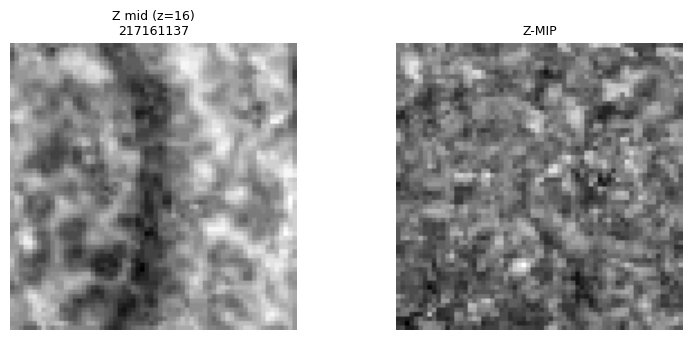


[402198414.tif] shape=(32, 128, 128) dtype=uint8 min=95 max=173


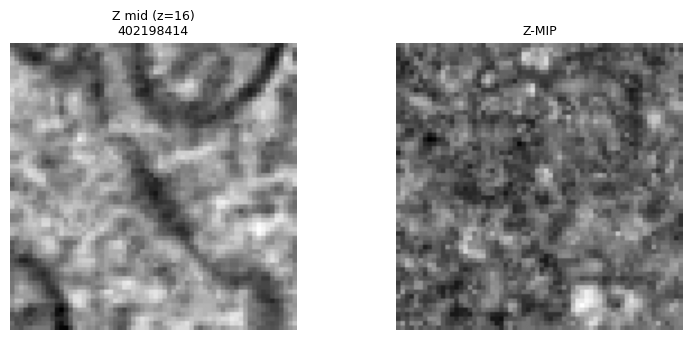


[204688941.tif] shape=(32, 128, 128) dtype=uint8 min=35 max=166


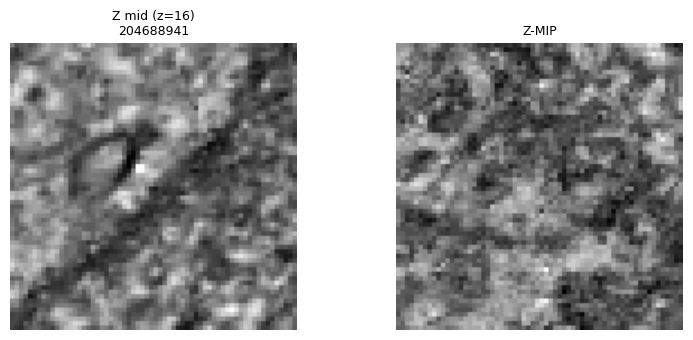

In [32]:
# ==============================================================
# Quick viewer: show 3–4 downloaded cubes (Z-mid + Z-MIP)
# ==============================================================

import random
from pathlib import Path
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

OUT_DIR = Path("/mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_incremental_nm")

# pick 3–4 tiffs
all_tiffs = sorted(OUT_DIR.glob("*.tif"))
if not all_tiffs:
    raise SystemExit(f"No TIFFs found in {OUT_DIR}")

k = min(4, max(1, len(all_tiffs)))
sampled = random.sample(all_tiffs, k)

def show_cube(zyx, title=""):
    # zyx expected shape: (Z, Y, X)
    Z, Y, X = zyx.shape
    z_mid = Z // 2
    mip = zyx.max(axis=0)

    plt.figure(figsize=(8,3.5))
    plt.subplot(1,2,1)
    plt.imshow(zyx[z_mid], cmap="gray")
    plt.title(f"Z mid (z={z_mid})\n{title}", fontsize=9)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(mip, cmap="gray")
    plt.title("Z-MIP", fontsize=9)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

for p in sampled:
    vol = tiff.imread(p)
    if vol.ndim == 3:
        zyx = vol
    else:
        # handle weird shapes (e.g., (Z,Y,X,1))
        zyx = np.squeeze(vol)
        if zyx.ndim != 3:
            print(f"[WARN] Skipping {p.name}: unexpected shape {vol.shape}")
            continue

    print(f"\n[{p.name}] shape={zyx.shape} dtype={zyx.dtype} "
          f"min={zyx.min()} max={zyx.max()}")

    show_cube(zyx, title=p.stem)


In [33]:
import sys, pandas as pd
print("Python:", sys.version)
print("Executable:", sys.executable)  # should point to /gscratch/stf/bitama/conda_envs/pt-cu121/bin/python

# show splits you generated
from pathlib import Path
SPLITS = Path("/mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/splits")
for name in ["train_synapses_balanced.csv","val_synapses_balanced.csv","test_synapses_balanced.csv"]:
    p = SPLITS / name
    print(name, "exists:", p.exists(), "size:", p.stat().st_size if p.exists() else 0)


Python: 3.10.19 (main, Oct 21 2025, 16:43:05) [GCC 11.2.0]
Executable: /mmfs1/gscratch/stf/bitama/envs/pt310-cu121/bin/python
train_synapses_balanced.csv exists: True size: 65725093
val_synapses_balanced.csv exists: True size: 7302750
test_synapses_balanced.csv exists: True size: 8114194


Fetching pool of 5000 synapses from synapses_pni_2...
Columns: ['id', 'created', 'superceded_id', 'valid', 'pre_pt_position_x', 'pre_pt_position_y', 'pre_pt_position_z', 'post_pt_position_x', 'post_pt_position_y', 'post_pt_position_z', 'ctr_pt_position_x', 'ctr_pt_position_y', 'ctr_pt_position_z', 'size', 'pre_pt_supervoxel_id', 'pre_pt_root_id', 'post_pt_supervoxel_id', 'post_pt_root_id']
Valid centers (nm): 4989 / 4989


,synapse_id,x_nm,y_nm,z_nm
0,358960866,296258.0,150102.0,22320.0
1,347512461,289726.0,178886.0,20028.0
2,156067310,175329.0,234447.0,22650.0
3,277511173,247886.0,94982.0,26553.0
4,112902753,150774.0,172020.0,24044.0


Saved 16 3D TIFF cubes to /mmfs1/gscratch/stf/bitama/microns_full/real_ml_data_full/em_sample_exact_center in 597.2s
First stack: shape=(32, 128, 128) dtype=uint8 min=87 max=174


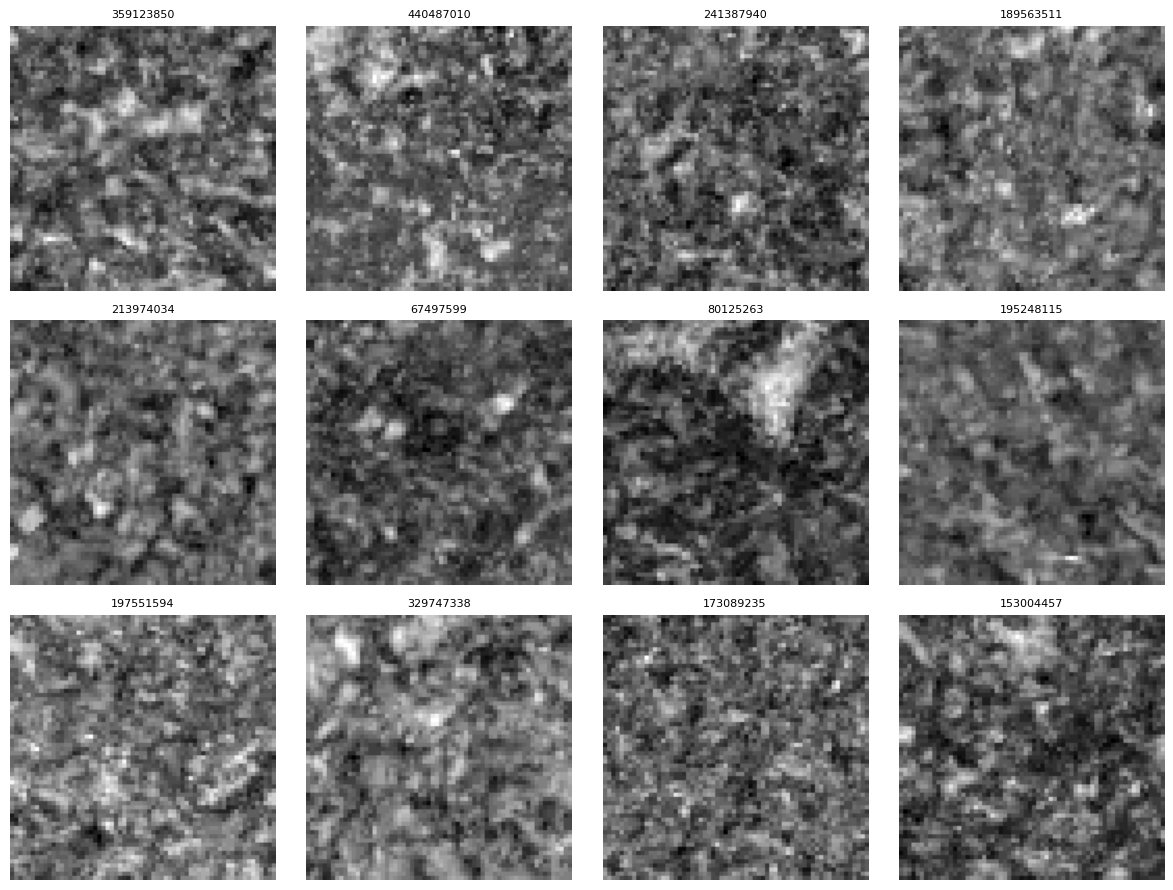

In [35]:
# === Exact-center 3D EM cubes via ctr_pt_position (nm) ========================
# Uses Materialize with split_positions=True to get ctr_pt_position_x/y/z (nm).
# Falls back to list-style 'ctr_pt_position' if split columns aren't available.
# Uses ImageryClient (nm) to assemble (Z,Y,X) stacks. Saves TIFFs + MIP gallery.
# ==============================================================================

import json, time
import numpy as np
import pandas as pd
from pathlib import Path
import tifffile as tiff
import matplotlib.pyplot as plt

from caveclient import CAVEclient
import imageryclient as ic  # install in terminal: pip install imageryclient

# ---------- config ----------
ROOT      = Path("/mmfs1/gscratch/stf/bitama/microns_full")
SPLITS    = ROOT / "real_ml_data_full" / "splits"
OUT_DIR   = ROOT / "real_ml_data_full" / "em_sample_exact_center"
OUT_DIR.mkdir(parents=True, exist_ok=True)

DATASTACK = "minnie65_public"
TABLE     = "synapses_pni_2"

POOL_SIZE = 5000   # fetch a pool from TRAIN, then sample
SAMPLE_N  = 16
SEED      = 0

# cube geometry (Z,Y,X)
Z_SLICES  = 32
CUBE_YX   = (128, 128)     # (W,H) pixels per slice

# physical voxel size (nm) for Z stepping (MICrONS: ~4x4x40 nm)
VOX_NM_X  = 4.0
VOX_NM_Y  = 4.0
VOX_NM_Z  = 40.0

# ---------- load TRAIN ids ----------
train_csv = SPLITS / "train_synapses_balanced.csv"
if not train_csv.exists():
    raise FileNotFoundError(f"Missing split file: {train_csv}")

train = pd.read_csv(train_csv)
if "synapse_id" not in train.columns:
    raise RuntimeError(f"'synapse_id' missing in {train_csv}. Got: {list(train.columns)}")

pool_ids = train["synapse_id"].astype(int)
if len(pool_ids) > POOL_SIZE:
    pool_ids = pool_ids.sample(POOL_SIZE, random_state=SEED)
pool_ids = pool_ids.tolist()

print(f"Fetching pool of {len(pool_ids)} synapses from {TABLE}...")

# ---------- query (ask for split positions) ----------
client = CAVEclient(DATASTACK)
df = client.materialize.query_table(
    TABLE,
    filter_in_dict={"id": pool_ids},
    limit=len(pool_ids),
    split_positions=True,   # <- key bit from the tutorial
)
print("Columns:", list(df.columns))

# ---------- prefer EXACT center columns ----------
have_split_center = all(c in df.columns for c in
                        ["ctr_pt_position_x","ctr_pt_position_y","ctr_pt_position_z"])

def parse_listish(v):
    if isinstance(v, (list, tuple, np.ndarray)) and len(v) >= 3:
        return float(v[0]), float(v[1]), float(v[2])
    if isinstance(v, str):
        try:
            vv = json.loads(v)
            if isinstance(vv, (list, tuple)) and len(vv) >= 3:
                return float(vv[0]), float(vv[1]), float(vv[2])
        except Exception:
            pass
    return (np.nan, np.nan, np.nan)

if have_split_center:
    centers = df[["ctr_pt_position_x","ctr_pt_position_y","ctr_pt_position_z"]].astype(float)
    centers.columns = ["x_nm","y_nm","z_nm"]
else:
    if "ctr_pt_position" not in df.columns:
        raise RuntimeError("Neither split center columns nor 'ctr_pt_position' are present.")
    xyz = df["ctr_pt_position"].apply(parse_listish)
    centers = pd.DataFrame(xyz.tolist(), columns=["x_nm","y_nm","z_nm"])

dfc = pd.concat([df[["id"]].rename(columns={"id":"synapse_id"}), centers], axis=1)
valid = dfc.dropna(subset=["x_nm","y_nm","z_nm"]).reset_index(drop=True)
print(f"Valid centers (nm): {len(valid)} / {len(dfc)}")
display(valid.head(min(5, len(valid))))

# sample for download
if len(valid) > SAMPLE_N:
    valid = valid.sample(SAMPLE_N, random_state=SEED).reset_index(drop=True)

# ---------- imagery client: expects NANOMETERS ----------
img_client = ic.ImageryClient(client=client)

def fetch_slice_nm(cx_nm, cy_nm, z_plane_nm, box_yx=CUBE_YX):
    ctr_nm = [int(round(cx_nm)), int(round(cy_nm)), int(round(z_plane_nm))]
    img, _ = img_client.image_and_segmentation_cutout(
        ctr_nm,
        bbox_size=box_yx,         # (W,H) pixels
        split_segmentations=False,
        scale_to_bounds=True,     # clamp if near edge
    )
    a = np.asarray(img)
    if a.ndim == 3:
        a = a[..., 0]
    return a.astype(np.uint8)

def build_cube_nm(x_nm, y_nm, z_nm, z_slices=Z_SLICES, box_yx=CUBE_YX):
    z0 = z_nm - (z_slices // 2) * VOX_NM_Z
    planes = []
    for i in range(z_slices):
        zp = z0 + i * VOX_NM_Z
        try:
            sl = fetch_slice_nm(x_nm, y_nm, zp, box_yx=box_yx)
        except Exception:
            sl = np.zeros((box_yx[1], box_yx[0]), dtype=np.uint8)
        planes.append(sl)
    return np.stack(planes, axis=0)   # (Z,Y,X)

# ---------- build & save ----------
saved = []
t0 = time.time()
for r in valid.itertuples(index=False):
    sid = int(r.synapse_id)
    vol = build_cube_nm(float(r.x_nm), float(r.y_nm), float(r.z_nm),
                        z_slices=Z_SLICES, box_yx=CUBE_YX)
    outp = OUT_DIR / f"{sid}.tif"
    tiff.imwrite(outp, vol, bigtiff=False)
    saved.append(outp)

print(f"Saved {len(saved)} 3D TIFF cubes to {OUT_DIR} in {time.time()-t0:.1f}s")

# ---------- gallery (MIP over Z) ----------
def mip_zyx(v): return v.max(axis=0)

if saved:
    s0 = tiff.imread(saved[0])
    print(f"First stack: shape={s0.shape} dtype={s0.dtype} min={s0.min()} max={s0.max()}")
    imgs = [mip_zyx(tiff.imread(p)) for p in saved[:min(12, len(saved))]]
    n, cols = len(imgs), 4
    rows = int(np.ceil(n/cols))
    plt.figure(figsize=(cols*3, rows*3))
    for i, img in enumerate(imgs, 1):
        plt.subplot(rows, cols, i); plt.axis("off")
        plt.title(saved[i-1].stem, fontsize=8)
        plt.imshow(img, cmap="gray")
    plt.tight_layout(); plt.show()
else:
    print("No images saved.")
